In [1]:
%load_ext rpy2.ipython
# Activates R cell magic

/home/wilfried/conda/wil_works/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Quadron Scores

## 1. Create Quadron Annotation

- **Install Quadron based on the author's documentation:**

https://github.com/aleksahak/Quadron/blob/master/README.pdf

- **Modify Quadron.R into the following QuadronCustom.R**

```
#QuadronCustom.R
args <- commandArgs(trailingOnly = TRUE)

print("NOTE: Loading Quadron core...", quote=FALSE)
load("Quadron.lib")

Quadron(FastaFile= args[1],
        OutFile  = args[2],
        nCPU     = as.numeric(args[3]),
        SeqPartitionBy = 1000000)
```

- **Run QuadronCustom.R**

```
Rscript QuadronCustom.R $in1 $in2 $in3
```

I ran Quadron on each chromosome separately to speed up the computation

- **Transform to BED format**

In [ ]:
#Merge.py
import re

QuadronBed = open('hg38.quadron.bed', 'w+')

chroms = range(1,23)

for chrom in chroms:
    chrom = str(chrom)
    QuadronOutput = open('hg38_chr'+chrom+'.quadron', 'rt')

    for line in QuadronOutput:
        array = re.compile("[ ]+").split(line.strip())
        if array[0] == 'DATA:':
            position, strand, length, score, motif = array[1], array[2], array[3], array[4], array[5]
            start = str(int(position)-1)
            end = str(int(start)+int(length))
            QuadronBed.write('chr'+chrom+'\t'+str(start)+'\t'+str(end)+'\t'+motif+'\t'+length+'\t'+strand+'\t'+score+'\n')


Output is **hg38.quadron.bed**.

Update: hs37d5.quadron.bed

## 2. Retrieve Genes subregions from UCSC Refseq

- **Download the bed files in UCSC Table browser with the options described in the following link**

https://genome.ucsc.edu/cgi-bin/hgTables?hgsid=702230323_PbIkmuyjC3zhyHv55fnC4oZVkPN4&clade=mammal&org=Human&db=hg38&hgta_group=genes&hgta_track=xenoRefGene&hgta_table=refGene&hgta_regionType=genome&position=chr1%3A11102837-11267747&hgta_outputType=bed&hgta_outFileName=TUTR.bed

Get Output for Coding, 5'UTR, 3'UTR Exons, and Introns, 1Kb Upstream and 1Kb Downstream.

Update: NCBI RefSeq - hg19

## 3. Retrieve Interspersed repeat

- **Download hg38.fa.out at**

http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/

- **Download hg19 chromOut.tar.gz at**

http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/chromOut.tar.gz


```
tar zxvf chromOut.tar.gz
rm -r Un_gl0002*
rm -r *gl000*
rm -r *hap*
mkdir RepeatMaskedHg19
mv 1* 2* 3/ 4/ 5/ 6/ 7/ 8/ 9/ M/ X/ Y/ RepeatMaskedHg19/
cd RepeatMaskedHg19/
cat 1/chr1.fa.out 2/chr2.fa.out 3/chr3.fa.out 4/chr4.fa.out 5/chr5.fa.out 6/chr6.fa.out 7/chr7.fa.out 8/chr8.fa.out 9/chr9.fa.out 10/chr10.fa.out 11/chr11.fa.out 12/chr12.fa.out 13/chr13.fa.out 14/chr14.fa.out 15/chr15.fa.out 16/chr16.fa.out 17/chr17.fa.out 18/chr18.fa.out 19/chr19.fa.out 20/chr20.fa.out 21/chr21.fa.out 22/chr22.fa.out > autosomes.out
```

- **Format to BED**

In [ ]:
#RM.py
import re

RepeatMasker = open('RepeatMaskedHg19/autosomes.out', 'rt')
RepeatMaskerBED = open('hg19RM_no_Interspersed.bed', 'w+')
InterspersedBED = open('hg19Interspersed.bed', 'w+')


chroms = []
for i in range(1,23):
    chroms.append('chr'+str(i))

i=0
for line in RepeatMasker:
    match = re.search('.*(chr[0-9]+)\s*([0-9]*)\s*([0-9]*)\s*\S*\s*\S\s*\S*\s*(\S*)\s*.*', line)
    
    if match:
        chrom = match.group(1)
        if chrom in chroms:
            start = match.group(2)
            end = match.group(3)
            repeat = match.group(4)
            #RepeatMaskerBED.write(chrom+'\t'+start+'\t'+end+'\t'+repeat+'\n')
            
            if 'LINE' in repeat or 'SINE' in repeat or 'LTR' in repeat or 'DNA' in repeat:
                InterspersedBED.write(chrom+'\t'+start+'\t'+end+'\t'+repeat+'\n')
            else:
                RepeatMaskerBED.write(chrom+'\t'+start+'\t'+end+'\t'+repeat+'\n')

Output is **Interspersed.bed**.

Update: RMhg19.bed

## eQTL coordinates

From GTEx?

In [287]:
%%bash

awk '{ sum += $3-$2; n++ } END { if (n > 0) print sum / n; }' eQTL.bed


1.17715


## Promoters and enhancers from FANTOM5

enhancers:

https://fantom.gsc.riken.jp/5/datafiles/latest/extra/Enhancers/

filename: human_permissive_enhancers_phase_1_and_2.bed.gz

promoters:

https://fantom.gsc.riken.jp/5/datafiles/latest/extra/CAGE_peaks/

filename:

hg19.cage_peak_phase1and2combined_coord.bed.gz

In [ ]:
%%bash

cut -f 1-3 human_permissive_enhancers_phase_1_and_2.bed > enhancers.bed

cut -f 1-6 hg19.cage_peak_phase1and2combined_coord.bed > promoters.bed

In [778]:
%%bash

awk '{ sum += $3-$2+1; n++ } END { if (n > 0) print sum / n; }' promoters.bed 

awk '{ sum += $3-$2+1; n++ } END { if (n > 0) print sum / n; }' enhancers.bed 

awk '{ sum += $3-$2+1; n++ } END { if (n > 0) print sum / n; }' quadron.clean.bed


21.5211
282.143
37.4212


## PhastCons

from UCSC
phastConsElements100way.bed

In [271]:
%%bash
cut -f 2-4 phastConsElements100way.bed | tail -n +2 > phastCons.bed

awk '{ sum += $3-$2; n++ } END { if (n > 0) print sum / n; }' phastCons.bed 


16.0398


## CTCF binding sites

from http://insulatordb.uthsc.edu/


In [272]:
%%bash
#alternative
cut -f 1-3 wgEncodeUwTfbsAg04449CtcfStdPkRep1.narrowPeak > hg19CTCF.bed
bedtools sort -i hg19CTCF.bed > hg19CTCF.sorted.bed
grep -v chrX hg19CTCF.sorted.bed | grep -v chrY | grep -v chrM | grep -v chrUn > temp
mv temp hg19CTCF.sorted.bed

awk '{ sum += $3-$2; n++ } END { if (n > 0) print sum / n; }' hg19CTCF.sorted.bed 


150.305


## TAD Boundaries

TAD data from:  DOI: 10.1038/nature14222

TAD boundaries computing from: doi 10.1093/nar/gkx738

(array([   0.,  250.,  500.,  750., 1000., 1250.]),
 <a list of 6 Text major ticklabel objects>)

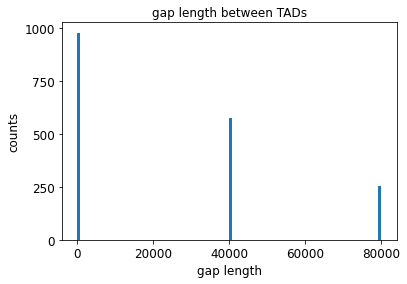

In [1973]:
import matplotlib
import matplotlib.pyplot as plt

infile = open('H1-ESC_Dixon2015-raw_TADs.txt', 'rt')
#outfile = open('TAD_boundary_regions.bed', 'w+')

TADs = []

for line in infile:
    chrom, start, end = line.strip().split('\t')
    lengthTAD = int(end) - int(start)
    if lengthTAD >= 200000:
        TADs.append([chrom, start, end])
        
boundaries = []

previous_TADchrom = ''
previous_TADend = 0
gap_lenghts = []
        
for TAD in TADs:
    if TAD[0] == previous_TADchrom:
        TADstart = TAD[1]
        #print(previous_TADend,TADstart)
        if int(TADstart) - int(previous_TADend) < 100000:
            gap_lenghts.append(int(TADstart) - int(previous_TADend))
            #print(previous_TADend,TADstart)
            boundary = int(int(previous_TADend) + (int(TADstart) - int(previous_TADend))/2)
            #print(boundary)
            #break
            boundary_region = boundary - 150000, boundary + 150000
            outfile.write(str(TAD[0])+'\t'+str(boundary_region[0])+\
                          '\t'+str(boundary_region[1])+'\t'+str(boundary)+'\n')
            
    previous_TADchrom = TAD[0]
    previous_TADend = TAD[2]

plt.hist(gap_lenghts, bins = 100)
plt.xlabel("gap length", size=12)
plt.ylabel('counts',size=12)
plt.title('gap length between TADs', size=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)



4470


(array([  0., 200., 400., 600., 800.]),
 <a list of 5 Text major ticklabel objects>)

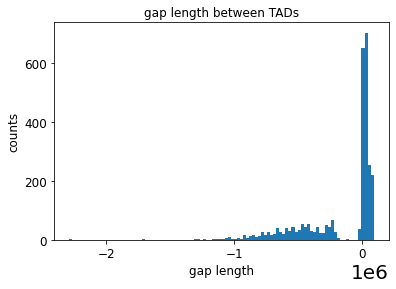

In [2010]:
import matplotlib
import matplotlib.pyplot as plt

infile = open('K562_Arrowhead_domainlist.txt', 'rt')
outfile = open('TAD_boundary_regions_new.bed', 'w+')

TADs = []

for line in infile:
    #print(line.strip().split('\t'))
    chrom, start, end = line.strip().split('\t')[:3]
    lengthTAD = int(end) - int(start)
    if lengthTAD >= 200000:
        TADs.append([chrom, start, end])

print(len(TADs))
boundaries = []

previous_TADchrom = ''
previous_TADend = 0
gap_lenghts = []
        
for TAD in TADs:
    if TAD[0] == previous_TADchrom:
        TADstart = TAD[1]
        #print(previous_TADend,TADstart)
        if int(TADstart) - int(previous_TADend) < 100000:
            gap_lenghts.append(int(TADstart) - int(previous_TADend))
            #print(previous_TADend,TADstart)
            if TADstart >= previous_TADend:
                boundary = int(int(previous_TADend) + (int(TADstart) - int(previous_TADend))/2)
            if TADstart < previous_TADend:
                boundary = int(int(TADstart) + (int(previous_TADend) - int(TADstart))/2)

            boundary_region = boundary - 150000, boundary + 150000
            #boundary_region = boundary - 5000, boundary + 5000
            outfile.write('chr'+str(TAD[0])+'\t'+str(boundary_region[0])+\
                          '\t'+str(boundary_region[1])+'\t'+str(boundary)+'\n')
            
    previous_TADchrom = TAD[0]
    previous_TADend = TAD[2]

plt.hist(gap_lenghts, bins = 100)
plt.xlabel("gap length", size=12)
plt.ylabel('counts',size=12)
plt.title('gap length between TADs', size=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)



## Recombination Hotspots

In [1994]:
infile = open('genetic.map', 'rt')
outfile = open('recomb_hotspots.bed', 'w+')

recombrates = []
intervals = []

for line in infile:
    if line[0:3] == 'chr':
        array = line.strip().split('\t')
        chrom, start, end, recombrate = array[0], array[1], array[2], array[3]
        recombrates.append(float(recombrate))
        intervals.append([chrom, start, end, recombrate])

mean = np.mean(recombrates)

for interval in intervals:
    #print(float(interval[3]),10*mean)
    if float(interval[3]) > 10*mean:
        #print('found')
        chrom, start, end, recombrate = interval
        outfile.write(chrom+'\t'+start+'\t'+end+'\t'+recombrate+'\n')
    
    

## RNAs

```
cut -f 1-3 RNAcentralGRCh38.bed > RNAcentralGRCh38.cut
liftOver RNAcentralGRCh38.cut hg38ToHg19.over.chain RNAcentral_hg19liftover.bed RNAcentral_hg19liftover.unmapped
```

# Preprocessing data

In [ ]:
# Saved as Locuschoice.py. Not run through Jupyter
import random
import sys


bedfile = open(sys.argv[1], 'rt')
outfile = open(sys.argv[2], 'w+')

last_chrom = 'chr0'
last_end = 0

tochoose = []


for line in bedfile:
    
    array = line.strip().split('\t')
    
    chrom = array[0]
    start = array[1]
    end = array[2]

    
    if chrom == last_chrom:
        if int(start) < last_end:
            tochoose.append(array)
            last_end = int(end)
        else:
            chosenmotif = tochoose[random.randint(0, len(tochoose)-1)]
            for field in chosenmotif[0:-1]:
                outfile.write(str(field)+'\t')
            outfile.write(chosenmotif[-1]+'\n')
            
            tochoose = [array]
            last_chrom = chrom
            last_end = int(end)
    else:
        if len(tochoose) > 0:
            chosenmotif = tochoose[random.randint(0, len(tochoose)-1)]
            for field in chosenmotif[0:-1]:
                outfile.write(str(field)+'\t')
            outfile.write(chosenmotif[-1]+'\n')
            
            tochoose = [array]
            last_chrom = chrom
            last_end = int(end)
        else:
            tochoose = [array]
            last_chrom = chrom
            last_end = int(end)

```
##preprocessing.sh

python Locuschoice.py hs37d5.quadron.bed quadron.nooverlap
grep + quadron.nooverlap > quadron+.bed
grep - quadron.nooverlap > quadron-.bed



bedtools sort -i hg19Upstream1k_RefSeq.bed | grep -v chrX | grep -v chrY | grep -v chrM | grep -v chrU | grep -v random > Upstream1k.sorted.bed
python Locuschoice.py Upstream1k.sorted.bed Upstream1k.nooverlap
bedtools coverage -a Upstream1k.nooverlap -b quadron+.bed | cut -f 1-3,10 -s > Upstream1k+.G4coverage
bedtools coverage -a Upstream1k.nooverlap -b quadron-.bed | cut -f 1-3,10 -s > Upstream1k-.G4coverage
bedtools getfasta -fi hg19.fa -bed Upstream1k.nooverlap > Upstream1k.getfa
bedtools coverage -a quadron+.bed -b Upstream1k.nooverlap  | awk '{sum+=$11}END{print sum}' > Upstream1k+.G4intersectcount
bedtools coverage -a quadron-.bed -b Upstream1k.nooverlap  | awk '{sum+=$11}END{print sum}' > Upstream1k-.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' Upstream1k.nooverlap > Upstream1k.bpcount



bedtools sort -i hg19FUTR_RefSeq.bed | grep -v chrX | grep -v chrY | grep -v chrM | grep -v chrU | grep -v random > FUTR.sorted.bed
python Locuschoice.py FUTR.sorted.bed FUTR.nooverlap
grep + FUTR.nooverlap > FUTR+.nooverlap
grep - FUTR.nooverlap > FUTR-.nooverlap
bedtools coverage -a FUTR+.nooverlap -b quadron+.bed -s | cut -f 1-3,10 > FUTR++.G4coverage
bedtools coverage -a FUTR-.nooverlap -b quadron+.bed -S | cut -f 1-3,10 > FUTR-+.G4coverage
bedtools coverage -a FUTR-.nooverlap -b quadron-.bed -s | cut -f 1-3,10 > FUTR--.G4coverage
bedtools coverage -a FUTR+.nooverlap -b quadron-.bed -S | cut -f 1-3,10 > FUTR+-.G4coverage
bedtools getfasta -fi hg19.fa -bed FUTR+.nooverlap > FUTR+.getfa
bedtools getfasta -fi hg19.fa -bed FUTR-.nooverlap > FUTR-.getfa
bedtools coverage -a quadron+.bed -b FUTR+.nooverlap -s | awk '{sum+=$11}END{print sum}' > FUTR++.G4intersectcount
bedtools coverage -a quadron+.bed -b FUTR-.nooverlap -S  | awk '{sum+=$11}END{print sum}' > FUTR-+.G4intersectcount
bedtools coverage -a quadron-.bed -b FUTR-.nooverlap -s | awk '{sum+=$11}END{print sum}' > FUTR--.G4intersectcount
bedtools coverage -a quadron-.bed -b FUTR+.nooverlap -S  | awk '{sum+=$11}END{print sum}' > FUTR+-.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' FUTR+.nooverlap > FUTR+.bpcount
awk '{sum+=$3-$2+1}END{print sum}' FUTR-.nooverlap > FUTR-.bpcount

bedtools sort -i hg19Exons_RefSeq.bed | grep -v chrX| grep -v chrY | grep -v chrM | grep -v chrU | grep -v random > Exons.sorted.bed
python Locuschoice.py Exons.sorted.bed Exons.nooverlap
grep + Exons.nooverlap > Exons+.nooverlap
grep - Exons.nooverlap > Exons-.nooverlap
bedtools coverage -a Exons+.nooverlap -b quadron+.bed -s | cut -f 1-3,10 > Exons++.G4coverage
bedtools coverage -a Exons-.nooverlap -b quadron+.bed -S | cut -f 1-3,10 > Exons-+.G4coverage
bedtools coverage -a Exons-.nooverlap -b quadron-.bed -s | cut -f 1-3,10 > Exons--.G4coverage
bedtools coverage -a Exons+.nooverlap -b quadron-.bed -S | cut -f 1-3,10 > Exons+-.G4coverage
bedtools getfasta -fi hg19.fa -bed Exons+.nooverlap > Exons+.getfa
bedtools getfasta -fi hg19.fa -bed Exons-.nooverlap > Exons-.getfa
bedtools coverage -a quadron+.bed -b Exons+.nooverlap -s | awk '{sum+=$11}END{print sum}' > Exons++.G4intersectcount
bedtools coverage -a quadron+.bed -b Exons-.nooverlap -S  | awk '{sum+=$11}END{print sum}' > Exons-+.G4intersectcount
bedtools coverage -a quadron-.bed -b Exons-.nooverlap -s | awk '{sum+=$11}END{print sum}' > Exons--.G4intersectcount
bedtools coverage -a quadron-.bed -b Exons+.nooverlap -S  | awk '{sum+=$11}END{print sum}' > Exons+-.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' Exons+.nooverlap > Exons+.bpcount
awk '{sum+=$3-$2+1}END{print sum}' Exons-.nooverlap > Exons-.bpcount

bedtools sort -i hg19Introns_RefSeq.bed | grep -v chrX | grep -v chrY | grep -v chrM | grep -v chrU | grep -v random > Introns.sorted.bed
python Locuschoice.py Introns.sorted.bed Introns.nooverlap
grep + Introns.nooverlap > Introns+.nooverlap
grep - Introns.nooverlap > Introns-.nooverlap
bedtools coverage -a Introns+.nooverlap -b quadron+.bed -s | cut -f 1-3,10 > Introns++.G4coverage
bedtools coverage -a Introns-.nooverlap -b quadron+.bed -S | cut -f 1-3,10 > Introns-+.G4coverage
bedtools coverage -a Introns-.nooverlap -b quadron-.bed -s | cut -f 1-3,10 > Introns--.G4coverage
bedtools coverage -a Introns+.nooverlap -b quadron-.bed -S | cut -f 1-3,10 > Introns+-.G4coverage
bedtools getfasta -fi hg19.fa -bed Introns+.nooverlap > Introns+.getfa
bedtools getfasta -fi hg19.fa -bed Introns-.nooverlap > Introns-.getfa
bedtools coverage -a quadron+.bed -b Introns+.nooverlap -s | awk '{sum+=$11}END{print sum}' > Introns++.G4intersectcount
bedtools coverage -a quadron+.bed -b Introns-.nooverlap -S  | awk '{sum+=$11}END{print sum}' > Introns-+.G4intersectcount
bedtools coverage -a quadron-.bed -b Introns-.nooverlap -s | awk '{sum+=$11}END{print sum}' > Introns--.G4intersectcount
bedtools coverage -a quadron-.bed -b Introns+.nooverlap -S  | awk '{sum+=$11}END{print sum}' > Introns+-.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' Introns+.nooverlap > Introns+.bpcount
awk '{sum+=$3-$2+1}END{print sum}' Introns-.nooverlap > Introns-.bpcount

bedtools sort -i hg19TUTR_RefSeq.bed | grep -v chrX | grep -v chrY | grep -v chrM | grep -v chrU | grep -v random > TUTR.sorted.bed
python Locuschoice.py TUTR.sorted.bed TUTR.nooverlap
grep + TUTR.nooverlap > TUTR+.nooverlap
grep - TUTR.nooverlap > TUTR-.nooverlap
bedtools coverage -a TUTR+.nooverlap -b quadron+.bed -s | cut -f 1-3,10 > TUTR++.G4coverage
bedtools coverage -a TUTR-.nooverlap -b quadron+.bed -S | cut -f 1-3,10 > TUTR-+.G4coverage
bedtools coverage -a TUTR-.nooverlap -b quadron-.bed -s | cut -f 1-3,10 > TUTR--.G4coverage
bedtools coverage -a TUTR+.nooverlap -b quadron-.bed -S | cut -f 1-3,10 > TUTR+-.G4coverage
bedtools getfasta -fi hg19.fa -bed TUTR+.nooverlap > TUTR+.getfa
bedtools getfasta -fi hg19.fa -bed TUTR-.nooverlap > TUTR-.getfa
bedtools coverage -a quadron+.bed -b TUTR+.nooverlap -s | awk '{sum+=$11}END{print sum}' > TUTR++.G4intersectcount
bedtools coverage -a quadron+.bed -b TUTR-.nooverlap -S  | awk '{sum+=$11}END{print sum}' > TUTR-+.G4intersectcount
bedtools coverage -a quadron-.bed -b TUTR-.nooverlap -s | awk '{sum+=$11}END{print sum}' > TUTR--.G4intersectcount
bedtools coverage -a quadron-.bed -b TUTR+.nooverlap -S  | awk '{sum+=$11}END{print sum}' > TUTR+-.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' TUTR+.nooverlap > TUTR+.bpcount
awk '{sum+=$3-$2+1}END{print sum}' TUTR-.nooverlap > TUTR-.bpcount

bedtools sort -i hg19Downstream1k_RefSeq.bed  | grep -v chrX | grep -v chrY | grep -v chrM | grep -v chrU | grep -v random > Downstream1k.sorted.bed
python Locuschoice.py Downstream1k.sorted.bed Downstream1k.nooverlap
bedtools coverage -a Downstream1k.nooverlap -b quadron+.bed | cut -f 1-3,10 -s > Downstream1k+.G4coverage
bedtools coverage -a Downstream1k.nooverlap -b quadron-.bed | cut -f 1-3,10 -s > Downstream1k-.G4coverage
bedtools getfasta -fi hg19.fa -bed Downstream1k.nooverlap > Downstream1k.getfa
bedtools coverage -a quadron+.bed -b Downstream1k.nooverlap  | awk '{sum+=$11}END{print sum}' > Downstream1k+.G4intersectcount
bedtools coverage -a quadron-.bed -b Downstream1k.nooverlap  | awk '{sum+=$11}END{print sum}' > Downstream1k-.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' Downstream1k.nooverlap > Downstream1k.bpcount

bedtools sort -i RepOrigin.bed | grep -v chrX | grep -v chrY | grep -v chrM | grep -v chrU | grep -v random > RepOrigin.sorted.bed
python Locuschoice.py RepOrigin.sorted.bed RepOrigin.nooverlap
bedtools coverage -a RepOrigin.nooverlap -b quadron+.bed | cut -f 1-3,8 > RepOrigin+.G4coverage
bedtools coverage -a RepOrigin.nooverlap -b quadron-.bed | cut -f 1-3,8 > RepOrigin-.G4coverage
bedtools getfasta -fi hg19.fa -bed RepOrigin.nooverlap > RepOrigin.getfa
bedtools coverage -a quadron+.bed -b RepOrigin.nooverlap  | awk '{sum+=$11}END{print sum}' > RepOrigin+.G4intersectcount
bedtools coverage -a quadron-.bed -b RepOrigin.nooverlap  | awk '{sum+=$11}END{print sum}' > RepOrigin-.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' RepOrigin.nooverlap > RepOrigin.bpcount


bedtools sort -i GTExCombinedeQTL.bed | cut -f 1-4 | uniq | awk '{if($2!=$3) print $0}' | grep -v chrX | grep -v chrY | grep -v chrM | grep -v chrU | grep -v random > eQTL.sorted.bed
python Locuschoice.py eQTL.sorted.bed eQTL.nooverlap
bedtools coverage -a eQTL.nooverlap -b quadron+.bed | cut -f 1-3,8 > eQTL+.G4coverage
bedtools coverage -a eQTL.nooverlap -b quadron-.bed | cut -f 1-3,8 > eQTL-.G4coverage
bedtools getfasta -fi hg19.fa -bed eQTL.nooverlap > eQTL.getfa
bedtools coverage -a quadron+.bed -b eQTL.nooverlap  | awk '{sum+=$11}END{print sum}' > eQTL+.G4intersectcount
bedtools coverage -a quadron-.bed -b eQTL.nooverlap  | awk '{sum+=$11}END{print sum}' > eQTL-.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' eQTL.nooverlap > eQTL.bpcount


bedtools slop -i eQTL.sorted.bed -g hg19.genome -b 50 > eQTL.extended
bedtools sort -i eQTL.extended| cut -f 1-4 | uniq | awk '{if($2!=$3) print $0}' | grep -v chrX | grep -v chrY | grep -v chrM | grep -v chrU | grep -v random > eQTL.extended.sorted.bed
python Locuschoice.py eQTL.extended.sorted.bed eQTL.extended.nooverlap
bedtools coverage -a eQTL.extended.nooverlap -b quadron+.bed | cut -f 1-3,8 > eQTL+.extended.G4coverage
bedtools coverage -a eQTL.extended.nooverlap -b quadron-.bed | cut -f 1-3,8 > eQTL-.extended.G4coverage
bedtools getfasta -fi hg19.fa -bed eQTL.extended.nooverlap > eQTL.extended.getfa
bedtools coverage -a quadron+.bed -b eQTL.extended.nooverlap  | awk '{sum+=$11}END{print sum}' > eQTL+.extended.G4intersectcount
bedtools coverage -a quadron-.bed -b eQTL.extended.nooverlap  | awk '{sum+=$11}END{print sum}' > eQTL-.extended.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' eQTL.extended.nooverlap > eQTL.extended.bpcount


bedtools sort -i enhancers.bed | grep -v chrX | grep -v chrY | grep -v chrM | grep -v chrU | grep -v random > enhancers.sorted.bed
python Locuschoice.py enhancers.sorted.bed enhancers.nooverlap
bedtools coverage -a enhancers.nooverlap -b quadron+.bed | cut -f 1-3,7  > enhancers+.G4coverage
bedtools coverage -a enhancers.nooverlap -b quadron-.bed | cut -f 1-3,7  > enhancers-.G4coverage
bedtools getfasta -fi hg19.fa -bed enhancers.nooverlap > enhancers.getfa
bedtools coverage -a quadron+.bed -b enhancers.nooverlap  | awk '{sum+=$11}END{print sum}' > enhancers+.G4intersectcount
bedtools coverage -a quadron-.bed -b enhancers.nooverlap  | awk '{sum+=$11}END{print sum}' > enhancers-.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' enhancers.nooverlap > enhancers.bpcount

bedtools sort -i promoters.bed | grep -v chrX | grep -v chrY | grep -v chrM | grep -v chrU | grep -v random > promoters.sorted.bed
python Locuschoice.py promoters.sorted.bed promoters.nooverlap
bedtools coverage -a promoters.nooverlap -b quadron+.bed | cut -f 1-3,7  > promoters+.G4coverage
bedtools coverage -a promoters.nooverlap -b quadron-.bed | cut -f 1-3,7  > promoters-.G4coverage
bedtools getfasta -fi hg19.fa -bed promoters.nooverlap > promoters.getfa
bedtools coverage -a quadron+.bed -b promoters.nooverlap  | awk '{sum+=$11}END{print sum}' > promoters+.G4intersectcount
bedtools coverage -a quadron-.bed -b promoters.nooverlap  | awk '{sum+=$11}END{print sum}' > promoters-.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' promoters.nooverlap > promoters.bpcount


bedtools sort -i phastCons.bed | grep -v chrX | grep -v chrY | grep -v chrM | grep -v chrU | grep -v random | grep -v hap > phastCons.sorted.bed
python Locuschoice.py phastCons.sorted.bed phastCons.nooverlap
bedtools coverage -a phastCons.nooverlap -b quadron+.bed | cut -f 1-3,7  > phastCons+.G4coverage
bedtools coverage -a phastCons.nooverlap -b quadron-.bed | cut -f 1-3,7  > phastCons-.G4coverage
bedtools getfasta -fi hg19.fa -bed phastCons.nooverlap > phastCons.getfa
bedtools coverage -a quadron+.bed -b phastCons.nooverlap  | awk '{sum+=$11}END{print sum}' > phastCons+.G4intersectcount
bedtools coverage -a quadron-.bed -b phastCons.nooverlap  | awk '{sum+=$11}END{print sum}' > phastCons-.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' phastCons.nooverlap > phastCons.bpcount


bedtools slop -i phastCons.sorted.bed -g hg19.genome -b 50 > phastCons.extended
bedtools sort -i phastCons.extended > phastCons.extended.sorted.bed
python Locuschoice.py phastCons.extended.sorted.bed phastCons.extended.nooverlap
bedtools coverage -a phastCons.extended.nooverlap -b quadron+.bed | cut -f 1-3,7  > phastCons+.extended.G4coverage
bedtools coverage -a phastCons.extended.nooverlap -b quadron-.bed | cut -f 1-3,7  > phastCons-.extended.G4coverage
bedtools getfasta -fi hg19.fa -bed phastCons.extended.nooverlap > phastCons.extended.getfa
bedtools coverage -a quadron+.bed -b phastCons.extended.nooverlap  | awk '{sum+=$11}END{print sum}' > phastCons+.extended.G4intersectcount
bedtools coverage -a quadron-.bed -b phastCons.extended.nooverlap  | awk '{sum+=$11}END{print sum}' > phastCons-.extended.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' phastCons.extended.nooverlap > phastCons.extended.bpcount

bedtools sort -i TAD_boundary_regions_new.bed | grep -v chrX | grep -v chrY | grep -v chrM | grep -v chrU | grep -v random > TAD_boundary_regions.sorted.bed
python Locuschoice.py TAD_boundary_regions.sorted.bed TAD_boundary_regions.nooverlap
bedtools coverage -a TAD_boundary_regions.nooverlap -b quadron+.bed | cut -f 1-3,8 > TADB+.G4coverage
bedtools coverage -a TAD_boundary_regions.nooverlap -b quadron-.bed | cut -f 1-3,8 > TADB-.G4coverage
bedtools getfasta -fi hg19.fa -bed TAD_boundary_regions.nooverlap > TADB.getfa
bedtools coverage -a quadron+.bed -b TAD_boundary_regions.nooverlap  | awk '{sum+=$11}END{print sum}' > TAD_boundary_regions+.G4intersectcount
bedtools coverage -a quadron-.bed -b TAD_boundary_regions.nooverlap  | awk '{sum+=$11}END{print sum}' > TAD_boundary_regions-.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' TAD_boundary_regions.nooverlap > TADB.bpcount

bedtools sort -i recomb_hotspots.bed | grep -v chrX | grep -v chrY | grep -v chrM | grep -v chrU | grep -v random > recomb_hotspots.sorted.bed
python Locuschoice.py recomb_hotspots.sorted.bed recomb_hotspots.nooverlap
bedtools coverage -a recomb_hotspots.nooverlap -b quadron+.bed | cut -f 1-3,8 > recomb_hotspots+.G4coverage
bedtools coverage -a recomb_hotspots.nooverlap -b quadron-.bed | cut -f 1-3,8 > recomb_hotspots-.G4coverage
bedtools getfasta -fi hg19.fa -bed recomb_hotspots.nooverlap > recomb_hotspots.getfa
bedtools coverage -a quadron+.bed -b recomb_hotspots.nooverlap  | awk '{sum+=$11}END{print sum}' > recomb_hotspots+.G4intersectcount
bedtools coverage -a quadron-.bed -b recomb_hotspots.nooverlap  | awk '{sum+=$11}END{print sum}' > recomb_hotspots-.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' recomb_hotspots.nooverlap > recomb_hotspots.bpcount

bedtools sort -i CpGIsland.bed | grep -v chrX | grep -v chrY | grep -v chrM | grep -v chrU | grep -v random > CpGIsland.sorted.bed
python Locuschoice.py CpGIsland.sorted.bed CpGIsland.nooverlap
bedtools coverage -a CpGIsland.nooverlap -b quadron+.bed | cut -f 1-3,8 > CpGIsland+.G4coverage
bedtools coverage -a CpGIsland.nooverlap -b quadron-.bed | cut -f 1-3,8 > CpGIsland-.G4coverage
bedtools getfasta -fi hg19.fa -bed CpGIsland.nooverlap > CpGIsland.getfa
bedtools coverage -a quadron+.bed -b CpGIsland.nooverlap  | awk '{sum+=$11}END{print sum}' > CpGIsland+.G4intersectcount
bedtools coverage -a quadron-.bed -b CpGIsland.nooverlap  | awk '{sum+=$11}END{print sum}' > CpGIsland-.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' CpGIsland.nooverlap > CpGIsland.bpcount

cat Upstream1k.nooverlap FUTR.nooverlap Exons.nooverlap TUTR.nooverlap Downstream1k.nooverlap Introns.nooverlap CpGIsland.nooverlap | cut -f 1-3 > genic.bed
bedtools sort -i genic.bed > genic.sorted.bed
python Locuschoice.py genic.sorted.bed genic.nooverlap
bedtools coverage -a genic.nooverlap -b quadron+.bed | cut -f 1-3,7 > genic+.G4coverage
bedtools coverage -a genic.nooverlap -b quadron-.bed | cut -f 1-3,7 > genic-.G4coverage
bedtools getfasta -fi hg19.fa -bed genic.nooverlap > genic.getfa
bedtools coverage -a quadron+.bed -b genic.nooverlap  | awk '{sum+=$11}END{print sum}' > genic+.G4intersectcount
bedtools coverage -a quadron-.bed -b genic.nooverlap  | awk '{sum+=$11}END{print sum}' > genic-.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' genic.nooverlap > genic.bpcount

cat hg19Upstream1k_RefSeq.sorted.bed hg19FUTR_RefSeq.sorted.bed hg19Exons_RefSeq.sorted.bed hg19firstIntrons_RefSeq.sorted.bed hg19notfirstIntrons_RefSeq.sorted.bed hg19TUTR_RefSeq.sorted.bed hg19Downstream1k_RefSeq.sorted.bed hg19RM.bed hg19Interspersed.bed RepOrigin.bed GTExCombinedeQTL.bed enhancers.bed promoters.bed phastCons.bed hg19CTCF.sorted.bed TAD_boundary_regions_new.bed recomb_hotspots.bed hg19Upstream5kSorted_RefSeq.bed hg19Downstream5kSorted_RefSeq.bed ancestral_repeats.bed CpGIsland.bed RNAcentral_hg19liftover.bed gaps.bed IGH.bed> CR_to_merge.bed
cut -f 1-3 CR_to_merge.bed > CR_to_merge.cut.bed
bedtools sort -i CR_to_merge.cut.bed > CR_to_merge.sorted.bed 
bedtools merge -i  CR_to_merge.sorted.bed > CRgenome.bed
grep -v gl CRgenome.bed > CRgenome.bed.filter1
grep -v X CRgenome.bed.filter1 > CRgenome.bed.filter2
grep -v Y CRgenome.bed.filter2 > CRgenome.bed.filter3
grep -v hap CRgenome.bed.filter3 > CRgenome.bed.filter4
grep -v M CRgenome.bed.filter4 > CRgenome.bed.filter5
bedtools sort -i CRgenome.bed.filter5 > CRgenome.bed.filter5.sorted
bedtools complement -i CRgenome.bed.filter5.sorted -g hg19.genome > NCNR.bed
bedtools sort -i NCNR.bed > NCNR.sorted.bed
python Locuschoice.py NCNR.sorted.bed NCNR.nooverlap
bedtools coverage -a NCNR.nooverlap -b quadron+.bed | cut -f 1-3,7 > NCNR+.G4coverage
bedtools coverage -a NCNR.nooverlap -b quadron-.bed | cut -f 1-3,7 > NCNR-.G4coverage
bedtools getfasta -fi hg19.fa -bed NCNR.nooverlap > NCNR.getfa
bedtools coverage -a quadron+.bed -b NCNR.nooverlap  | awk '{sum+=$11}END{print sum}' > NCNR+.G4intersectcount
bedtools coverage -a quadron-.bed -b NCNR.nooverlap  | awk '{sum+=$11}END{print sum}' > NCNR-.G4intersectcount
awk '{sum+=$3-$2+1}END{print sum}' NCNR.nooverlap > NCNR.bpcount

awk '{sum +=$3-$2+1}END{print sum}' quadron+.bed > all+.G4coverage
wc -l quadron+.bed  > all+.G4intersectcount
awk '{sum +=$3-$2+1}END{print sum}' quadron-.bed > all+.G4coverage
wc -l quadron-.bed  > all-.G4intersectcount
awk '{sum +=$2-10000+1}END{print sum}' hg19.genome > all.bpcount
```

In [1704]:
%%bash

wc -l quadron.nooverlap

awk '{sum +=$3-$2}END{print sum}' quadron.nooverlap

awk '{sum +=$2-10000}END{print sum}' hg19.genome 

670073 quadron.nooverlap
24404979
2880813286


In [1725]:
%%bash

wc -l hs37d5.quadron.bed

awk '{ sum += $3-$2; n++ } END { if (n > 0) print sum / n; }' hs37d5.quadron.bed

awk '{sum +=$3-$2}END{print sum}' hs37d5.quadron.bed

awk '{sum +=$2-10000}END{print sum}' hg19.genome 

670076 hs37d5.quadron.bed
36.4214
24405113
2880813286


```
bedtools intersect -a quadron+.bed -b Upstream1k.nooverlap -wa -wb | cut -f 1-3 > Upstream1k+.G4intersect

bedtools intersect -a quadron+.bed -b NCNR.nooverlap -wa -wb | cut -f 1-3 > NCNR+.G4intersect

bedtools intersect -a quadron+.bed -b Exons+.nooverlap -s -wa -wb | cut -f 1-3 > Exons++.G4intersect

bedtools intersect -a quadron+.bed -b Exons-.nooverlap -S -wa -wb | cut -f 1-3 > Exons-+.G4intersect
```

[1] 335784
[1] 16843
[1] 32733
[1] 3026
[1] 5674
[1] 16
[1] 1881
[1] 145  71  36  94  38 110
[1] "exons transcribed" "exons transcribed" "exons transcribed"
[4] "exons transcribed" "exons transcribed" "exons transcribed"


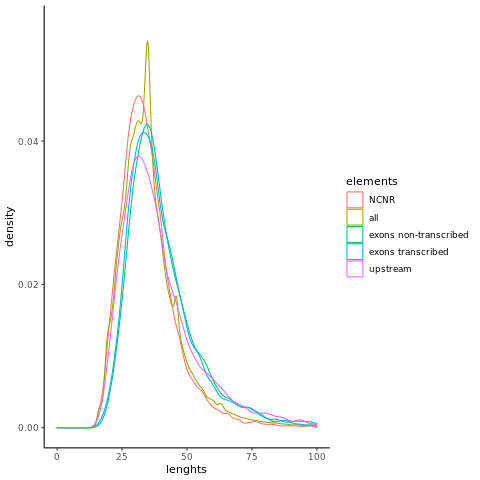

In [1440]:
%%R

library(ggplot2)

quadronfile <- read.csv('quadron+.bed', sep = '\t',header=FALSE)
upstreamfile <- read.csv('Upstream1k+.G4intersect', sep = '\t',header=FALSE)
NCNRfile <- read.csv('NCNR+.G4intersect', sep = '\t',header=FALSE)
exonsSensefile <- read.csv('Exons++.G4intersect', sep = '\t',header=FALSE)
exonsAntiSensefile <- read.csv('Exons-+.G4intersect', sep = '\t',header=FALSE)


all_lengths = quadronfile$V3 - quadronfile$V2 +1
upstream_lengths = upstreamfile$V3 - upstreamfile$V2 + 1
NCNR_lengths = NCNRfile$V3 - NCNRfile$V2 + 1
exonsSense_lengths = exonsSensefile$V3 - exonsSensefile$V2 +1 
exonsAntiSense_lengths = exonsAntiSensefile$V3 - exonsAntiSensefile$V2 +1 

print(length(all_lengths))
print(length(upstream_lengths))
print(length(NCNR_lengths))
print(length(exonsSense_lengths))
print(length(exonsAntiSense_lengths))

print(min(all_lengths))
print(max(all_lengths))

lengths = c(all_lengths,upstream_lengths,NCNR_lengths,exonsSense_lengths,exonsAntiSense_lengths)
elements = c(rep('all',length(all_lengths)),
                              rep('upstream',length(upstream_lengths)),
                              rep('NCNR',length(NCNR_lengths)),
                              rep('exons non-transcribed',length(exonsSense_lengths)),
                              rep('exons transcribed',length(exonsAntiSense_lengths)))

print(tail(lengths))
print(tail(elements))

df <- data.frame(lenghts = lengths,
                 elements = elements)

ggplot(df, aes(x=lenghts, color=elements)) + 
 geom_histogram(aes(y=..density..), bins=100, colour="white", fill="white")+
 geom_density(alpha=.2) +
 theme_classic() +
 scale_x_continuous(limits=c(0,100))



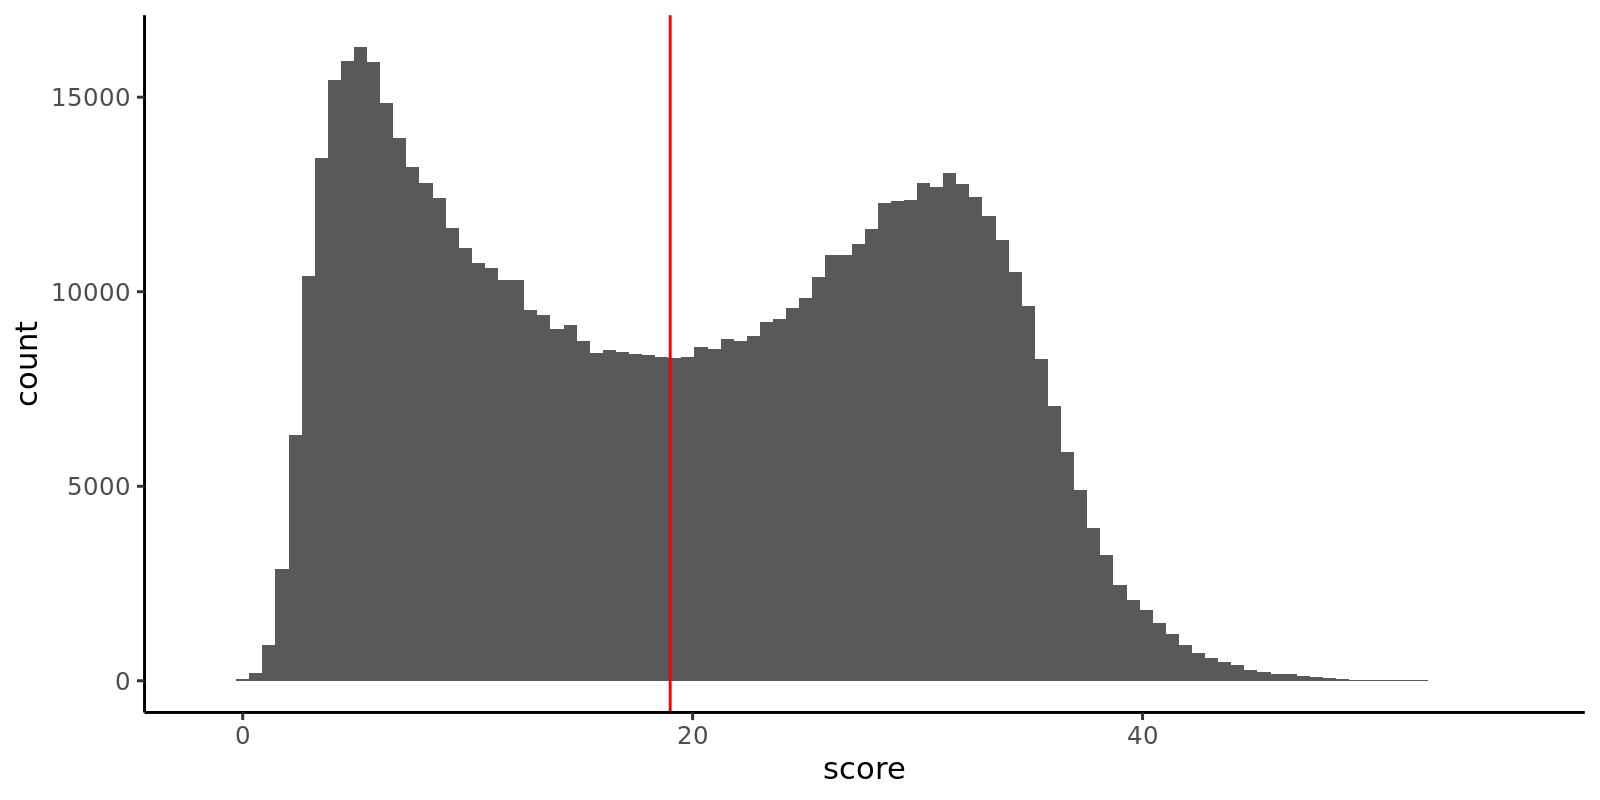

In [47]:
%%R -w 8 -h 4 --units in -r 200


quadronfile = read.csv('quadron.nooverlap', sep='\t', header=FALSE)

df = cbind.data.frame(quadronfile)

head(df)
colnames(df) <- c('chrom','start','end','motif','length','strand','score')

g <- ggplot(df, aes(x=score)) + geom_histogram(bins=100) + 
    theme_classic() +
    geom_vline(xintercept=19, color="red") +
   labs(family="sans")

grid.arrange(g)
G <- arrangeGrob(g)
ggsave(file='QuadronScoresDistribution.pdf',G, width=8, height=4, dpi=300)



## 4. Perform bedtools annotation

```
bedtools annotate -i quadron.nooverlap -files Upstream1k.nooverlap FUTR.nooverlap Exons.nooverlap Introns.nooverlap TUTR.nooverlap Downstream1k.nooverlap hg19RM.bed hg19Interspersed.bed RepOrigin.nooverlap eQTL.nooverlap enhancers.nooverlap promoters.nooverlap phastCons.nooverlap hg19CTCF.sorted.bed TAD_boundary_regions.nooverlap recomb_hotspots.nooverlap hg19Upstream5kSorted_RefSeq.bed hg19Downstream5kSorted_RefSeq.bed  CpGIsland.nooverlap NCNR.nooverlap eQTL.extended.nooverlap phastCons.extended.nooverlap> Annotate19Scores

bedtools annotate -s -i quadron.nooverlap -files FUTR.nooverlap Exons.nooverlap Introns.nooverlap TUTR.nooverlap > Annotate19Scores_ref

bedtools annotate -S -i quadron.nooverlap -files FUTR.nooverlap Exons.nooverlap Introns.nooverlap TUTR.nooverlap > Annotate19Scores_rev
```

## 5. Compile data in a pandas dataframe

In [2]:
import pandas as pd

Annotatefile = open('Annotate19Scores', 'rt')

colnames = ['chrom', 'start', 'end', 'motif', 'length', 'strand', 'score', 'Upstream', 'FUTR', 'Coding', 'Introns',\
           'TUTR', 'Downstream', 'RM_no_Interspersed', 'Interspersed', 'RepOrigin', 'eQTL', 'enhancers', 'promoters',\
            'phastCons', 'CTCF', 'TAD_Boundaries', 'Recomb Hotspots', 'Upstream5k', 'Downstream5k', 'CpG Islands',
            'NCNR', 'extended eQTL', 'extended phastCons']
rows = []

for line in Annotatefile:
    array = line.strip().split('\t')
    #print(array)
    #break
    if array[6] == 'NA': # remove G4 without a score
        continue
    else:
        rows.append([array[0], int(array[1]), int(array[2]), array[3], int(array[4]), array[5], float(array[6]),\
                    float(array[7]),float(array[8]),float(array[9]),float(array[10]),float(array[11]),\
                    float(array[12]),float(array[13]), float(array[14]), float(array[15]), float(array[16]),\
                    float(array[17]),float(array[18]),float(array[19]),float(array[20]),float(array[21]),float(array[22]),\
                    float(array[23]), float(array[24]), float(array[25]), float(array[26]), float(array[27]), float(array[28])])

dataframe_annotate = pd.DataFrame(data=rows, columns=colnames)


In [3]:
import pandas as pd

Annotatefile = open('Annotate19Scores_ref', 'rt')

colnames = ['chrom', 'start', 'end', 'motif', 'length', 'strand', 'score', 'FUTR', 'Coding', 'Introns',\
           'TUTR']
rows = []

for line in Annotatefile:
    array = line.strip().split('\t')
    #print(array)
    #break
    if array[6] == 'NA': # remove G4 without a score
        continue
    else:
        rows.append([array[0], int(array[1]), int(array[2]), array[3], int(array[4]), array[5], float(array[6]),\
                    float(array[7]),float(array[8]),float(array[9]),float(array[10])])

dataframe_annotate_ref = pd.DataFrame(data=rows, columns=colnames)


In [4]:
import pandas as pd

Annotatefile = open('Annotate19Scores_rev', 'rt')

colnames = ['chrom', 'start', 'end', 'motif', 'length', 'strand', 'score', 'FUTR', 'Coding', 'Introns',\
           'TUTR']
rows = []

for line in Annotatefile:
    array = line.strip().split('\t')
    #print(array)
    #break
    if array[6] == 'NA': # remove G4 without a score
        continue
    else:
        rows.append([array[0], int(array[1]), int(array[2]), array[3], int(array[4]), array[5], float(array[6]),\
                    float(array[7]),float(array[8]),float(array[9]),float(array[10])])

dataframe_annotate_rev = pd.DataFrame(data=rows, columns=colnames)


## 6. Create distribution by element.

In [5]:
import random

ALL = dataframe_annotate['score'].tolist()

NCNR = dataframe_annotate.loc[dataframe_annotate['Upstream5k'] == 0]\
            .loc[dataframe_annotate['FUTR'] == 0]\
            .loc[dataframe_annotate['Coding'] == 0]\
            .loc[dataframe_annotate['Introns'] == 0]\
            .loc[dataframe_annotate['TUTR'] == 0]\
            .loc[dataframe_annotate['Downstream5k'] == 0]\
            .loc[dataframe_annotate['RM_no_Interspersed'] == 0]\
            .loc[dataframe_annotate['Interspersed'] == 0]\
            .loc[dataframe_annotate['RepOrigin'] == 0]\
            .loc[dataframe_annotate['eQTL'] == 0]\
            .loc[dataframe_annotate['enhancers'] == 0]\
            .loc[dataframe_annotate['promoters'] == 0]\
            .loc[dataframe_annotate['phastCons'] == 0]\
            .loc[dataframe_annotate['CTCF'] == 0]\
            .loc[dataframe_annotate['TAD_Boundaries'] == 0]\
            .loc[dataframe_annotate['Recomb Hotspots'] == 0]\
            .loc[dataframe_annotate['CpG Islands'] == 0]\
            ['score'].tolist()

NCNR = dataframe_annotate.loc[dataframe_annotate['NCNR'] == 1]['score'].tolist()
NCNR_ctrl = random.sample(dataframe_annotate.loc[dataframe_annotate['NCNR'] == 0]\
            ['score'].tolist(), len(NCNR))

RepOrigin = dataframe_annotate.loc[dataframe_annotate['RepOrigin'] == 1]\
            ['score'].tolist()
RepOrigin_ctrl = random.sample(dataframe_annotate.loc[dataframe_annotate['RepOrigin'] == 0]\
            ['score'].tolist(), len(RepOrigin))

eQTL = dataframe_annotate.loc[dataframe_annotate['eQTL'] != 0]\
            ['score'].tolist()
eQTL_extended = dataframe_annotate.loc[dataframe_annotate['extended eQTL'] != 0]\
            ['score'].tolist()
eQTL_ctrl = random.sample(dataframe_annotate.loc[dataframe_annotate['eQTL'] == 0]\
            ['score'].tolist(), len(eQTL))

Repetitive = dataframe_annotate.loc[dataframe_annotate['RM_no_Interspersed'] == 1]\
            .loc[dataframe_annotate['Interspersed'] == 1]\
            ['score'].tolist()
Repetitive_ctrl = random.sample(dataframe_annotate.loc[dataframe_annotate['RM_no_Interspersed'] == 0]\
            .loc[dataframe_annotate['Interspersed'] == 0]\
            ['score'].tolist(), len(Repetitive))

Enhancers = dataframe_annotate.loc[dataframe_annotate['enhancers'] == 1]\
            ['score'].tolist()
Enhancers_ctrl = random.sample(dataframe_annotate.loc[dataframe_annotate['enhancers'] == 0]\
            ['score'].tolist(), len(Enhancers))

Promoters = dataframe_annotate.loc[dataframe_annotate['promoters'] != 0]\
            ['score'].tolist()
Promoters_ctrl = random.sample(dataframe_annotate.loc[dataframe_annotate['promoters'] == 0]\
            ['score'].tolist(), len(Promoters))

PhastCons = dataframe_annotate.loc[dataframe_annotate['phastCons'] != 0]\
            ['score'].tolist()

PhastCons_extended = dataframe_annotate.loc[dataframe_annotate['extended phastCons'] != 0]\
            ['score'].tolist()

PhastCons_ctrl = random.sample(dataframe_annotate.loc[dataframe_annotate['phastCons'] == 0]\
            ['score'].tolist(), len(PhastCons))

CTCF = dataframe_annotate.loc[dataframe_annotate['CTCF'] == 1]\
            ['score'].tolist()
CTCF_ctrl = random.sample(dataframe_annotate.loc[dataframe_annotate['CTCF'] == 0]\
            ['score'].tolist(), len(CTCF))

TADB = dataframe_annotate.loc[dataframe_annotate['TAD_Boundaries'] == 1]\
            ['score'].tolist()
TADB_ctrl = random.sample(dataframe_annotate.loc[dataframe_annotate['TAD_Boundaries'] == 0]\
            ['score'].tolist(), len(TADB))

RecombHotspots = dataframe_annotate.loc[dataframe_annotate['Recomb Hotspots'] == 1]\
            ['score'].tolist()
RecombHotspots_ctrl = random.sample(dataframe_annotate.loc[dataframe_annotate['Recomb Hotspots'] == 0]\
            ['score'].tolist(), len(RecombHotspots))

CpGI = dataframe_annotate.loc[dataframe_annotate['CpG Islands'] == 1]\
            ['score'].tolist()
CpGI_ctrl = random.sample(dataframe_annotate.loc[dataframe_annotate['CpG Islands'] == 0]\
            ['score'].tolist(), len(RecombHotspots))

Upstream = dataframe_annotate.loc[dataframe_annotate['Upstream'] == 1]\
            ['score'].tolist()
Upstream_ctrl = random.sample(dataframe_annotate.loc[dataframe_annotate['Upstream'] == 0]\
            ['score'].tolist(), len(Upstream))

Downstream = dataframe_annotate.loc[dataframe_annotate['Downstream'] == 1]\
            ['score'].tolist()
Downstream_ctrl = random.sample(dataframe_annotate.loc[dataframe_annotate['Downstream'] == 0]\
            ['score'].tolist(), len(Downstream))

Promoters = dataframe_annotate.loc[dataframe_annotate['promoters'] != 0]\
            ['score'].tolist()
Promoters_ctrl = random.sample(dataframe_annotate.loc[dataframe_annotate['promoters'] == 0]\
            ['score'].tolist(), len(Promoters))


In [6]:
import random


FUTR_ref = dataframe_annotate_ref.loc[dataframe_annotate_ref['FUTR'] == 1]\
            ['score'].tolist()
FUTR_ref_ctrl = random.sample(dataframe_annotate_ref.loc[dataframe_annotate_ref['FUTR'] == 0]\
            ['score'].tolist(), len(FUTR_ref))

Coding_ref = dataframe_annotate_ref.loc[dataframe_annotate_ref['Coding'] == 1]\
            ['score'].tolist()
Coding_ref_ctrl =random.sample( dataframe_annotate_ref.loc[dataframe_annotate_ref['Coding'] == 0]\
            ['score'].tolist(), len(Coding_ref))

Introns_ref = dataframe_annotate_ref.loc[dataframe_annotate_ref['Introns'] == 1]\
            ['score'].tolist()
Introns_ref_ctrl = random.sample(dataframe_annotate_ref.loc[dataframe_annotate_ref['Introns'] == 0]\
            ['score'].tolist(), len(Introns_ref))

TUTR_ref = dataframe_annotate_ref.loc[dataframe_annotate_ref['TUTR'] == 1]\
            ['score'].tolist()
TUTR_ref_ctrl = random.sample(dataframe_annotate_ref.loc[dataframe_annotate_ref['TUTR'] == 0]\
            ['score'].tolist(), len(TUTR_ref))


In [7]:
import random


FUTR_rev = dataframe_annotate_rev.loc[dataframe_annotate_rev['FUTR'] == 1]\
            ['score'].tolist()
FUTR_rev_ctrl = random.sample(dataframe_annotate_rev.loc[dataframe_annotate_rev['FUTR'] == 0]\
            ['score'].tolist(), len(FUTR_rev))

Coding_rev = dataframe_annotate_rev.loc[dataframe_annotate_rev['Coding'] == 1]\
            ['score'].tolist()
Coding_rev_ctrl =random.sample( dataframe_annotate_rev.loc[dataframe_annotate_rev['Coding'] == 0]\
            ['score'].tolist(), len(Coding_rev))

Introns_rev = dataframe_annotate_rev.loc[dataframe_annotate_rev['Introns'] == 1]\
            ['score'].tolist()
Introns_rev_ctrl = random.sample(dataframe_annotate_rev.loc[dataframe_annotate_rev['Introns'] == 0]\
            ['score'].tolist(), len(Introns_rev))

TUTR_rev = dataframe_annotate_rev.loc[dataframe_annotate_rev['TUTR'] == 1]\
            ['score'].tolist()
TUTR_rev_ctrl = random.sample(dataframe_annotate_rev.loc[dataframe_annotate_rev['TUTR'] == 0]\
            ['score'].tolist(), len(TUTR_rev))


53.86


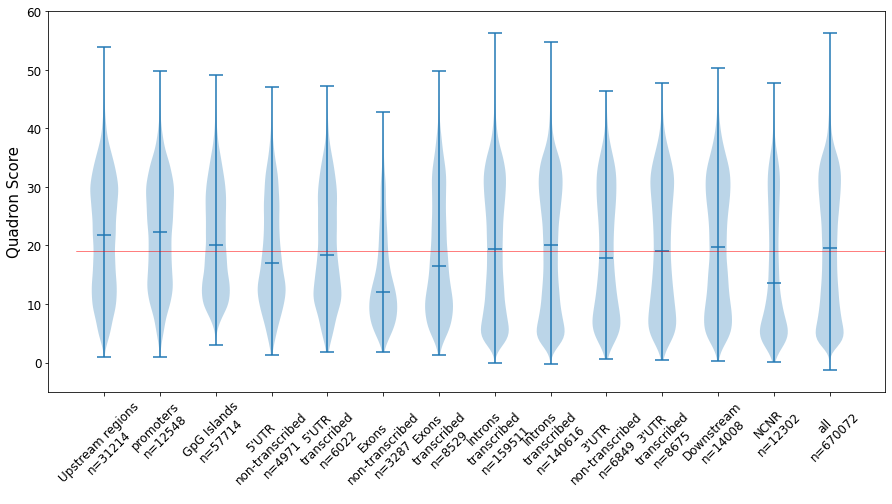

In [37]:
# Help from https://stackoverflow.com/questions/29779079/adding-a-scatter-of-points-to-a-boxplot-using-matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Genic elements (stranded) only



font = {'fontname':'sans'}

toplot = [Upstream, Promoters, CpGI,\
          FUTR_ref, FUTR_rev, Coding_ref, Coding_rev,\
          Introns_ref,Introns_rev,\
          TUTR_ref, TUTR_rev, Downstream, NCNR, ALL]

#toplot_ctrl = [Promoters_ref_ctrl, Upstream_ref_ctrl, FUTR_ref_ctrl, Coding_ref_ctrl, FirstIntrons_ref_ctrl, NotFirstIntrons_ref_ctrl, TUTR_ref_ctrl, Downstream_ref_ctrl]

fig, ax = plt.subplots(figsize=(15, 7))

sizes = []

for array in toplot:
    sizes.append(len(array))
    
maxsize = max(sizes)

ratiosizes = []

for size in sizes:
    #ratiosizes.append(np.log(size/float(maxsize)*100)/2)
    ratiosizes.append(1)

#violin_part1 = ax.violinplot(toplot, showmedians=True, positions=[0,4,8,12,16,20,24,28], widths=ratiosizes)
violin_part1 = ax.violinplot(toplot, showmedians=True, positions=[0,2,4,6,8,10,12,14,16,18,20,22,24,26], widths=ratiosizes)
    
#violin_part2 = ax.violinplot(toplot_ctrl, showmedians=True, positions=[2,6,10,14,18,22,26,30],widths=ratiosizes)
    


ax.plot([-1,28], [19,19], color='red', linewidth=0.5)

ax.set_ylabel('Quadron Score', fontsize=15)
ax.set_ylim(-5,60)
#ax.set_xlim(-1,31)
ax.set_xlim(-2,28)

#xticks = ax.set_xticks([1,5,9,13,17,21,25,29])
xticks = ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26])

       
xticks = ax.set_xticklabels(['Upstream regions\nn='+str(sizes[0]),'promoters\nn='+str(sizes[1]), 'GpG Islands\nn='+str(sizes[2]),\
                             "5'UTR\nnon-transcribed\nn="+str(sizes[3]),"5'UTR\ntranscribed\nn="+str(sizes[4]),\
                             'Exons\nnon-transcribed\nn='+str(sizes[5]),'Exons\ntranscribed\nn='+str(sizes[6]),\
                             'Introns\ntranscribed\nn='+str(sizes[7]),'Introns\ntranscribed\nn='+str(sizes[8]),
                             "3'UTR\nnon-transcribed\nn="+str(sizes[9]),"3'UTR\ntranscribed\nn="+str(sizes[10]),\
                             'Downstream\nn='+str(sizes[11]),'NCNR\nn='+str(sizes[12]),'all\nn='+str(sizes[13])],\
                             rotation=45,  fontsize = 12, **font)

yticks = ax.tick_params(labelsize=12)

#plt.savefig('GenicScores.pdf')

print(max(Upstream))


In [1706]:
import numpy as np
print('Promoters', np.median(Promoters), np.median(Promoters) / np.median(NCNR), permutation_test(Promoters, NCNR, 1000)[1])
print('Upstream', np.median(Upstream), np.median(Upstream) / np.median(NCNR), permutation_test(Upstream, NCNR, 1000)[1])
print('5 UTR sense', np.median(FUTR_ref), np.median(FUTR_ref) / np.median(NCNR), permutation_test(FUTR_ref, NCNR, 1000)[1])
print('5 UTR antisense', np.median(FUTR_rev), np.median(FUTR_rev) / np.median(NCNR), permutation_test(FUTR_rev, NCNR, 1000)[1])
print('Exons sense', np.median(Coding_ref), np.median(Coding_ref) / np.median(NCNR), permutation_test(Coding_ref, NCNR, 1000)[1])
print('Exons antisense', np.median(Coding_rev), np.median(Coding_rev) / np.median(NCNR), permutation_test(Coding_rev, NCNR, 1000)[1])
print('Introns sense', np.median(Introns_ref), np.median(Introns_ref) / np.median(NCNR), permutation_test(Introns_ref, NCNR, 1000)[1])
print('Introns antisense', np.median(Introns_rev), np.median(Introns_rev) / np.median(NCNR), permutation_test(Introns_rev, NCNR, 1000)[1])
print('3 UTR sense', np.median(TUTR_ref), np.median(TUTR_ref) / np.median(NCNR), permutation_test(TUTR_ref, NCNR, 1000)[1])
print('3 UTR antisense', np.median(TUTR_rev), np.median(TUTR_rev) / np.median(NCNR), permutation_test(TUTR_rev, NCNR, 1000)[1])
print('Downstream', np.median(Downstream), np.median(Downstream) / np.median(NCNR), permutation_test(Downstream, NCNR, 1000)[1])
print('CpG islands', np.median(CpGI), np.median(CpGI) / np.median(NCNR), permutation_test(CpGI, NCNR, 1000)[1])


Promoters 22.314999999999998 1.6879727685325263 0.001
Upstream 21.85 1.6527987897125567 0.001
5 UTR sense 17.07 1.2912254160363086 0.001
5 UTR antisense 18.35 1.3880484114977307 0.001
Exons sense 11.97 0.905446293494705 0.001
Exons antisense 16.51 1.2488653555219364 0.001
Introns sense 19.41 1.4682299546142208 0.001
Introns antisense 20.1 1.5204236006051437 0.001
3 UTR sense 17.81 1.347201210287443 0.001
3 UTR antisense 19.11 1.44553706505295 0.001
Downstream 19.75 1.493948562783661 0.001
CpG islands 20.01 1.5136157337367626 0.001


In [1707]:
genic = Upstream+FUTR_ref+FUTR_rev+Coding_ref+Coding_rev+Introns+Introns+TUTR_ref+TUTR_rev+Downstream+CpGI


In [1708]:
print('genic elements', np.median(genic), np.median(genic) / np.median(NCNR), permutation_test(genic, NCNR, 1000)[1])


genic elements 19.67 1.4878971255673223 0.001


In [1709]:
import numpy as np
print('Promoters', np.median(Promoters), np.median(Promoters) / np.median(ALL), permutation_test(Promoters, ALL, 1000)[1])
print('Upstream', np.median(Upstream), np.median(Upstream) / np.median(ALL), permutation_test(Upstream, ALL, 1000)[1])
print('5 UTR sense', np.median(FUTR_ref), np.median(FUTR_ref) / np.median(ALL), permutation_test(FUTR_ref, ALL, 1000)[1])
print('5 UTR antisense', np.median(FUTR_rev), np.median(FUTR_rev) / np.median(ALL), permutation_test(FUTR_rev, ALL, 1000)[1])
print('Exons sense', np.median(Coding_ref), np.median(Coding_ref) / np.median(ALL), permutation_test(Coding_ref, ALL, 1000)[1])
print('Exons antisense', np.median(Coding_rev), np.median(Coding_rev) / np.median(ALL), permutation_test(Coding_rev, ALL, 1000)[1])
print('Introns sense', np.median(Introns_ref), np.median(Introns_ref) / np.median(NCNR), permutation_test(Introns_ref, NCNR, 1000)[1])
print('Introns antisense', np.median(Introns_rev), np.median(Introns_rev) / np.median(NCNR), permutation_test(Introns_rev, NCNR, 1000)[1])
print('3 UTR sense', np.median(TUTR_ref), np.median(TUTR_ref) / np.median(ALL), permutation_test(TUTR_ref, ALL, 1000)[1])
print('3 UTR antisense', np.median(TUTR_rev), np.median(TUTR_rev) / np.median(ALL), permutation_test(TUTR_rev, ALL, 1000)[1])
print('Downstream', np.median(Downstream), np.median(Downstream) / np.median(ALL), permutation_test(Downstream, ALL, 1000)[1])
print('CpG islands', np.median(CpGI), np.median(CpGI) / np.median(ALL), permutation_test(CpGI, ALL, 1000)[1])
print('genic elements', np.median(genic), np.median(genic) / np.median(ALL), permutation_test(genic, ALL, 1000)[1])



Promoters 22.314999999999998 1.1420163766632547 0.001
Upstream 21.85 1.118219037871034 0.001
5 UTR sense 17.07 0.8735926305015353 0.001
5 UTR antisense 18.35 0.9390992835209827 0.001
Exons sense 11.97 0.6125895598771751 0.001
Exons antisense 16.51 0.8449334698055272 0.001
Introns sense 19.41 1.4682299546142208 0.001
Introns antisense 20.1 1.5204236006051437 0.001
3 UTR sense 17.81 0.9114636642784032 0.001
3 UTR antisense 19.11 0.9779938587512794 0.101
Downstream 19.75 1.010747185261003 0.314
CpG islands 20.01 1.0240532241555784 0.001
genic elements 19.67 1.0066530194472878 0.002


In [1721]:
print('5 UTR sense', np.median(FUTR_ref), np.median(FUTR_ref) / np.median(FUTR_rev), permutation_test(FUTR_ref, FUTR_rev, 1000)[1])
print('Exons sense', np.median(Coding_ref), np.median(Coding_ref) / np.median(Coding_rev), permutation_test(Coding_ref, Coding_rev, 1000)[1])
print('Introns sense', np.median(Introns_ref), np.median(Introns_ref) / np.median(Introns_rev), permutation_test(Introns_ref, Introns_rev, 1000)[1])
print('3 UTR sense', np.median(TUTR_ref), np.median(TUTR_ref) / np.median(TUTR_rev), permutation_test(TUTR_ref, TUTR_rev, 1000)[1])


5 UTR sense 17.07 0.9302452316076294 0.001
Exons sense 11.97 0.7250151423379769 0.001
Introns sense 19.41 0.9656716417910447 0.001
3 UTR sense 17.81 0.9319727891156462 0.001


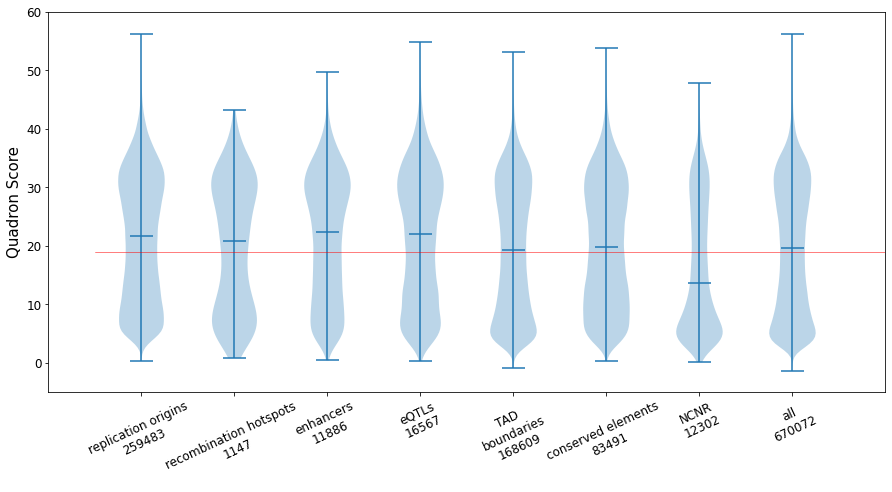

In [2014]:
# Help from https://stackoverflow.com/questions/29779079/adding-a-scatter-of-points-to-a-boxplot-using-matplotlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

font = {'fontname':'Sans'}

toplot = [RepOrigin, RecombHotspots, Enhancers, eQTL, TADB, PhastCons, NCNR, ALL]
#toplot_ctrl = [RepOrigin_ctrl, eQTL_ctrl, Repetitive_ctrl, Enhancers_ctrl, PhastCons_ctrl, CTCF_ctrl]


fig, ax = plt.subplots(figsize=(15, 7))

sizes = []

for array in toplot:
    sizes.append(len(array))
    
maxsize = max(sizes)

ratiosizes = []

for size in sizes:
    #ratiosizes.append(np.log(size/float(maxsize)*100)/2)
    ratiosizes.append(1)
    
violin_part1 = ax.violinplot(toplot, showmedians=True, positions=[0,2,4,6,8,10,12,14], widths=ratiosizes)

#violin_part2 = ax.violinplot(toplot_ctrl, showmedians=True, positions=[2,6,10,14,18,22],widths=ratiosizes)


ax.plot([-1,16], [19,19], color='red', linewidth=0.5)

ax.set_ylabel('Quadron Score', fontsize=15, **font)
ax.set_ylim(-5,60)
ax.set_xlim(-2,16)

xticks = ax.set_xticks([0,2,4,6,8,10,12,14])
    
xticks = ax.set_xticklabels(['replication origins\n'+str(sizes[0]),'recombination hotspots\n'+str(sizes[1]),\
                             'enhancers\n'+str(sizes[2]),'eQTLs\n'+str(sizes[3]),\
                             'TAD\nboundaries\n'+str(sizes[4]),'conserved elements\n'+str(sizes[5]),
                             'NCNR\n'+str(sizes[6]),'all\n'+str(sizes[7])],rotation=25,  fontsize = 14, **font)

                            

yticks = ax.tick_params(labelsize=12)

#testlegend = mpatches.Patch(color='steelblue', label='Test')
#ctrllegend = mpatches.Patch(color='orange', label='Control')

#ax.legend(handles=[testlegend,ctrllegend],bbox_to_anchor=(1, 1))

#ax.axvline(x=3, color='black')
#ax.axvline(x=7, color='black')
#ax.axvline(x=11, color='black')
#ax.axvline(x=15, color='black')
#ax.axvline(x=19, color='black')
#ax.axvline(x=23, color='black')


In [1711]:
import numpy as np
print('Rep Oris', np.median(RepOrigin), np.median(RepOrigin) / np.median(NCNR), permutation_test(RepOrigin, NCNR, 1000)[1])
print('eQTLs', np.median(eQTL), np.median(eQTL) / np.median(NCNR), permutation_test(eQTL, NCNR, 1000)[1])
print('Enhancers', np.median(Enhancers), np.median(Enhancers) / np.median(NCNR), permutation_test(Enhancers, NCNR, 1000)[1])
print('PhastCons', np.median(PhastCons), np.median(PhastCons) / np.median(NCNR), permutation_test(PhastCons, NCNR, 1000)[1])
print('TADB', np.median(TADB), np.median(TADB) / np.median(NCNR), permutation_test(TADB, NCNR, 1000)[1])
print('RecombHotspots', np.median(RecombHotspots), np.median(RecombHotspots) / np.median(NCNR), permutation_test(RecombHotspots, NCNR, 1000)[1])




Rep Oris 21.61 1.63464447806354 0.001
eQTLs 21.95 1.6603630862329801 0.001
Enhancers 22.365000000000002 1.6917549167927384 0.001
PhastCons 19.8 1.497730711043873 0.001
TADB 19.25 1.4561270801815431 0.001
RecombHotspots 17.805 1.346822995461422 0.044


In [1712]:
import numpy as np
print('Rep Oris', np.median(RepOrigin), np.median(RepOrigin) / np.median(ALL), permutation_test(RepOrigin, ALL, 1000)[1])
print('eQTLs', np.median(eQTL), np.median(eQTL) / np.median(ALL), permutation_test(eQTL, ALL, 1000)[1])
print('Enhancers', np.median(Enhancers), np.median(Enhancers) / np.median(ALL), permutation_test(Enhancers, ALL, 1000)[1])
print('PhastCons', np.median(PhastCons), np.median(PhastCons) / np.median(ALL), permutation_test(PhastCons, ALL, 1000)[1])
print('TADB', np.median(TADB), np.median(TADB) / np.median(ALL), permutation_test(TADB, ALL, 1000)[1])
print('RecombHotspots', np.median(RecombHotspots), np.median(RecombHotspots) / np.median(ALL), permutation_test(RecombHotspots, ALL, 1000)[1])




Rep Oris 21.61 1.1059365404298875 0.001
eQTLs 21.95 1.1233367451381782 0.001
Enhancers 22.365000000000002 1.1445752302968273 0.001
PhastCons 19.8 1.0133060388945754 0.004
TADB 19.25 0.9851586489252815 0.001
RecombHotspots 17.805 0.9112077789150461 0.507


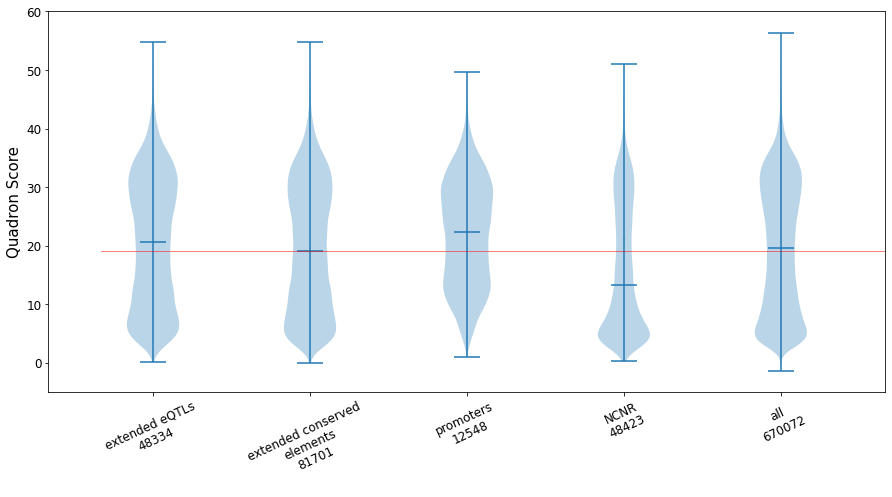

In [1719]:
# Help from https://stackoverflow.com/questions/29779079/adding-a-scatter-of-points-to-a-boxplot-using-matplotlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

font = {'fontname':'Sans'}

toplot = [eQTL_extended, PhastCons_extended, Promoters, NCNR, ALL]
#toplot_ctrl = [RepOrigin_ctrl, eQTL_ctrl, Repetitive_ctrl, Enhancers_ctrl, PhastCons_ctrl, CTCF_ctrl]


fig, ax = plt.subplots(figsize=(15, 7))

sizes = []

for array in toplot:
    sizes.append(len(array))
    
maxsize = max(sizes)

ratiosizes = []

for size in sizes:
    #ratiosizes.append(np.log(size/float(maxsize)*100)/2)
    ratiosizes.append(1)
    
violin_part1 = ax.violinplot(toplot, showmedians=True, positions=[0,3,6,9,12], widths=ratiosizes)

#violin_part2 = ax.violinplot(toplot_ctrl, showmedians=True, positions=[2,6,10,14,18,22],widths=ratiosizes)


ax.plot([-1,23], [19,19], color='red', linewidth=0.5)

ax.set_ylabel('Quadron Score', fontsize=15, **font)
ax.set_ylim(-5,60)
ax.set_xlim(-2,14)

xticks = ax.set_xticks([0,3,6,9,12])
    
xticks = ax.set_xticklabels(['extended eQTLs\n'+str(sizes[0]),'extended conserved\nelements\n'+str(sizes[1]),\
                             'promoters\n'+str(sizes[2]),'NCNR\n'+str(sizes[3]),\
                             'all\n'+str(sizes[4])],rotation=25,  fontsize = 14, **font)

                            

yticks = ax.tick_params(labelsize=12)

#testlegend = mpatches.Patch(color='steelblue', label='Test')
#ctrllegend = mpatches.Patch(color='orange', label='Control')

#ax.legend(handles=[testlegend,ctrllegend],bbox_to_anchor=(1, 1))

#ax.axvline(x=3, color='black')
#ax.axvline(x=7, color='black')
#ax.axvline(x=11, color='black')
#ax.axvline(x=15, color='black')
#ax.axvline(x=19, color='black')
#ax.axvline(x=23, color='black')


In [1720]:
import numpy as np
print('extended eQTLs', np.median(eQTL_extended), np.median(eQTL_extended) / np.median(NCNR), permutation_test(eQTL_extended, NCNR, 1000)[1])
print('extended PhastCons', np.median(PhastCons_extended), np.median(PhastCons_extended) / np.median(NCNR), permutation_test(PhastCons_extended, NCNR, 1000)[1])

print('extended eQTLs', np.median(eQTL_extended), np.median(eQTL_extended) / np.median(ALL), permutation_test(eQTL_extended, ALL, 1000)[1])
print('extended PhastCons', np.median(PhastCons_extended), np.median(PhastCons_extended) / np.median(ALL), permutation_test(PhastCons_extended, ALL, 1000)[1])




extended eQTLs 20.55 1.55446293494705 0.001
extended PhastCons 19.12 1.4462934947049924 0.001
extended eQTLs 20.55 1.0516888433981577 0.001
extended PhastCons 19.12 0.9785056294779939 0.001


In [2084]:
print(np.median(NCNR))
print(np.median(ALL))

13.59
19.54


Note: Rep Origins, eQTLs, and Repetitive may significantly overlap with other elements and contribute to their patterns.

In [8]:
%%R -i Upstream,Promoters,CpGI,FUTR_ref,FUTR_rev,Coding_ref,Coding_rev,Introns_ref,Introns_rev,TUTR_ref,TUTR_rev,Downstream,NCNR,ALL,Enhancers,eQTL,RecombHotspots,RepOrigin,TADB
print('Hi')

[1] "Hi"


In [9]:
%%R
Enhancers <- as.numeric(unlist(Enhancers))
eQTL <- as.numeric(unlist(eQTL))
RecombHotspots <- as.numeric(unlist(RecombHotspots))
RepOrigin <- as.numeric(unlist(RepOrigin))
TADB <- as.numeric(unlist(TADB))
Upstream <- as.numeric(unlist(Upstream))
Promoters <- as.numeric(unlist(Promoters))
CpGI <- as.numeric(unlist(CpGI))
FUTR_ref <- as.numeric(unlist(FUTR_ref))
FUTR_rev <- as.numeric(unlist(FUTR_rev))
Coding_ref <- as.numeric(unlist(Coding_ref))
Coding_rev <- as.numeric(unlist(Coding_rev))
Introns_ref <- as.numeric(unlist(Introns_ref))
Introns_rev <- as.numeric(unlist(Introns_rev))
TUTR_ref <- as.numeric(unlist(TUTR_ref))
TUTR_rev <- as.numeric(unlist(TUTR_rev))
Downstream <- as.numeric(unlist(Downstream))
NCNR <- as.numeric(unlist(NCNR))
ALL <- as.numeric(unlist(ALL))

In [10]:
%%R 

toplot1 <- cbind.data.frame(c(Upstream,Promoters,CpGI,FUTR_ref,FUTR_rev,
                             Coding_ref,Coding_rev,Introns_ref,Introns_rev,
                             TUTR_ref,TUTR_rev,Downstream,NCNR,ALL),
                           c(rep("upstream regions", length(Upstream)),
                            rep("validated promoters", length(Promoters)),
                            rep("CpG islands", length(CpGI)),
                            rep("5' UTRs non-transcribed", length(FUTR_ref)),
                            rep("5' UTRs transcribed", length(FUTR_rev)),
                            rep("exons non-transcribed", length(Coding_ref)),
                            rep("exons transcribed", length(Coding_rev)),
                            rep("introns non-transcribed", length(Introns_ref)),
                            rep("introns transcribed", length(Introns_rev
)),
                            rep("3' UTRs non-transcribed", length(TUTR_ref)),
                            rep("3' UTRs transcribed", length(TUTR_rev)),
                            rep("downstream regions", length(Downstream)),
                            rep("NCNR", length(NCNR)),
                            rep("genome-wide", length(ALL))
                            ))

colnames(toplot1) <- c('score', 'element')




In [13]:
%%R

toplot2 <- cbind.data.frame(c(Enhancers,eQTL,RecombHotspots,RepOrigin,TADB,NCNR,ALL),
                           c(rep("enhancers", length(Enhancers)),
                            rep("eQTLs", length(eQTL)),
                            rep("recombination hotspots", length(RecombHotspots)),
                            rep("replication origins", length(RepOrigin)),
                            rep("TAD boundary regions", length(TADB)),
                            rep("NCNR", length(NCNR)),
                            rep("genome-wide", length(ALL))
                            ))

colnames(toplot2) <- c('score', 'element')

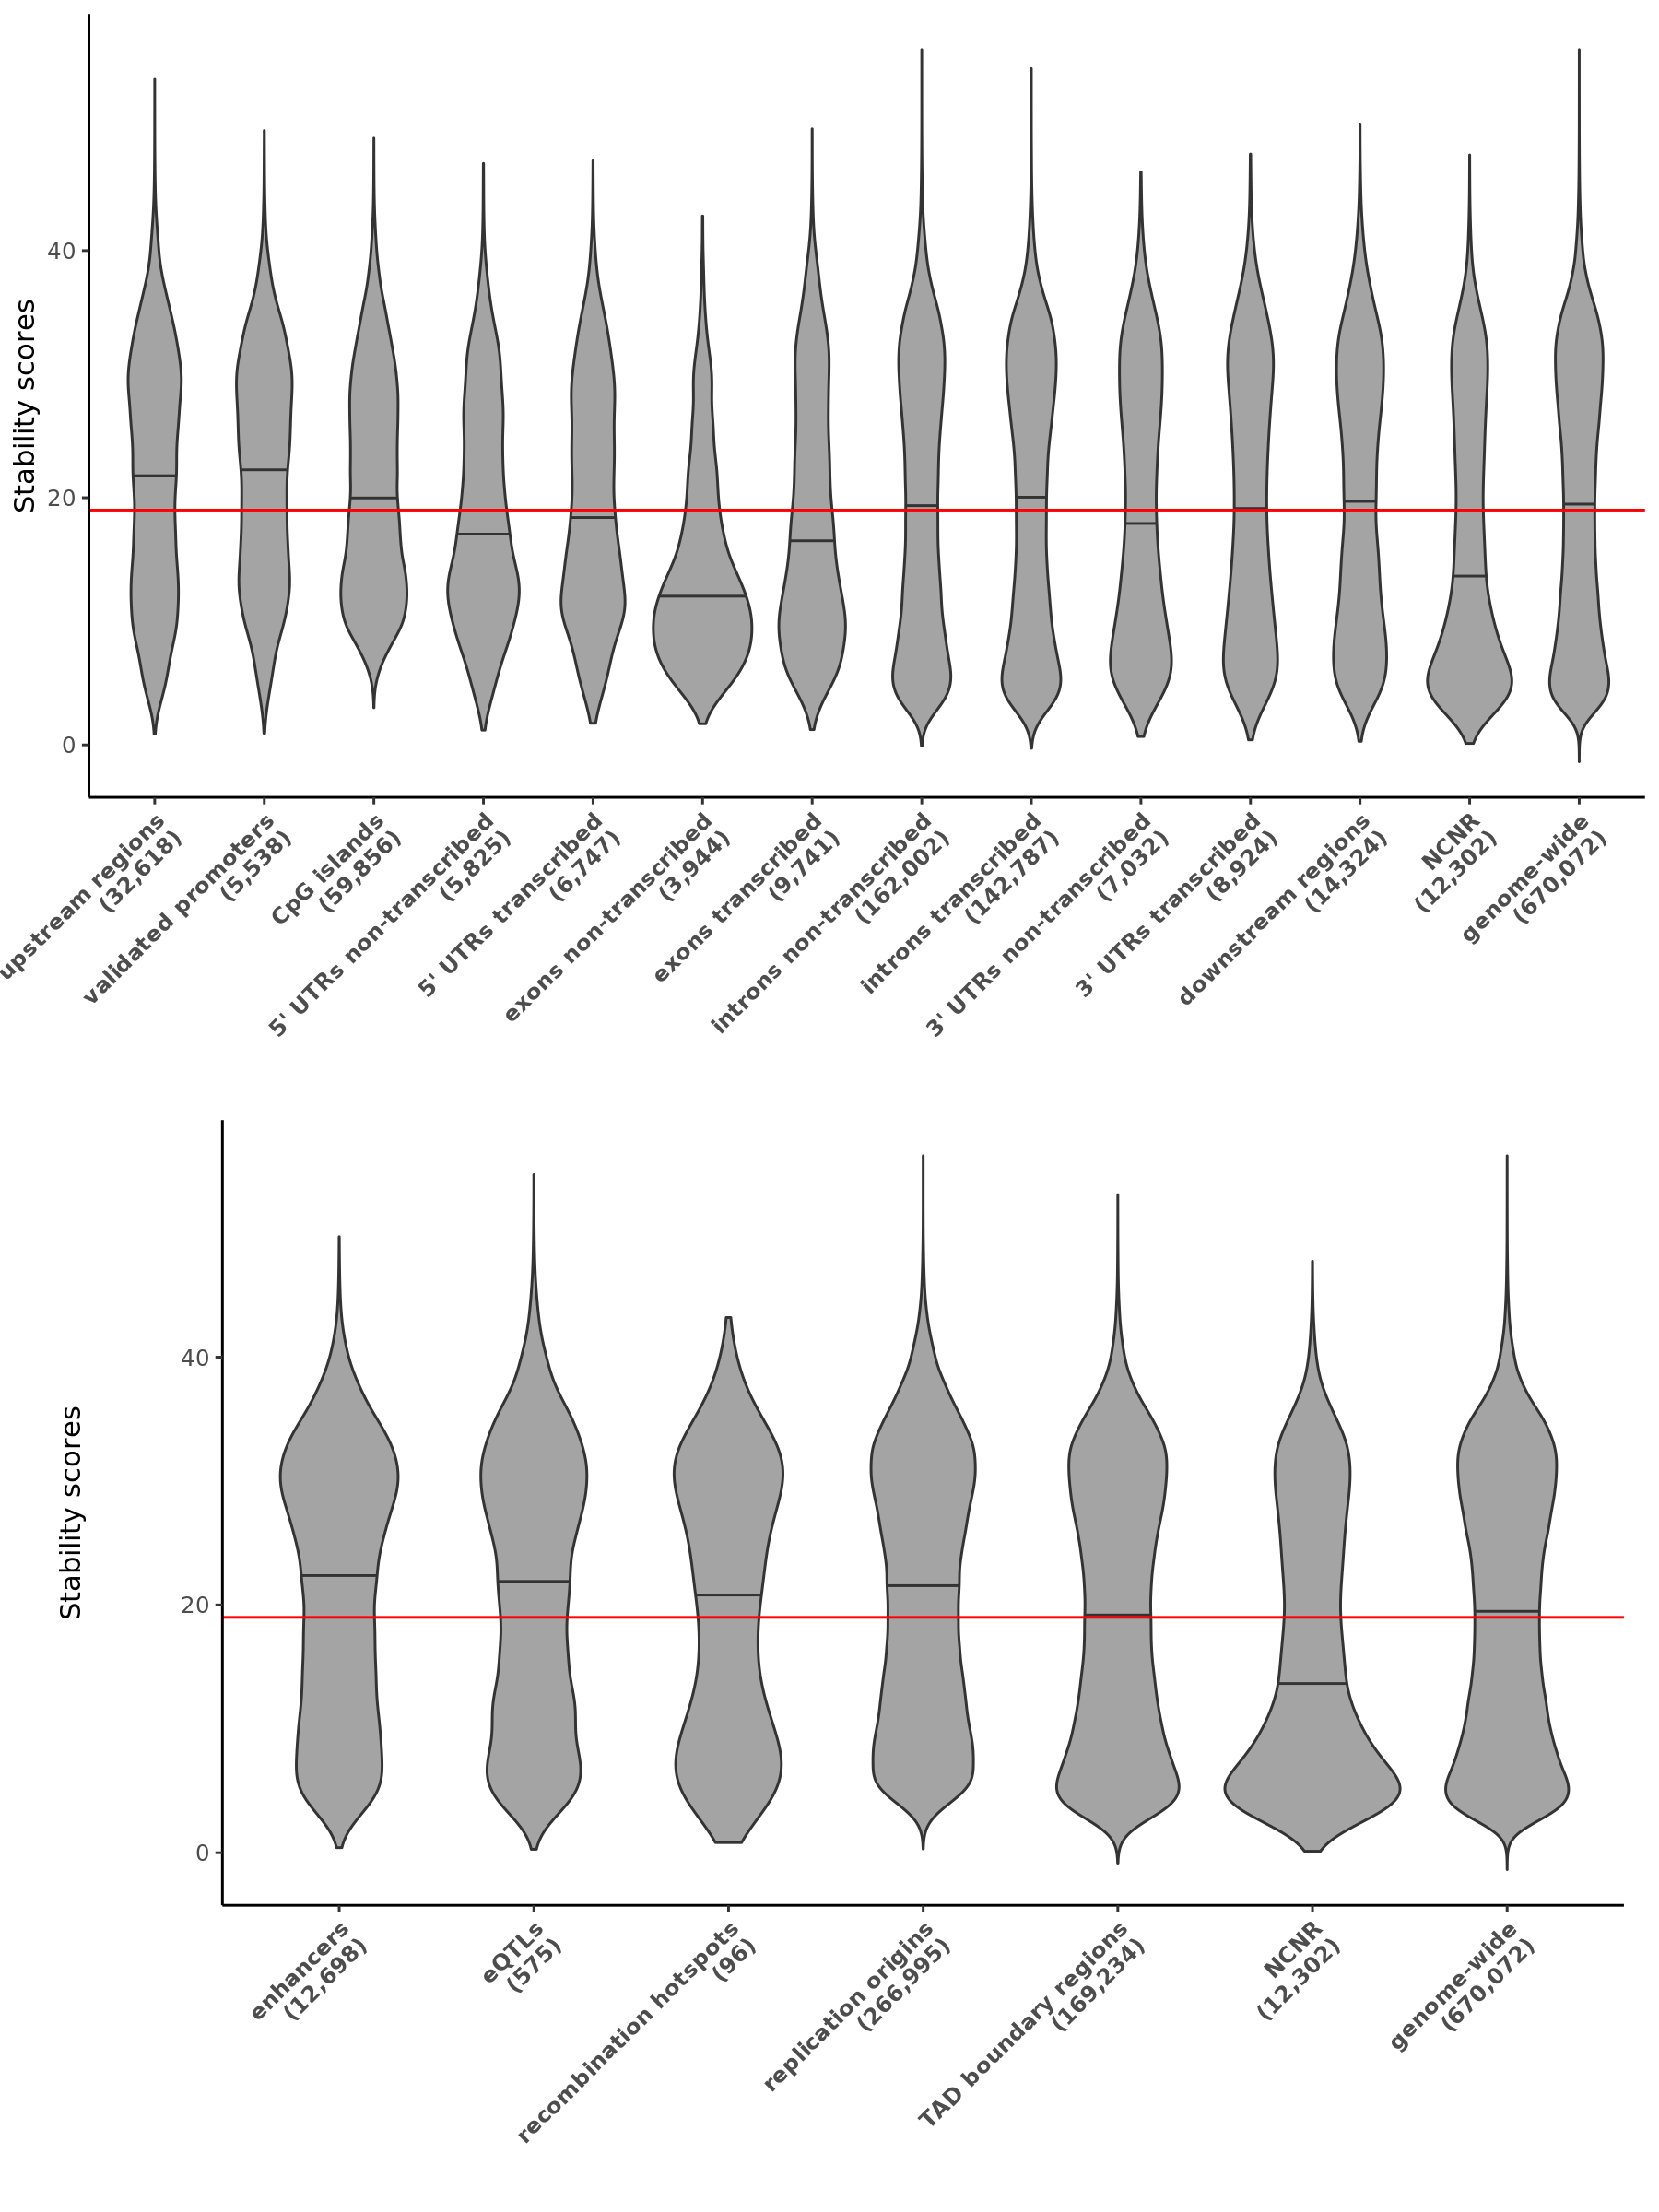

In [53]:
%%R -w 9 -h 12 --units in -r 200
library(ggplot2)
library(grid)
library(gridExtra)

g1<-  ggplot(toplot1, aes(x=element, y=score)) + geom_violin(draw_quantiles=c(0.5),fill='#A4A4A4') + 
    scale_x_discrete(limits = c("upstream regions", "validated promoters","CpG islands",
                                "5' UTRs non-transcribed", "5' UTRs transcribed","exons non-transcribed",
                                "exons transcribed","introns non-transcribed","introns transcribed",
                                "3' UTRs non-transcribed","3' UTRs transcribed","downstream regions",
                                "NCNR","genome-wide"),
                    labels = c("upstream regions\n(32,618)", "validated promoters\n(5,538)","CpG islands\n(59,856)",
                                "5' UTRs non-transcribed\n(5,825)", "5' UTRs transcribed\n(6,747)","exons non-transcribed\n(3,944)",
                                "exons transcribed\n(9,741)","introns non-transcribed\n(162,002)","introns transcribed\n(142,787)",
                                "3' UTRs non-transcribed\n(7,032)","3' UTRs transcribed\n(8,924)","downstream regions\n(14,324)",
                                "NCNR\n(12,302)","genome-wide\n(670,072)")) +
    geom_hline(yintercept=19, color="red", size=0.5) +
    theme_classic() +
    theme(axis.text.x=element_text(angle = 45, hjust = 1, family="sans", face="bold")) +
    labs(y="Stability scores", x="")


g2<-  ggplot(toplot2, aes(x=element, y=score)) + geom_violin(draw_quantiles=c(0.5),fill='#A4A4A4') + 
    scale_x_discrete(limits = c("enhancers","eQTLs","recombination hotspots","replication origins",
                                "TAD boundary regions","NCNR","genome-wide"),
                    labels = c("enhancers\n(12,698)","eQTLs\n(575)","recombination hotspots\n(96)",
                               "replication origins\n(266,995)","TAD boundary regions\n(169,234)",
                                "NCNR\n(12,302)","genome-wide\n(670,072)")) +
    geom_hline(yintercept=19, color="red", size=0.5) +
    theme_classic() +
    theme(axis.text.x=element_text(angle = 45, hjust = 1, family="sans", face="bold")) +
    labs(y="Stability scores", x="")
    


# Get the gtables
gA <- ggplotGrob(g1)
gB <- ggplotGrob(g2)

# Set the widths
gA$widths <- gA$widths * 1
gB$widths <- gB$widths * 2.5

# Arrange the two charts.
# The legend boxes are centered
#grid.newpage()
grid.arrange(gA, gB, nrow = 2)
g <- arrangeGrob(gA, gB, nrow = 2)
ggsave(file='G4scores.pdf',g, width=8, height=8, dpi=300)




## 7. Permutations test

In [239]:
from numpy.random import permutation
import numpy as np

def permutation_test(TestDist, ControlDist, permutations):

    mean = np.mean(TestDist)
    median = np.median(TestDist)
    
    deltamean = abs(np.mean(TestDist) - np.mean(ControlDist))
    deltamedian = abs(np.median(TestDist) - np.median(ControlDist))
    
    Pool = ControlDist + TestDist

    mockdeltameans = []
    mockdeltamedians = []
    i = 1

    while i < permutations:
        PermutedPool = np.random.permutation(Pool)
        MockTest = PermutedPool[:len(TestDist)]
        MockControl = PermutedPool[len(TestDist):]
        mockdeltamean = abs(np.mean(MockTest) - np.mean(MockControl))
        mockdeltameans.append(mockdeltamean)
        mockdeltamedian = abs(np.median(MockTest) - np.median(MockControl))
        mockdeltamedians.append(mockdeltamedian)
        i += 1
    
    deltameans = mockdeltameans + [deltamean]
    #print(len(deltameans))
    deltamedians = mockdeltamedians + [deltamedian]
    meanpvalue = sum(i >= deltamean for i in deltameans) / float(permutations)# + 1)
    medianpvalue = sum(i >= deltamedian for i in deltamedians) / float(permutations)# + 1)
    
    return meanpvalue, medianpvalue


In [54]:
print('Upstream', permutation_test(Upstream, NCNR, 1000))
print("5'UTR", permutation_test(FUTR, NCNR, 1000))
print('Exon', permutation_test(Coding, NCNR, 1000))
print('Introns', permutation_test(Introns, NCNR, 1000))
print('TUTR', permutation_test(TUTR, NCNR, 1000))
print('Downstream', permutation_test(Downstream, NCNR, 1000))
print('RM no Inter', permutation_test(RM, NCNR, 1000))
print('Interspersed', permutation_test(Interspersed, NCNR, 1000))
print('Rep Origin', permutation_test(RepOrigin, NCNR, 1000))
print('eQTLs', permutation_test(eQTL, NCNR, 1000))
print('Repetitive', permutation_test(Repetitive, NCNR, 1000))

Upstream (21.589113101555824, 0.001, 21.87, 0.001)
5'UTR (19.6550506585613, 0.001, 18.68, 0.001)
Exon (17.485292676134783, 0.001, 15.33, 0.001)
Introns (19.68801587277737, 0.001, 19.68, 0.001)
TUTR (19.284479581390055, 0.001, 18.57, 0.001)
Downstream (20.020513151942094, 0.001, 19.82, 0.001)
RM no Inter (21.102819265827875, 0.001, 22.96, 0.001)
Interspersed (19.27897416893846, 0.001, 19.955, 0.001)
Rep Origin (20.5861494323932, 0.001, 20.39, 0.001)
eQTLs (21.25073385636693, 0.001, 21.96, 0.001)
Repetitive (19.27897416893846, 0.001, 19.955, 0.001)


In [2104]:
print('NCNR', permutation_test(NCNR, NCNR, 1000))

NCNR (1.0, 1.0)


## G4 intersections

In [377]:
%load_ext rpy2.ipython
# Activates R cell magic

/home/wilfried/conda/wil_works/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [427]:
%%R
library(ggplot2)
library(grid)
library(gridExtra)

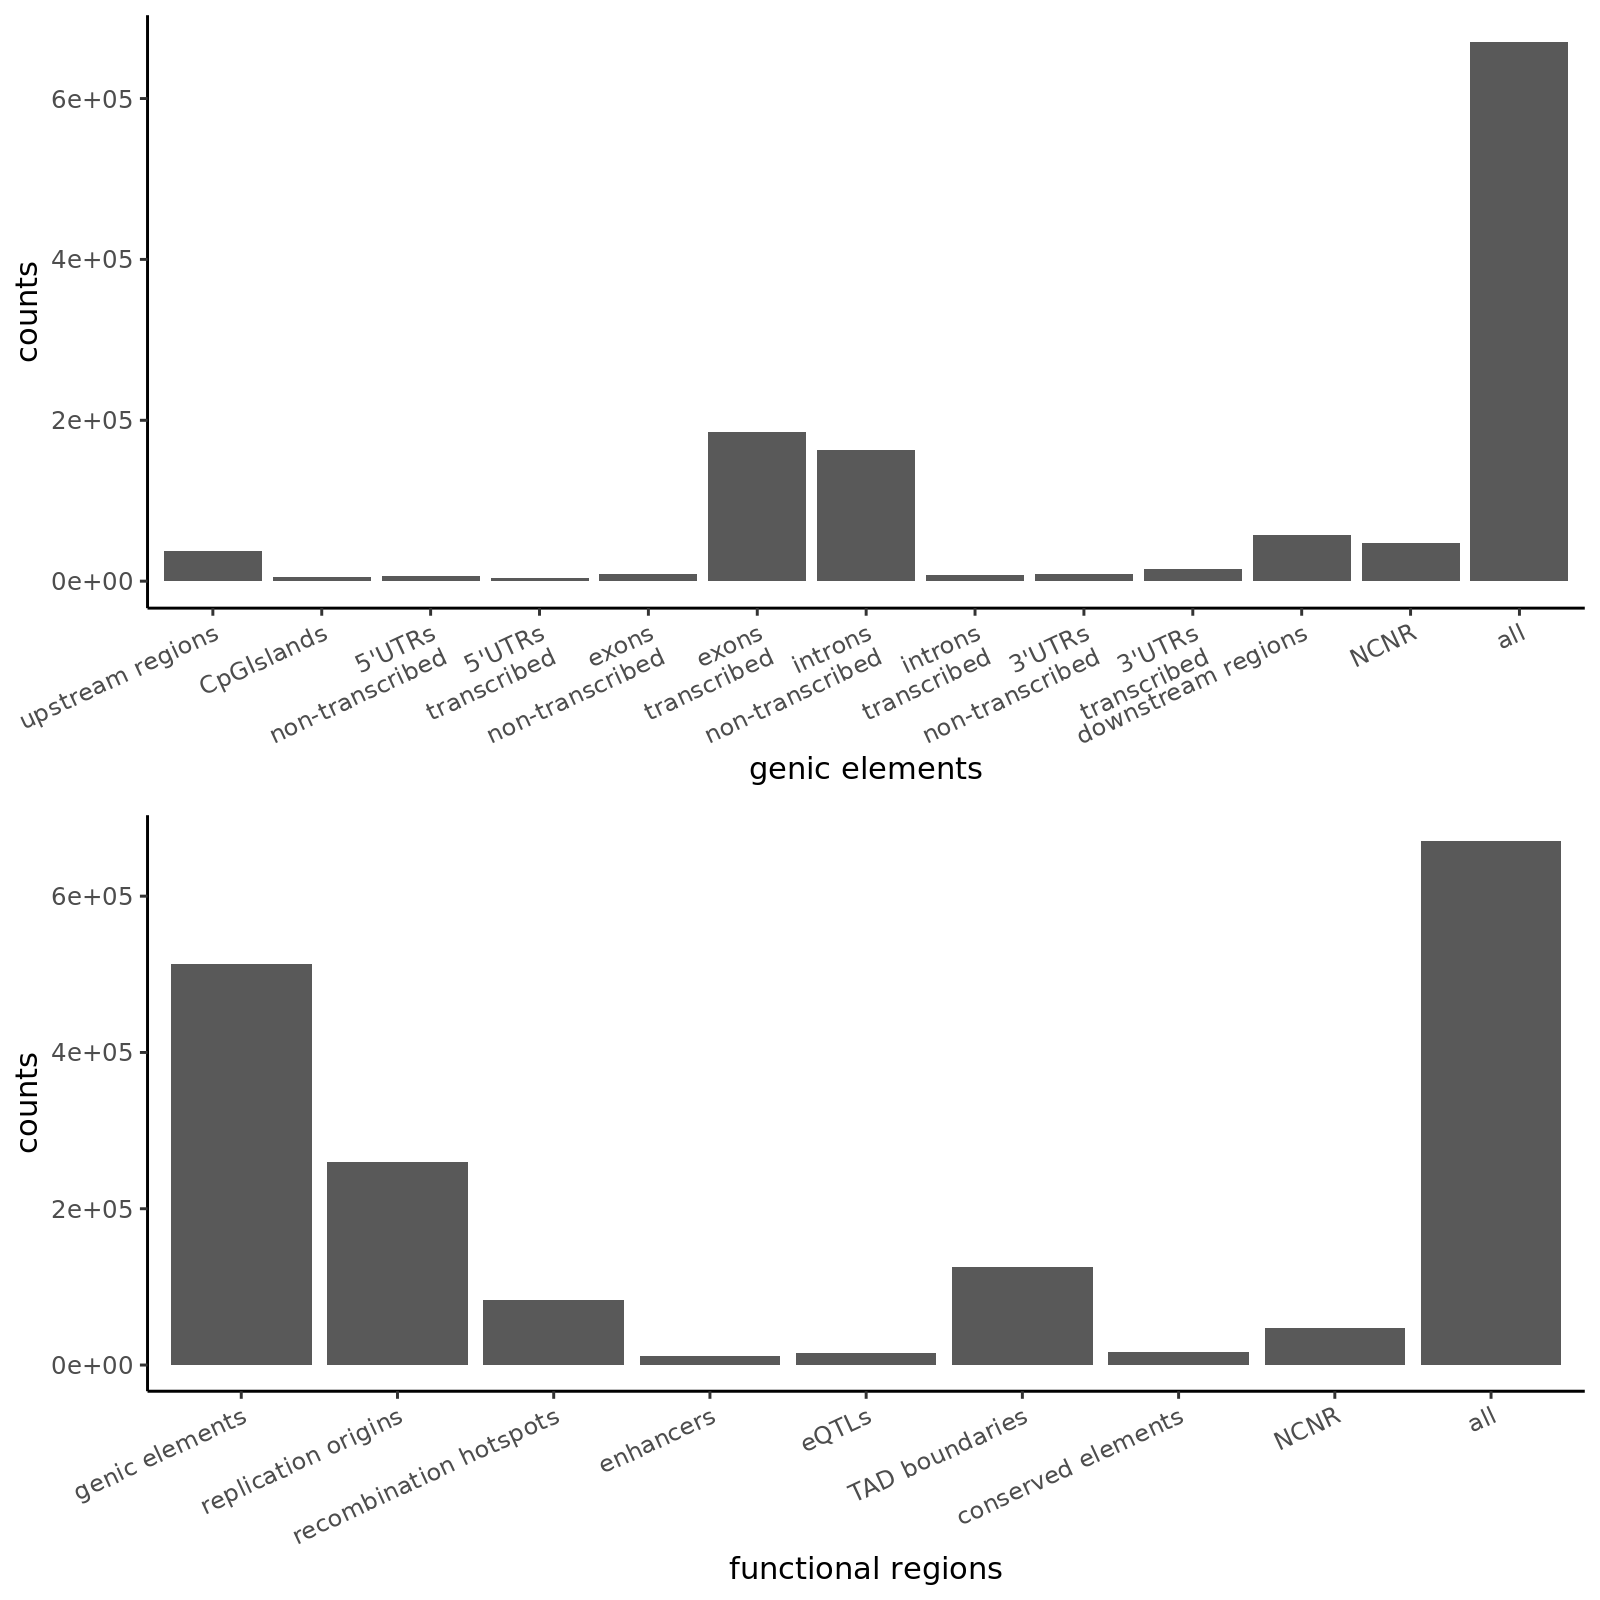

In [646]:
%%R -w 8 -h 8 --units in -r 200


df <- data.frame(
  group = c("genic elements", "replication origins", "eQTLs", "enhancers","conserved elements","TAD boundaries", "recombination hotspots", "NCNR","all"),
  value = c(513261,259487,15852, 11886,16570,126021,83491,47124, 670075 )
  )

df_genic <- data.frame(
  group = c("upstream regions",  "CpGIslands",  "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed", "exons\nnon-transcribed", "exons\ntranscribed",  "introns\nnon-transcribed", "introns\ntranscribed", "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed", "downstream regions",  "NCNR",                "all"),
  value = c(37778,              5582,                  6580,               3397,                 8729,              185098,                  163681,              7309,                  9318,              15265,               57714,      47124, 670075)
  )

#print(head(head(df)))

bar <- ggplot(df, aes(group,value)) + geom_bar(stat = "identity") + 
        theme_classic() +
        theme(axis.text.x=element_text(angle = 25, hjust = 1, family="sans"),
              axis.title.x = element_text(family="sans"),
              axis.text.y = element_text(family="sans"),
              axis.title.y = element_text(family="sans")) +
        labs(y="counts", x="functional regions") +
        scale_x_discrete(limits = c("genic elements", "replication origins","recombination hotspots","enhancers", "eQTLs","TAD boundaries",  "conserved elements","NCNR","all"))


bar2 <- ggplot(df_genic, aes(group,value)) + geom_bar(stat = "identity") +
        theme_classic() +
        theme(axis.text.x=element_text(angle = 25, hjust = 1, family="sans"),
              axis.title.x = element_text(family="sans"),
              axis.text.y = element_text(family="sans"),
              axis.title.y = element_text(family="sans")) +
        labs(y="counts", x="genic elements") +
        scale_x_discrete(limits = c("upstream regions",  "CpGIslands",  "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed", "exons\nnon-transcribed", "exons\ntranscribed",  "introns\nnon-transcribed", "introns\ntranscribed", "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed", "downstream regions",  "NCNR",                "all"))


grid.arrange(bar2, bar, nrow = 2)

g <- arrangeGrob(bar2, bar, nrow = 2)
ggsave(file='G4counts.pdf',g, width=8, height=8, dpi=300)


In [48]:
import random

import sys

def Gcounter(infile):
    #print(infile)
    openfile = open(infile, 'r+')
    Gcontent = 0


    for line in openfile:
        if line[0] != '>':
            G = line.count('G') + line.count('g')
            Gcontent += G


    return(Gcontent)

def Ccounter(infile):
    #print(infile)
    openfile = open(infile, 'r+')
    Ccontent = 0


    for line in openfile:
        if line[0] != '>':
            C = line.count('C') + line.count('c')
            Ccontent += C


    return(Ccontent)

def coverage_parser(file1,correcter):
    print(file1)
    covered = 0
    total = 0
    #distrib = []
    for line in open(file1,'rt'):
        #print(line)
        array = line.strip().split('\t')
        #print(array)
        total += int(array[2])-int(array[1])
        covered += (int(array[2])-int(array[1])) * float(array[3])
        #distrib.append(float(array[3]))

    #print(" Total coverage = "+str(float(covered)/total))
    #print(" Total coverage / G-content = "+str(float(covered)/correcter))
    #print(" Total coverage / G-content %*10 = "+str(float(covered)/total/correcter*1000))
    corrected_cov = float(covered)/correcter
    return([covered,total,correcter,corrected_cov])




In [20]:
Upstream_ref_cov,Upstream_ref_total,Upstream_ref_Gcontent,Upstream_ref_correctedcov = coverage_parser("Upstream1k+.G4coverage",Gcounter("Upstream1k.getfa"))
Upstream_rev_cov,Upstream_rev_total,Upstream_rev_Gcontent,Upstream_rev_correctedcov = coverage_parser("Upstream1k-.G4coverage",Ccounter("Upstream1k.getfa"))

print(Upstream_ref_cov,Upstream_ref_total,Upstream_ref_Gcontent,Upstream_ref_correctedcov)
print(Upstream_rev_cov,Upstream_rev_total,Upstream_rev_Gcontent,Upstream_rev_correctedcov)

Upstream_cov_bp = (Upstream_ref_cov + Upstream_rev_cov) / (Upstream_ref_total + Upstream_rev_total)
Upstream_correctedcov = (Upstream_ref_cov + Upstream_rev_cov) / (Upstream_rev_Gcontent+Upstream_ref_Gcontent)

print(Upstream_cov_bp,Upstream_correctedcov)

Upstream_cov = Upstream_ref_cov + Upstream_rev_cov
Upstream_total = Upstream_ref_total + Upstream_rev_total 
Upstream_Gcontent = Upstream_ref_Gcontent + Upstream_rev_Gcontent

print(Upstream_cov)
print(Upstream_total)
print(Upstream_Gcontent)


Upstream1k+.G4coverage
Upstream1k-.G4coverage
646786.0 28185000 7174669 0.09014854901320186
652806.0 28185000 7161045 0.09116071746511857
0.023054674472237007 0.09065415228010269
1299592.0
56370000
14335714


In [21]:
FUTR_sense_ref_cov,FUTR_sense_ref_total,FUTR_sense_ref_Gcontent,FUTR_sense_ref_correctedcov = coverage_parser("FUTR++.G4coverage",Gcounter("FUTR+.getfa"))
FUTR_sense_rev_cov,FUTR_sense_rev_total,FUTR_sense_rev_Gcontent,FUTR_sense_rev_correctedcov = coverage_parser("FUTR--.G4coverage",Ccounter("FUTR-.getfa"))

print(FUTR_sense_ref_cov,FUTR_sense_ref_total,FUTR_sense_ref_Gcontent,FUTR_sense_ref_correctedcov)
print(FUTR_sense_rev_cov,FUTR_sense_rev_total,FUTR_sense_rev_Gcontent,FUTR_sense_rev_correctedcov)

FUTR_antisense_ref_cov,FUTR_antisense_ref_total,FUTR_antisense_ref_Gcontent,FUTR_antisense_ref_correctedcov = coverage_parser("FUTR-+.G4coverage",Gcounter("FUTR-.getfa"))
FUTR_antisense_rev_cov,FUTR_antisense_rev_total,FUTR_antisense_rev_Gcontent,FUTR_antisense_rev_correctedcov = coverage_parser("FUTR+-.G4coverage",Ccounter("FUTR+.getfa"))

print(FUTR_antisense_ref_cov,FUTR_antisense_ref_total,FUTR_antisense_ref_Gcontent,FUTR_antisense_ref_correctedcov)
print(FUTR_antisense_rev_cov,FUTR_antisense_rev_total,FUTR_antisense_rev_Gcontent,FUTR_antisense_rev_correctedcov)


FUTR_sense_cov_bp = (FUTR_sense_ref_cov + FUTR_sense_rev_cov) / (FUTR_sense_ref_total+FUTR_sense_rev_total)
FUTR_sense_correctedcov = (FUTR_sense_ref_cov + FUTR_sense_rev_cov) / (FUTR_sense_rev_Gcontent + FUTR_sense_ref_Gcontent)


print(FUTR_sense_cov_bp,FUTR_sense_correctedcov)

FUTR_antisense_cov_bp = (FUTR_antisense_ref_cov + FUTR_antisense_rev_cov) / (FUTR_antisense_ref_total+FUTR_antisense_rev_total)
FUTR_antisense_correctedcov = (FUTR_antisense_ref_cov + FUTR_antisense_rev_cov) / (FUTR_antisense_rev_Gcontent + FUTR_antisense_ref_Gcontent)

print(FUTR_antisense_cov_bp,FUTR_antisense_correctedcov)


FUTR_sense_cov = FUTR_sense_ref_cov + FUTR_sense_rev_cov
FUTR_sense_total = FUTR_sense_ref_total + FUTR_sense_rev_total
FUTR_sense_Gcontent = FUTR_sense_ref_Gcontent + FUTR_sense_rev_Gcontent

FUTR_antisense_cov = FUTR_antisense_ref_cov + FUTR_antisense_rev_cov
FUTR_antisense_total = FUTR_antisense_ref_total + FUTR_antisense_rev_total
FUTR_antisense_Gcontent = FUTR_antisense_ref_Gcontent + FUTR_antisense_rev_Gcontent

print(FUTR_sense_cov)
print(FUTR_sense_total)
print(FUTR_sense_Gcontent)
print(FUTR_antisense_cov)
print(FUTR_antisense_total)
print(FUTR_antisense_Gcontent)


FUTR++.G4coverage
FUTR--.G4coverage
135337.99920339984 11053573 2825402 0.04790044008017261
82411.0007174001 3045559 924847 0.08910771264587558
FUTR-+.G4coverage
FUTR+-.G4coverage
95180.0006262999 3045559 893001 0.10658442781844578
165980.00325959962 11053573 2772704 0.0598621429693179
0.015444142229521642 0.05806254462591682
0.018523126380113292 0.0712441410004077
217748.99992079992
14099132
3750249
261160.0038858995
14099132
3665705


In [22]:
Exons_sense_ref_cov,Exons_sense_ref_total,Exons_sense_ref_Gcontent,Exons_sense_ref_correctedcov = coverage_parser("Exons++.G4coverage",Gcounter("Exons+.getfa"))
Exons_sense_rev_cov,Exons_sense_rev_total,Exons_sense_rev_Gcontent,Exons_sense_rev_correctedcov = coverage_parser("Exons--.G4coverage",Ccounter("Exons-.getfa"))

print(Exons_sense_ref_cov,Exons_sense_ref_total,Exons_sense_ref_Gcontent,Exons_sense_ref_correctedcov)
print(Exons_sense_rev_cov,Exons_sense_rev_total,Exons_sense_rev_Gcontent,Exons_sense_rev_correctedcov)

Exons_antisense_ref_cov,Exons_antisense_ref_total,Exons_antisense_ref_Gcontent,Exons_antisense_ref_correctedcov = coverage_parser("Exons-+.G4coverage",Gcounter("Exons-.getfa"))
Exons_antisense_rev_cov,Exons_antisense_rev_total,Exons_antisense_rev_Gcontent,Exons_antisense_rev_correctedcov = coverage_parser("Exons+-.G4coverage",Ccounter("Exons+.getfa"))

print(Exons_antisense_ref_cov,Exons_antisense_ref_total,Exons_antisense_ref_Gcontent,Exons_antisense_ref_correctedcov)
print(Exons_antisense_rev_cov,Exons_antisense_rev_total,Exons_antisense_rev_Gcontent,Exons_antisense_rev_correctedcov)


Exons_sense_cov_bp = (Exons_sense_ref_cov + Exons_sense_rev_cov) / (Exons_sense_ref_total + Exons_sense_rev_total)
Exons_sense_correctedcov = (Exons_sense_ref_cov + Exons_sense_rev_cov) / (Exons_sense_rev_Gcontent + Exons_sense_ref_Gcontent)

print(Exons_sense_cov_bp,Exons_sense_correctedcov)

Exons_antisense_cov_bp = (Exons_antisense_ref_cov + Exons_antisense_rev_cov) / (Exons_antisense_ref_total+Exons_antisense_rev_total)
Exons_antisense_correctedcov = (Exons_antisense_ref_cov + Exons_antisense_rev_cov) / (Exons_antisense_rev_Gcontent + Exons_antisense_ref_Gcontent)

print(Exons_antisense_cov_bp,Exons_antisense_correctedcov)

Exons_sense_cov = Exons_sense_ref_cov + Exons_sense_rev_cov
Exons_sense_total = Exons_sense_ref_total + Exons_sense_rev_total
Exons_sense_Gcontent = Exons_sense_ref_Gcontent + Exons_sense_rev_Gcontent

Exons_antisense_cov = Exons_antisense_ref_cov + Exons_antisense_rev_cov
Exons_antisense_total = Exons_antisense_ref_total + Exons_antisense_rev_total
Exons_antisense_Gcontent = Exons_antisense_ref_Gcontent + Exons_antisense_rev_Gcontent

print(Exons_sense_cov)
print(Exons_sense_total)
print(Exons_sense_Gcontent)
print(Exons_antisense_cov)
print(Exons_antisense_total)
print(Exons_antisense_Gcontent)


Exons++.G4coverage
Exons--.G4coverage
75479.99891199986 16715892 4409867 0.017116162213508902
72154.00013579984 16775798 4439874 0.01625136211878982
Exons-+.G4coverage
Exons+-.G4coverage
182640.0004745002 16775798 4367795 0.04181514940021228
198127.00199360022 16715892 4374325 0.04529315997178998
0.004408078512843028 0.01668229601835802
0.01136899936874193 0.0435554536506134
147633.9990477997
33491690
8849741
380767.0024681004
33491690
8742120


In [23]:
Introns_sense_ref_cov,Introns_sense_ref_total,Introns_sense_ref_Gcontent,Introns_sense_ref_correctedcov = coverage_parser("Introns++.G4coverage",Gcounter("Introns+.getfa"))
Introns_sense_rev_cov,Introns_sense_rev_total,Introns_sense_rev_Gcontent,Introns_sense_rev_correctedcov = coverage_parser("Introns--.G4coverage",Ccounter("Introns-.getfa"))

print(Introns_sense_ref_cov,Introns_sense_ref_total,Introns_sense_ref_Gcontent,Introns_sense_ref_correctedcov)
print(Introns_sense_rev_cov,Introns_sense_rev_total,Introns_sense_rev_Gcontent,Introns_sense_rev_correctedcov)

Introns_antisense_ref_cov,Introns_antisense_ref_total,Introns_antisense_ref_Gcontent,Introns_antisense_ref_correctedcov = coverage_parser("Introns-+.G4coverage",Gcounter("Introns-.getfa"))
Introns_antisense_rev_cov,Introns_antisense_rev_total,Introns_antisense_rev_Gcontent,Introns_antisense_rev_correctedcov = coverage_parser("Introns+-.G4coverage",Ccounter("Introns+.getfa"))

print(Introns_antisense_ref_cov,Introns_antisense_ref_total,Introns_antisense_ref_Gcontent,Introns_antisense_ref_correctedcov)
print(Introns_antisense_rev_cov,Introns_antisense_rev_total,Introns_antisense_rev_Gcontent,Introns_antisense_rev_correctedcov)

Introns_sense_cov_bp = (Introns_sense_ref_cov + Introns_sense_rev_cov) / (Introns_sense_ref_total+Introns_sense_rev_total)
Introns_sense_correctedcov = (Introns_sense_ref_cov + Introns_sense_rev_cov) / (Introns_sense_rev_Gcontent + Introns_sense_ref_Gcontent)

print(Introns_sense_cov_bp,Introns_sense_correctedcov)

Introns_antisense_cov_bp = (Introns_antisense_ref_cov + Introns_antisense_rev_cov) / (Introns_antisense_ref_total+Introns_antisense_rev_total)
Introns_antisense_correctedcov = (Introns_antisense_ref_cov + Introns_antisense_rev_cov) / (Introns_antisense_rev_Gcontent + Introns_antisense_ref_Gcontent)

print(Introns_antisense_cov_bp,Introns_antisense_correctedcov)


Introns_sense_cov = Introns_sense_ref_cov + Introns_sense_rev_cov
Introns_sense_total = Introns_sense_ref_total + Introns_sense_rev_total
Introns_sense_Gcontent = Introns_sense_ref_Gcontent + Introns_sense_rev_Gcontent

Introns_antisense_cov = Introns_antisense_ref_cov + Introns_antisense_rev_cov
Introns_antisense_total = Introns_antisense_ref_total + Introns_antisense_rev_total
Introns_antisense_Gcontent = Introns_antisense_ref_Gcontent + Introns_antisense_rev_Gcontent

print(Introns_sense_cov)
print(Introns_sense_total)
print(Introns_sense_Gcontent)
print(Introns_antisense_cov)
print(Introns_antisense_total)
print(Introns_antisense_Gcontent)


Introns++.G4coverage
Introns--.G4coverage
3108417.9452538188 583150105 122932830 0.02528549896113039
2980467.0015997225 559764248 118234679 0.025208061008900128
Introns-+.G4coverage
Introns+-.G4coverage
2602478.121862119 559764248 113155411 0.022999148682886397
2707053.968746991 583150105 117648922 0.023009594331403996
0.005327507639457863 0.025247534264051883
0.00464560802537153 0.02300447318989072
6088884.946853541
1142914353
241167509
5309532.09060911
1142914353
230804333


In [24]:
TUTR_sense_ref_cov,TUTR_sense_ref_total,TUTR_sense_ref_Gcontent,TUTR_sense_ref_correctedcov = coverage_parser("TUTR++.G4coverage",Gcounter("TUTR+.getfa"))
TUTR_sense_rev_cov,TUTR_sense_rev_total,TUTR_sense_rev_Gcontent,TUTR_sense_rev_correctedcov = coverage_parser("TUTR--.G4coverage",Ccounter("TUTR-.getfa"))

print(TUTR_sense_ref_cov,TUTR_sense_ref_total,TUTR_sense_ref_Gcontent,TUTR_sense_ref_correctedcov)
print(TUTR_sense_rev_cov,TUTR_sense_rev_total,TUTR_sense_rev_Gcontent,TUTR_sense_rev_correctedcov)

TUTR_antisense_ref_cov,TUTR_antisense_ref_total,TUTR_antisense_ref_Gcontent,TUTR_antisense_ref_correctedcov = coverage_parser("TUTR-+.G4coverage",Gcounter("TUTR-.getfa"))
TUTR_antisense_rev_cov,TUTR_antisense_rev_total,TUTR_antisense_rev_Gcontent,TUTR_antisense_rev_correctedcov = coverage_parser("TUTR+-.G4coverage",Ccounter("TUTR+.getfa"))

print(TUTR_antisense_ref_cov,TUTR_antisense_ref_total,TUTR_antisense_ref_Gcontent,TUTR_antisense_ref_correctedcov)
print(TUTR_antisense_rev_cov,TUTR_antisense_rev_total,TUTR_antisense_rev_Gcontent,TUTR_antisense_rev_correctedcov)

TUTR_sense_cov_bp = (TUTR_sense_ref_cov + TUTR_sense_rev_cov) / (TUTR_sense_ref_total+TUTR_sense_rev_total)
TUTR_sense_correctedcov = (TUTR_sense_ref_cov + TUTR_sense_rev_cov) / (TUTR_sense_rev_Gcontent + TUTR_sense_ref_Gcontent)

print(TUTR_sense_cov_bp,TUTR_sense_correctedcov)

TUTR_antisense_cov_bp = (TUTR_antisense_ref_cov + TUTR_antisense_rev_cov) / (TUTR_antisense_ref_total+TUTR_antisense_rev_total)
TUTR_antisense_correctedcov = (TUTR_antisense_ref_cov + TUTR_antisense_rev_cov) / (TUTR_antisense_rev_Gcontent + TUTR_antisense_ref_Gcontent)

print(TUTR_antisense_cov_bp,TUTR_antisense_correctedcov)

TUTR_sense_cov = TUTR_sense_ref_cov + TUTR_sense_rev_cov
TUTR_sense_total = TUTR_sense_ref_total + TUTR_sense_rev_total
TUTR_sense_Gcontent = TUTR_sense_ref_Gcontent + TUTR_sense_rev_Gcontent

TUTR_antisense_cov = TUTR_antisense_ref_cov + TUTR_antisense_rev_cov
TUTR_antisense_total = TUTR_antisense_ref_total + TUTR_antisense_rev_total
TUTR_antisense_Gcontent = TUTR_antisense_ref_Gcontent + TUTR_antisense_rev_Gcontent

print(TUTR_sense_cov)
print(TUTR_sense_total)
print(TUTR_sense_Gcontent)
print(TUTR_antisense_cov)
print(TUTR_antisense_total)
print(TUTR_antisense_Gcontent)



TUTR++.G4coverage
TUTR--.G4coverage
96120.99989350022 13671099 2915601 0.03296781689041135
148016.99489500013 20449446 4576647 0.03234179845965838
TUTR-+.G4coverage
TUTR+-.G4coverage
190094.99990390037 20449446 4528107 0.041981119241197344
131371.00366850002 13671099 2884268 0.04554743306395246
0.007155161055853602 0.03258541292126213
0.009421479157862234 0.043368826263161325
244137.99478850036
34120545
7492248
321466.0035724004
34120545
7412375


In [25]:
Downstream_ref_cov,Downstream_ref_total,Downstream_ref_Gcontent,Downstream_ref_correctedcov = coverage_parser("Downstream1k+.G4coverage",Gcounter("Downstream1k.getfa"))
Downstream_rev_cov,Downstream_rev_total,Downstream_rev_Gcontent,Downstream_rev_correctedcov = coverage_parser("Downstream1k-.G4coverage",Ccounter("Downstream1k.getfa"))

print(Downstream_ref_cov,Downstream_ref_total,Downstream_ref_Gcontent,Downstream_ref_correctedcov)
print(Downstream_rev_cov,Downstream_rev_total,Downstream_rev_Gcontent,Downstream_rev_correctedcov)

Downstream_cov_bp = (Downstream_ref_cov + Downstream_rev_cov) / (Downstream_ref_total+Downstream_rev_total)
Downstream_correctedcov = (Downstream_ref_cov + Downstream_rev_cov) / (Downstream_rev_Gcontent + Downstream_ref_Gcontent)

print(Downstream_cov_bp,Downstream_correctedcov)


Downstream_cov = Downstream_ref_cov + Downstream_rev_cov
Downstream_total = Downstream_ref_total + Downstream_rev_total
Downstream_Gcontent = Downstream_ref_Gcontent +Downstream_rev_Gcontent

print(Downstream_cov)
print(Downstream_total)
print(Downstream_Gcontent)


Downstream1k+.G4coverage
Downstream1k-.G4coverage
265491.0 27987731 6351371 0.04180058132330799
269152.0 27987731 6338295 0.04246441669250169
0.00955138163933332 0.0421321569850617
534643.0
55975462
12689666


In [26]:
genic_ref_cov,genic_ref_total,genic_ref_Gcontent,genic_ref_correctedcov = coverage_parser("genic+.G4coverage",Gcounter("genic.getfa"))
genic_rev_cov,genic_rev_total,genic_rev_Gcontent,genic_rev_correctedcov = coverage_parser("genic-.G4coverage",Ccounter("genic.getfa"))

print(genic_ref_cov,genic_ref_total,genic_ref_Gcontent,genic_ref_correctedcov)
print(genic_rev_cov,genic_rev_total,genic_rev_Gcontent,genic_rev_correctedcov)

genic_cov_bp = (genic_ref_cov + genic_rev_cov) / (genic_ref_total+genic_rev_total)
genic_correctedcov = (genic_ref_cov + genic_rev_cov) / (genic_rev_Gcontent + genic_ref_Gcontent)

print(genic_cov_bp,genic_correctedcov)

genic_cov = genic_ref_cov + genic_rev_cov
genic_total = genic_ref_total + genic_rev_total
genic_Gcontent = genic_ref_Gcontent + genic_rev_Gcontent

print(genic_cov)
print(genic_total)
print(genic_Gcontent)


genic+.G4coverage
genic-.G4coverage
6086980.038453585 1059041026 222263660 0.02738630344903699
5998721.142991468 1059041026 221624780 0.027067014541385978
0.005705964587175989 0.027226888768369487
12085701.181445053
2118082052
443888440


In [27]:
RepOrigin_ref_cov,RepOrigin_ref_total,RepOrigin_ref_Gcontent,RepOrigin_ref_correctedcov = coverage_parser("RepOrigin+.G4coverage",Gcounter("RepOrigin.getfa"))
RepOrigin_rev_cov,RepOrigin_rev_total,RepOrigin_rev_Gcontent,RepOrigin_rev_correctedcov = coverage_parser("RepOrigin-.G4coverage",Ccounter("RepOrigin.getfa"))

print(RepOrigin_ref_cov,RepOrigin_ref_total,RepOrigin_ref_Gcontent,RepOrigin_ref_correctedcov)
print(RepOrigin_rev_cov,RepOrigin_rev_total,RepOrigin_rev_Gcontent,RepOrigin_rev_correctedcov)

RepOrigin_cov_bp = (RepOrigin_ref_cov + RepOrigin_rev_cov) / (RepOrigin_ref_total+RepOrigin_rev_total)
RepOrigin_correctedcov = (RepOrigin_ref_cov + RepOrigin_rev_cov) / (RepOrigin_rev_Gcontent + RepOrigin_ref_Gcontent)

print(RepOrigin_cov_bp,RepOrigin_correctedcov)

RepOrigin_cov = RepOrigin_ref_cov + RepOrigin_rev_cov
RepOrigin_total = RepOrigin_ref_total + RepOrigin_rev_total
RepOrigin_Gcontent = RepOrigin_ref_Gcontent + RepOrigin_rev_Gcontent

print(RepOrigin_cov)
print(RepOrigin_total)
print(RepOrigin_Gcontent)


RepOrigin+.G4coverage
RepOrigin-.G4coverage
5241896.997738468 166815834 46644109 0.11238068665302339
5208936.021901031 166815834 46612472 0.11174983429115347
0.03132446353875346 0.11206536747942217
10450833.0196395
333631668
93256581


In [28]:
eQTL_extended_ref_cov,eQTL_extended_ref_total,eQTL_extended_ref_Gcontent,eQTL_extended_ref_correctedcov = coverage_parser("eQTL+.extended.G4coverage",Gcounter("eQTL.extended.getfa"))
eQTL_extended_rev_cov,eQTL_extended_rev_total,eQTL_extended_rev_Gcontent,eQTL_extended_rev_correctedcov = coverage_parser("eQTL-.extended.G4coverage",Ccounter("eQTL.extended.getfa"))

print(eQTL_extended_ref_cov,eQTL_extended_ref_total,eQTL_extended_ref_Gcontent,eQTL_extended_ref_correctedcov)
print(eQTL_extended_rev_cov,eQTL_extended_rev_total,eQTL_extended_rev_Gcontent,eQTL_extended_rev_correctedcov)

eQTL_extended_cov_bp = (eQTL_extended_ref_cov + eQTL_extended_rev_cov) / (eQTL_extended_ref_total+eQTL_extended_rev_total)
eQTL_extended_correctedcov = (eQTL_extended_ref_cov + eQTL_extended_rev_cov) / (eQTL_extended_rev_Gcontent + eQTL_extended_ref_Gcontent)

print(eQTL_extended_cov_bp,eQTL_extended_correctedcov)

eQTL_extended_cov = eQTL_extended_ref_cov + eQTL_extended_rev_cov
eQTL_extended_total = eQTL_extended_ref_total + eQTL_extended_rev_total
eQTL_extended_Gcontent = eQTL_extended_ref_Gcontent + eQTL_extended_rev_Gcontent

print(eQTL_extended_cov)
print(eQTL_extended_total)
print(eQTL_extended_Gcontent)


eQTL+.extended.G4coverage
eQTL-.extended.G4coverage
680531.0132048248 93881155 20695059 0.032883743564337015
677184.0121539235 93881155 20688320 0.0327326729359331
0.0072310306863967964 0.03280822055054393
1357715.0253587482
187762310
41383379


In [51]:
eQTL_ref_cov,eQTL_ref_total,eQTL_ref_Gcontent,eQTL_ref_correctedcov = coverage_parser("eQTL+.G4coverage",Gcounter("eQTL.getfa"))
eQTL_rev_cov,eQTL_rev_total,eQTL_rev_Gcontent,eQTL_rev_correctedcov = coverage_parser("eQTL-.G4coverage",Ccounter("eQTL.getfa"))

print(eQTL_ref_cov,eQTL_ref_total,eQTL_ref_Gcontent,eQTL_ref_correctedcov)
print(eQTL_rev_cov,eQTL_rev_total,eQTL_rev_Gcontent,eQTL_rev_correctedcov)

eQTL_cov_bp = (eQTL_ref_cov + eQTL_rev_cov) / (eQTL_ref_total+ eQTL_rev_total)
eQTL_correctedcov = (eQTL_ref_cov + eQTL_rev_cov) / (eQTL_rev_Gcontent + eQTL_ref_Gcontent)

print(eQTL_cov_bp,eQTL_correctedcov)

eQTL_cov = eQTL_ref_cov + eQTL_rev_cov
eQTL_total = eQTL_ref_total + eQTL_rev_total
eQTL_Gcontent = eQTL_ref_Gcontent + eQTL_rev_Gcontent

print(eQTL_cov)
print(eQTL_total)
print(eQTL_Gcontent)



eQTL+.G4coverage
eQTL-.G4coverage
10783.000003700005 1192627 314615 0.03427363604310031
10841.9999988 1192627 312249 0.034722288938635514
0.00906612042260489 0.034497115805820724
21625.000002500004
2385254
626864


In [30]:
enhancers_ref_cov,enhancers_ref_total,enhancers_ref_Gcontent,enhancers_ref_correctedcov = coverage_parser("enhancers+.G4coverage",Gcounter("enhancers.getfa"))
enhancers_rev_cov,enhancers_rev_total,enhancers_rev_Gcontent,enhancers_rev_correctedcov = coverage_parser("enhancers-.G4coverage",Ccounter("enhancers.getfa"))

print(enhancers_ref_cov,enhancers_ref_total,enhancers_ref_Gcontent,enhancers_ref_correctedcov)
print(enhancers_rev_cov,enhancers_rev_total,enhancers_rev_Gcontent,enhancers_rev_correctedcov)

enhancers_cov_bp = (enhancers_ref_cov + enhancers_rev_cov) / (enhancers_ref_total+enhancers_rev_total)
enhancers_correctedcov = (enhancers_ref_cov + enhancers_rev_cov) / (enhancers_rev_Gcontent + enhancers_ref_Gcontent)

print(enhancers_cov_bp,enhancers_correctedcov)

enhancers_cov = enhancers_ref_cov + enhancers_rev_cov
enhancers_total = enhancers_ref_total + enhancers_rev_total
enhancers_Gcontent = enhancers_ref_Gcontent + enhancers_rev_Gcontent

print(enhancers_cov)
print(enhancers_total)
print(enhancers_Gcontent)


enhancers+.G4coverage
enhancers-.G4coverage
234208.0014221004 17998903 4206277 0.05568059388910916
227526.0014661009 17998903 4199758 0.054175979060246064
0.01282672624237714 0.05492886989980428
461734.00288820127
35997806
8406035


In [31]:
promoters_ref_cov,promoters_ref_total,promoters_ref_Gcontent,promoters_ref_correctedcov = coverage_parser("promoters+.G4coverage",Gcounter("promoters.getfa"))
promoters_rev_cov,promoters_rev_total,promoters_rev_Gcontent,promoters_rev_correctedcov = coverage_parser("promoters-.G4coverage",Ccounter("promoters.getfa"))

print(promoters_ref_cov,promoters_ref_total,promoters_ref_Gcontent,promoters_ref_correctedcov)
print(promoters_rev_cov,promoters_rev_total,promoters_rev_Gcontent,promoters_rev_correctedcov)

promoters_cov_bp = (promoters_ref_cov + promoters_rev_cov) / (promoters_ref_total+promoters_rev_total)
promoters_correctedcov = (promoters_ref_cov + promoters_rev_cov) / (promoters_rev_Gcontent + promoters_ref_Gcontent)

print(promoters_cov_bp,promoters_correctedcov)

promoters_cov = promoters_ref_cov + promoters_rev_cov
promoters_total = promoters_ref_total + promoters_rev_total
promoters_Gcontent = promoters_ref_Gcontent + promoters_rev_Gcontent

print(promoters_cov)
print(promoters_total)
print(promoters_Gcontent)


promoters+.G4coverage
promoters-.G4coverage
262997.0 3933354 1142556 0.23018302822793807
261291.0 3933354 1143934 0.2284144015301582
0.06664642948486203 0.22929818192950768
524288.0
7866708
2286490


In [32]:
phastCons_extended_ref_cov,phastCons_extended_ref_total,phastCons_extended_ref_Gcontent,phastCons_extended_ref_correctedcov = coverage_parser("phastCons+.extended.G4coverage",Gcounter("phastCons.extended.getfa"))
phastCons_extended_rev_cov,phastCons_extended_rev_total,phastCons_extended_rev_Gcontent,phastCons_extended_rev_correctedcov = coverage_parser("phastCons-.extended.G4coverage",Ccounter("phastCons.extended.getfa"))

print(phastCons_extended_ref_cov,phastCons_extended_ref_total,phastCons_extended_ref_Gcontent,phastCons_extended_ref_correctedcov)
print(phastCons_extended_rev_cov,phastCons_extended_rev_total,phastCons_extended_rev_Gcontent,phastCons_extended_rev_correctedcov)

phastCons_extended_cov_bp = (phastCons_extended_ref_cov + phastCons_extended_rev_cov) / (phastCons_extended_ref_total+phastCons_extended_rev_total)
phastCons_extended_correctedcov = (phastCons_extended_ref_cov + phastCons_extended_rev_cov) / (phastCons_extended_rev_Gcontent + phastCons_extended_ref_Gcontent)

print(phastCons_extended_cov_bp,phastCons_extended_correctedcov)

phastCons_extended_cov = phastCons_extended_ref_cov + phastCons_extended_rev_cov
phastCons_extended_total = phastCons_extended_ref_total + phastCons_extended_rev_total
phastCons_extended_Gcontent = phastCons_extended_ref_Gcontent + phastCons_extended_rev_Gcontent

print(phastCons_extended_cov)
print(phastCons_extended_total)
print(phastCons_extended_Gcontent)


phastCons+.extended.G4coverage
phastCons-.extended.G4coverage
1222083.0032414878 272640718 53241072 0.022953764027168495
952217.0026015013 272640718 51460123 0.018503978364014042
0.003987482173963079 0.020766716233210036
2174300.0058429893
545281436
104701195


In [33]:
phastCons_ref_cov,phastCons_ref_total,phastCons_ref_Gcontent,phastCons_ref_correctedcov = coverage_parser("phastCons+.G4coverage",Gcounter("phastCons.getfa"))
phastCons_rev_cov,phastCons_rev_total,phastCons_rev_Gcontent,phastCons_rev_correctedcov = coverage_parser("phastCons-.G4coverage",Ccounter("phastCons.getfa"))

print(phastCons_ref_cov,phastCons_ref_total,phastCons_ref_Gcontent,phastCons_ref_correctedcov)
print(phastCons_rev_cov,phastCons_rev_total,phastCons_rev_Gcontent,phastCons_rev_correctedcov)

phastCons_cov_bp = (phastCons_ref_cov + phastCons_rev_cov) / (phastCons_ref_total+phastCons_rev_total)
phastCons_correctedcov = (phastCons_ref_cov + phastCons_rev_cov) / (phastCons_rev_Gcontent + phastCons_ref_Gcontent)

print(phastCons_cov_bp,phastCons_correctedcov)

phastCons_cov = phastCons_ref_cov + phastCons_rev_cov
phastCons_total = phastCons_ref_total + phastCons_rev_total
phastCons_Gcontent = phastCons_ref_Gcontent + phastCons_rev_Gcontent

print(phastCons_cov)
print(phastCons_total)
print(phastCons_Gcontent)


phastCons+.G4coverage
phastCons-.G4coverage
815928.000939806 149157652 31414206 0.025973217369867824
522640.0010425047 149157652 25672960 0.02035760586401041
0.004487091289095617 0.0234477921356669
1338568.0019823108
298315304
57087166


In [2020]:
print(phastCons_ref_cov)
print(phastCons_ref_total)
print(phastCons_ref_Gcontent)


815928.000939806
149157652
31414206


In [2021]:
print(phastCons_rev_cov)
print(phastCons_rev_total)
print(phastCons_rev_Gcontent)


522640.0010425047
149157652
25672960


In [34]:
TADB_ref_cov,TADB_ref_total,TADB_ref_Gcontent,TADB_ref_correctedcov = coverage_parser("TADB+.G4coverage",Gcounter("TADB.getfa"))
TADB_rev_cov,TADB_rev_total,TADB_rev_Gcontent,TADB_rev_correctedcov = coverage_parser("TADB-.G4coverage",Ccounter("TADB.getfa"))

print(TADB_ref_cov,TADB_ref_total,TADB_ref_Gcontent,TADB_ref_correctedcov)
print(TADB_rev_cov,TADB_rev_total,TADB_rev_Gcontent,TADB_rev_correctedcov)

TADB_cov_bp = (TADB_ref_cov + TADB_rev_cov) / (TADB_ref_total+TADB_rev_total)
TADB_correctedcov = (TADB_ref_cov + TADB_rev_cov) / (TADB_rev_Gcontent + TADB_ref_Gcontent)

print(TADB_cov_bp,TADB_correctedcov)

TADB_cov = TADB_ref_cov + TADB_rev_cov
TADB_total = TADB_ref_total + TADB_rev_total
TADB_Gcontent = TADB_ref_Gcontent + TADB_rev_Gcontent

print(TADB_cov)
print(TADB_total)
print(TADB_Gcontent)


TADB+.G4coverage
TADB-.G4coverage
3064372.169999999 542700000 116271118 0.02635540298150396
3064725.8999999994 542700000 116193772 0.026375991133156425
0.00564685652294085 0.026365693632272806
6129098.069999998
1085400000
232464890


In [35]:
recomb_hotspots_ref_cov,recomb_hotspots_ref_total,recomb_hotspots_ref_Gcontent,recomb_hotspots_ref_correctedcov = coverage_parser("recomb_hotspots+.G4coverage",Gcounter("recomb_hotspots.getfa"))
recomb_hotspots_rev_cov,recomb_hotspots_rev_total,recomb_hotspots_rev_Gcontent,recomb_hotspots_rev_correctedcov = coverage_parser("recomb_hotspots-.G4coverage",Ccounter("recomb_hotspots.getfa"))

print(recomb_hotspots_ref_cov,recomb_hotspots_ref_total,recomb_hotspots_ref_Gcontent,recomb_hotspots_ref_correctedcov)
print(recomb_hotspots_rev_cov,recomb_hotspots_rev_total,recomb_hotspots_rev_Gcontent,recomb_hotspots_rev_correctedcov)

recomb_hotspots_cov_bp = (recomb_hotspots_ref_cov + recomb_hotspots_rev_cov) / (recomb_hotspots_ref_total+recomb_hotspots_rev_total)
recomb_hotspots_correctedcov = (recomb_hotspots_ref_cov + recomb_hotspots_rev_cov) / (recomb_hotspots_rev_Gcontent+ recomb_hotspots_ref_Gcontent)

print(recomb_hotspots_cov_bp,recomb_hotspots_correctedcov)

recomb_hotspots_cov = recomb_hotspots_ref_cov + recomb_hotspots_rev_cov
recomb_hotspots_total = recomb_hotspots_ref_total + recomb_hotspots_rev_total
recomb_hotspots_Gcontent = recomb_hotspots_ref_Gcontent + recomb_hotspots_rev_Gcontent

print(recomb_hotspots_cov)
print(recomb_hotspots_total)
print(recomb_hotspots_Gcontent)



recomb_hotspots+.G4coverage
recomb_hotspots-.G4coverage
23381.00044569998 4421147 927795 0.025200610528942256
25421.99982259999 4421147 928433 0.027381620238186268
0.00551926912499177 0.026291490198563958
48803.00026829998
8842294
1856228


In [36]:
CpGIsland_ref_cov,CpGIsland_ref_total,CpGIsland_ref_Gcontent,CpGIsland_ref_correctedcov = coverage_parser("CpGIsland+.G4coverage",Gcounter("CpGIsland.getfa"))
CpGIsland_rev_cov,CpGIsland_rev_total,CpGIsland_rev_Gcontent,CpGIsland_rev_correctedcov = coverage_parser("CpGIsland-.G4coverage",Ccounter("CpGIsland.getfa"))

print(CpGIsland_ref_cov,CpGIsland_ref_total,CpGIsland_ref_Gcontent,CpGIsland_ref_correctedcov)
print(CpGIsland_rev_cov,CpGIsland_rev_total,CpGIsland_rev_Gcontent,CpGIsland_rev_correctedcov)

CpGIsland_cov_bp = (CpGIsland_ref_cov + CpGIsland_rev_cov) / (CpGIsland_ref_total+CpGIsland_rev_total)
CpGIsland_correctedcov = (CpGIsland_ref_cov + CpGIsland_rev_cov) / (CpGIsland_rev_Gcontent + CpGIsland_ref_Gcontent)

print(CpGIsland_cov_bp,CpGIsland_correctedcov)

CpGIsland_cov = CpGIsland_ref_cov + CpGIsland_rev_cov
CpGIsland_total = CpGIsland_ref_total + CpGIsland_rev_total
CpGIsland_Gcontent = CpGIsland_ref_Gcontent + CpGIsland_rev_Gcontent

print(CpGIsland_cov)
print(CpGIsland_total)
print(CpGIsland_Gcontent)


CpGIsland+.G4coverage
CpGIsland-.G4coverage
1203575.0035424004 20861083 7190178 0.16739154490228203
1207485.0029524993 20861083 7189243 0.16795718310710867
0.05778846684265864 0.16767434561481298
2411060.0064948997
41722166
14379421


In [2068]:
print(CpGIsland_ref_cov)
print(CpGIsland_ref_total)
print(CpGIsland_ref_Gcontent)


1203575.0035424004
20861083
7190178


In [2069]:
print(CpGIsland_rev_cov)
print(CpGIsland_rev_total)
print(CpGIsland_rev_Gcontent)


1207485.0029524993
20861083
7189243


In [37]:
NCNR_ref_cov,NCNR_ref_total,NCNR_ref_Gcontent,NCNR_ref_correctedcov = coverage_parser("NCNR+.G4coverage",Gcounter("NCNR.getfa"))
NCNR_rev_cov,NCNR_rev_total,NCNR_rev_Gcontent,NCNR_rev_correctedcov = coverage_parser("NCNR-.G4coverage",Ccounter("NCNR.getfa"))

print(NCNR_ref_cov,NCNR_ref_total,NCNR_ref_Gcontent,NCNR_ref_correctedcov)
print(NCNR_rev_cov,NCNR_rev_total,NCNR_rev_Gcontent,NCNR_rev_correctedcov)

NCNR_cov_bp = (NCNR_ref_cov + NCNR_rev_cov) / (NCNR_ref_total+NCNR_rev_total)
NCNR_correctedcov = (NCNR_ref_cov + NCNR_rev_cov) / (NCNR_rev_Gcontent + NCNR_ref_Gcontent)

print(NCNR_cov_bp,NCNR_correctedcov)

NCNR_cov = NCNR_ref_cov + NCNR_rev_cov
NCNR_total = NCNR_ref_total + NCNR_rev_total
NCNR_Gcontent = NCNR_ref_Gcontent + NCNR_rev_Gcontent

print(NCNR_cov)
print(NCNR_total)
print(NCNR_Gcontent)


NCNR+.G4coverage
NCNR-.G4coverage
237149.00241669966 226709943 18303137 0.012956740826269271
250734.0015747992 226709943 18561750 0.013508101422268869
0.0010760070721545258 0.013234355065065
487883.00399149884
453419886
36864887


In [2088]:
print(NCNR_ref_cov)
print(NCNR_ref_total)
print(NCNR_ref_Gcontent)


237149.00241669966
226709943
18303137


In [2089]:
print(NCNR_rev_cov)
print(NCNR_rev_total)
print(NCNR_rev_Gcontent)


250734.0015747992
226709943
18561750


In [1795]:
%%bash

awk '{sum +=$3-$2}END{print sum}' quadron+.bed
awk '{sum +=$3-$2}END{print sum}' quadron-.bed

awk '{sum +=$2-10000}END{print sum}' hg19.genome 

12229294
12175905
2880813286


In [1796]:
all_Gcontent = Gcounter('hg19.fa')
all_Ccontent = Ccounter('hg19.fa')
print(all_Gcontent)
print(all_Ccontent)

593325228
592966724


In [38]:
all_cov = 12229294 + 12175905
all_total = 2880813286 *2
all_cov_bp = (12229294+12175905.)/(2880813286*2)
all_correctedcov = (12229294. + 12175905.) / (592966724 + 593325228)


                   group       value
1         genic elements 0.005705965
2    replication origins 0.031324464
3                  eQTLs 0.009065529
4              enhancers 0.012826726
5     conserved elements 0.004487091
6         TAD boundaries 0.005662827
7 recombination hotspots 0.006961784
8                   NCNR 0.001087206
9                    all 0.004235818


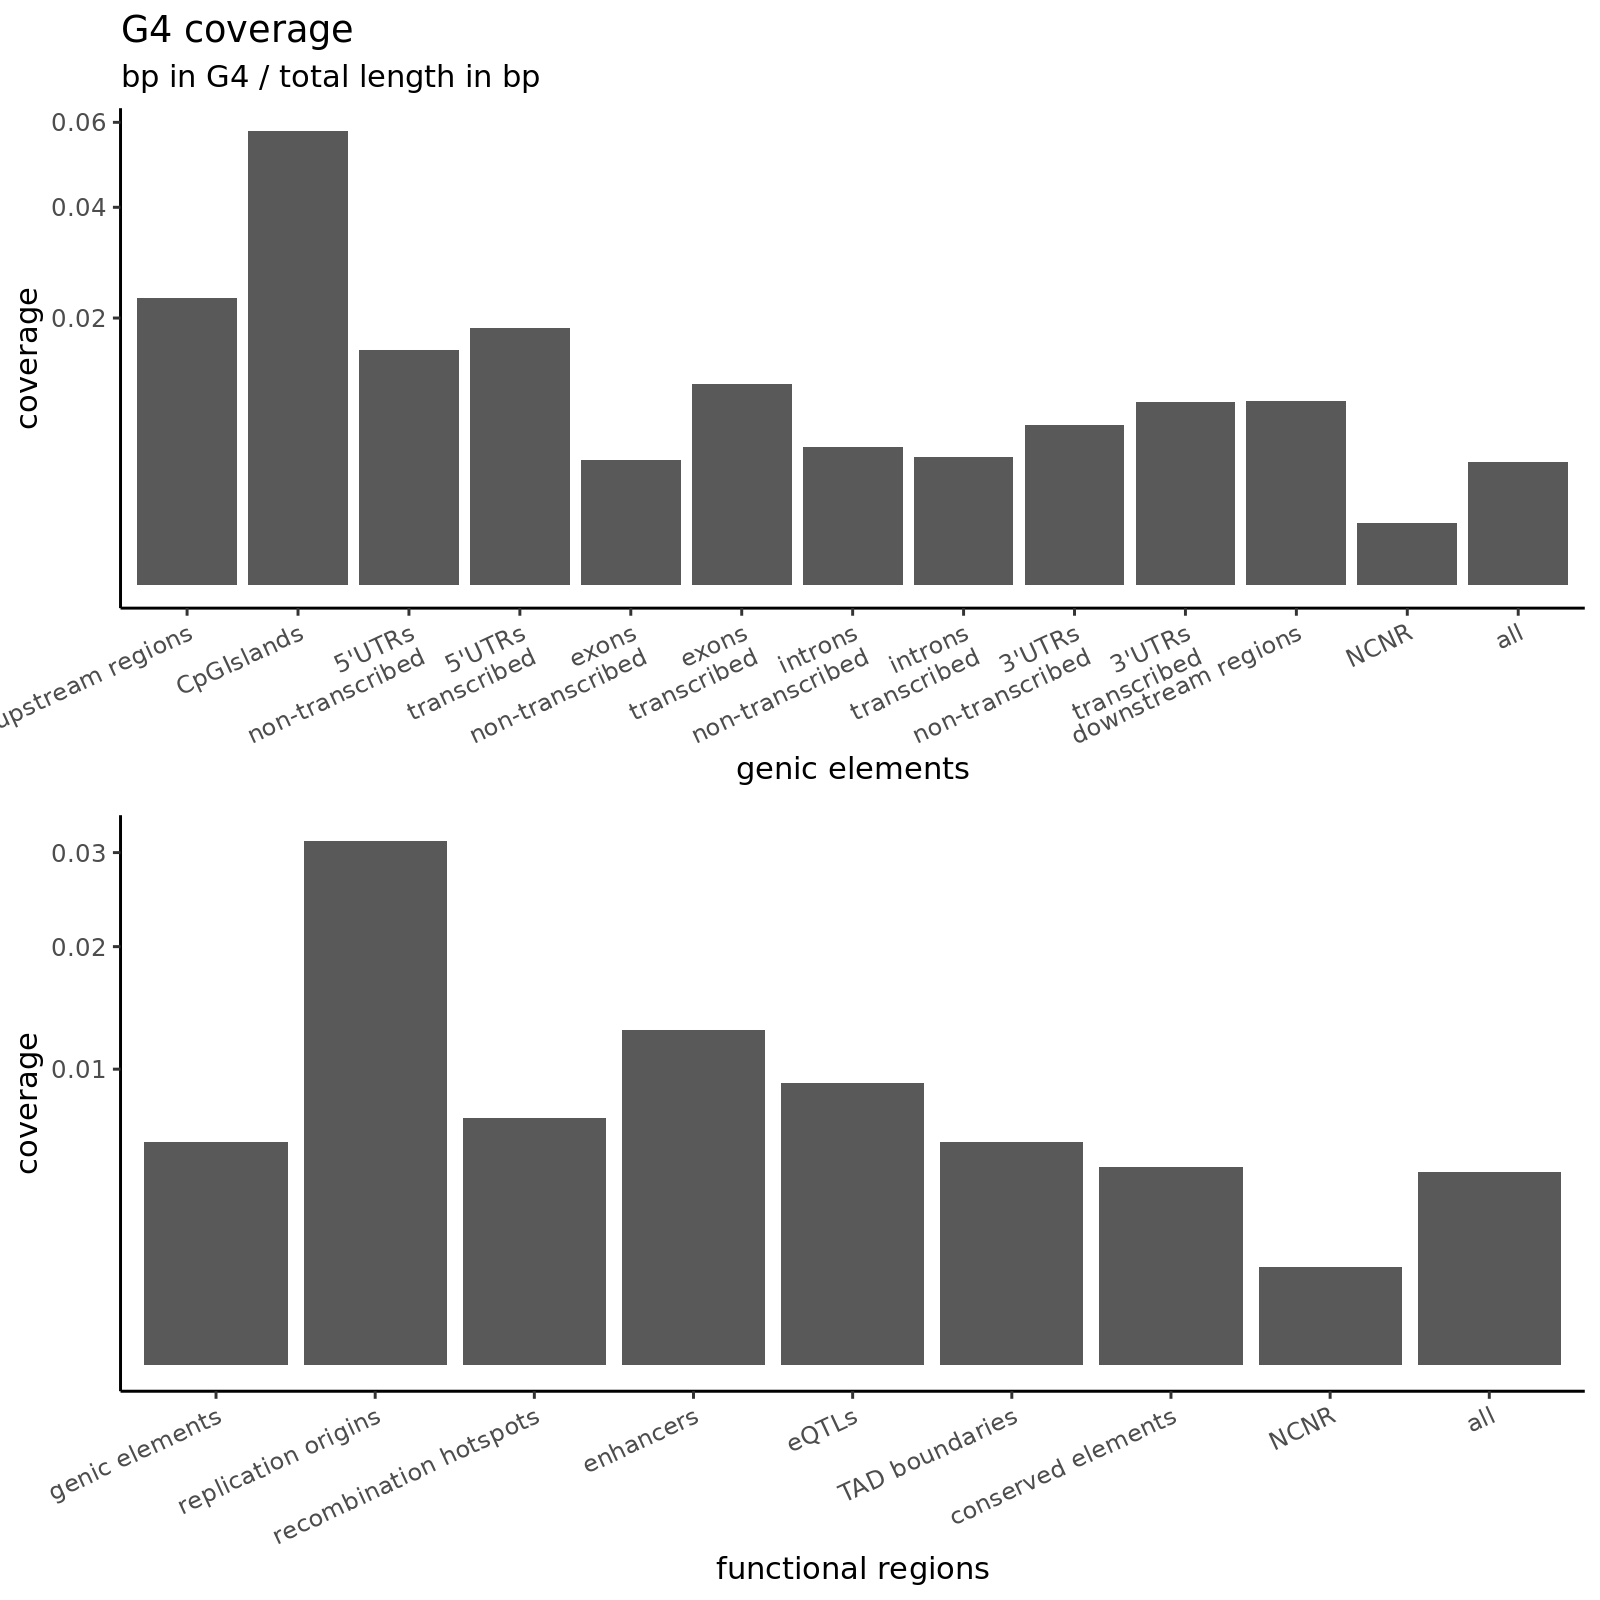

In [2017]:
%%R -w 8 -h 8 --units in -r 200 -i genic_cov_bp,RepOrigin_cov_bp,eQTL_cov_bp,enhancers_cov_bp,phastCons_cov_bp,TADB_cov_bp,recomb_hotspots_cov_bp,NCNR_cov_bp,all_cov_bp,Upstream_cov_bp,CpGIsland_cov_bp,FUTR_sense_cov_bp,FUTR_antisense_cov_bp,Exons_sense_cov_bp,Exons_antisense_cov_bp,Introns_sense_cov_bp,Introns_antisense_cov_bp,TUTR_sense_cov_bp,TUTR_antisense_cov_bp,Downstream_cov_bp


df <- data.frame(
  group = c("genic elements",  "replication origins", "eQTLs",   "enhancers",     "conserved elements", "TAD boundaries",   "recombination hotspots", "NCNR",   "all"),
  value = c(genic_cov_bp,         RepOrigin_cov_bp,         eQTL_cov_bp,   enhancers_cov_bp,   phastCons_cov_bp,       TADB_cov_bp,            recomb_hotspots_cov_bp,     NCNR_cov_bp, all_cov_bp)
  )

df_genic <- data.frame(
  group = c("upstream regions", "CpGIslands",   "5'UTRs\nnon-transcribed",  "5'UTRs\ntranscribed",   "exons\nnon-transcribed",   "exons\ntranscribed",   "introns\nnon-transcribed",   "introns\ntranscribed",  "3'UTRs\nnon-transcribed",  "3'UTRs\ntranscribed", "downstream regions","NCNR",    "all"),
  value = c(Upstream_cov_bp,       CpGIsland_cov_bp,  FUTR_sense_cov_bp,              FUTR_antisense_cov_bp,      Exons_sense_cov_bp,           Exons_antisense_cov_bp,    Introns_sense_cov_bp,            Introns_antisense_cov_bp,  TUTR_sense_cov_bp,               TUTR_antisense_cov_bp,   Downstream_cov_bp,       NCNR_cov_bp, all_cov_bp)
  )

print(df)

bar <- ggplot(df, aes(group,value)) + geom_bar(stat = "identity") + 
        theme_classic() +
        theme(axis.text.x=element_text(angle = 25, hjust = 1, family="sans"),
              axis.title.x = element_text(family="sans"),
              axis.text.y = element_text(family="sans"),
              axis.title.y = element_text(family="sans")) +
        labs(y="coverage", x="functional regions") +
        scale_x_discrete(limits = c("genic elements", "replication origins","recombination hotspots","enhancers", "eQTLs","TAD boundaries",  "conserved elements","NCNR","all"))+
        scale_y_continuous(trans="sqrt")

bar2 <- ggplot(df_genic, aes(group,value)) + geom_bar(stat = "identity") +
        theme_classic() +
        theme(axis.text.x=element_text(angle = 25, hjust = 1, family="sans"),
              axis.title.x = element_text(family="sans"),
              axis.text.y = element_text(family="sans"),
              axis.title.y = element_text(family="sans")) +
        labs(y="coverage", x="genic elements",title="G4 coverage", subtitle="bp in G4 / total length in bp") +
        scale_x_discrete(limits = c("upstream regions",  "CpGIslands",  "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed", "exons\nnon-transcribed", "exons\ntranscribed",  "introns\nnon-transcribed", "introns\ntranscribed", "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed", "downstream regions",  "NCNR",                "all"))+
        scale_y_continuous(trans="sqrt")


grid.arrange(bar2, bar, nrow = 2)

g <- arrangeGrob(bar2, bar, nrow = 2)
ggsave(file='G4coverage.pdf',g, width=8, height=8, dpi=300)




                   group    value
1         genic elements 1.323449
2    replication origins 5.447292
3                  eQTLs 1.676833
4              enhancers 2.669992
5         TAD boundaries 1.281588
6 recombination hotspots 1.277981


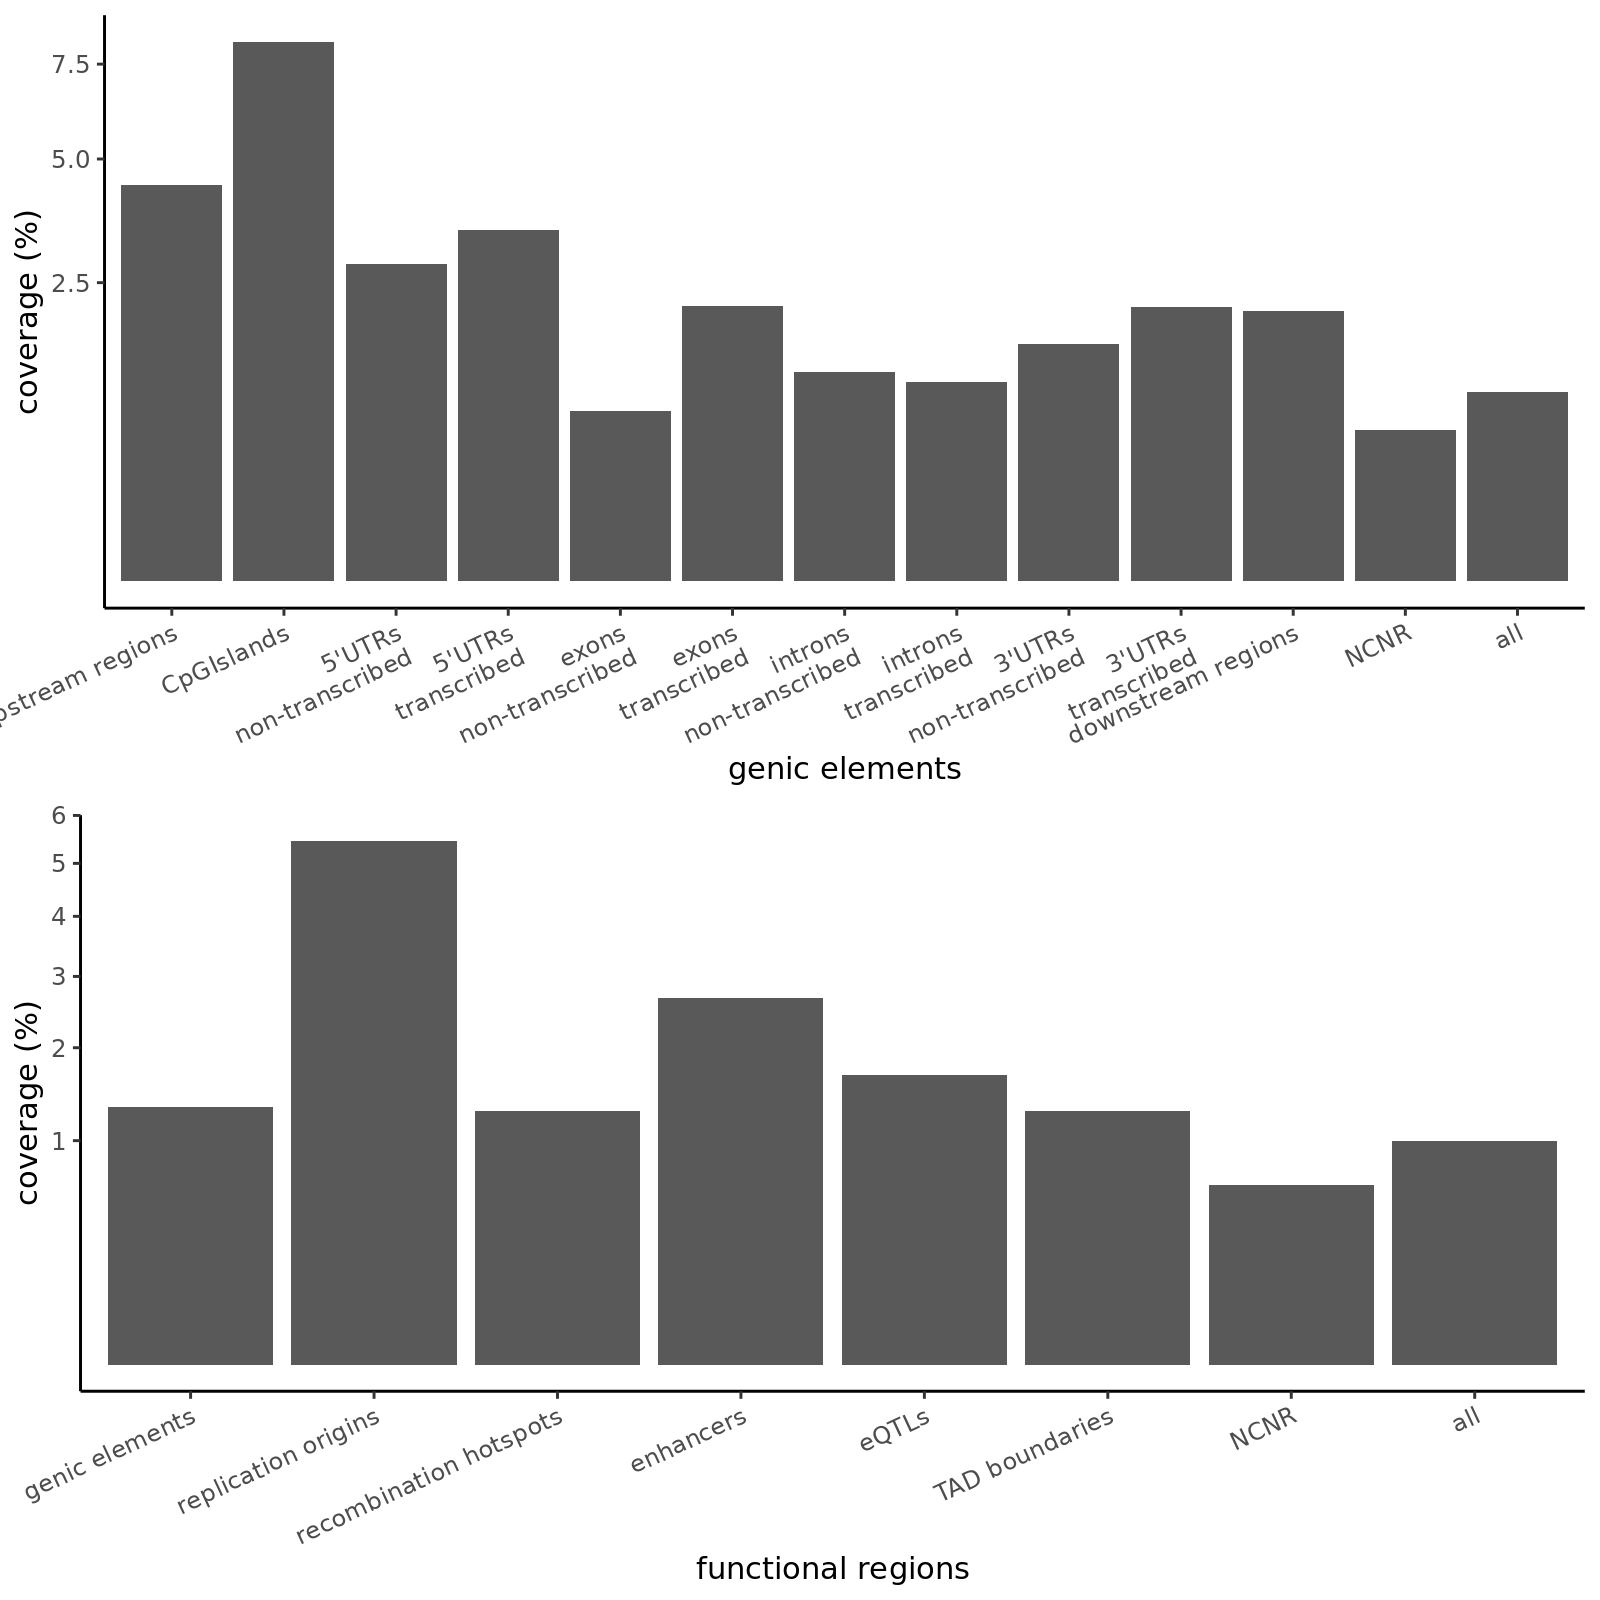

In [39]:
%%R -w 8 -h 8 --units in -r 200 -i genic_correctedcov,RepOrigin_correctedcov,eQTL_correctedcov,enhancers_correctedcov,phastCons_correctedcov,TADB_correctedcov,recomb_hotspots_correctedcov,NCNR_correctedcov,all_correctedcov,Upstream_correctedcov,CpGIsland_correctedcov,FUTR_sense_correctedcov,FUTR_antisense_correctedcov,Exons_sense_correctedcov,Exons_antisense_correctedcov,Introns_sense_correctedcov,Introns_antisense_correctedcov,TUTR_sense_correctedcov,TUTR_antisense_correctedcov,Downstream_correctedcov

df <- data.frame(
  group = c("genic elements",   "replication origins",    "eQTLs",            "enhancers",               "TAD boundaries",  "recombination hotspots",     "NCNR",              "all"),
  value = c(genic_correctedcov,  RepOrigin_correctedcov,   eQTL_correctedcov, enhancers_correctedcov, TADB_correctedcov, recomb_hotspots_correctedcov,   NCNR_correctedcov, all_correctedcov) / all_correctedcov
  )

df_genic <- data.frame(
  group = c("upstream regions",      "CpGIslands",          "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed",       "exons\nnon-transcribed",  "exons\ntranscribed",          "introns\nnon-transcribed", "introns\ntranscribed",          "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed",         "downstream regions",    "NCNR",                "all"),
  value = c(Upstream_correctedcov,  CpGIsland_correctedcov, FUTR_sense_correctedcov,    FUTR_antisense_correctedcov,  Exons_sense_correctedcov, Exons_antisense_correctedcov,  Introns_sense_correctedcov, Introns_antisense_correctedcov,  TUTR_sense_correctedcov,   TUTR_antisense_correctedcov,  Downstream_correctedcov, NCNR_correctedcov, all_correctedcov) / all_correctedcov
  )

print(head(head(df)))

bar <- ggplot(df, aes(group,value)) + geom_bar(stat = "identity") + 
        theme_classic() +
        theme(axis.text.x=element_text(angle = 25, hjust = 1, family="sans"),
              axis.title.x = element_text(family="sans"),
              axis.text.y = element_text(family="sans"),
              axis.title.y = element_text(family="sans")) +
        labs(y="coverage (%)", x="functional regions") +
        scale_x_discrete(limits = c("genic elements", "replication origins","recombination hotspots","enhancers", "eQTLs","TAD boundaries", "NCNR","all"))+
        scale_y_continuous(trans="sqrt")

bar2 <- ggplot(df_genic, aes(group,value)) + geom_bar(stat = "identity") +
        theme_classic() +
        theme(axis.text.x=element_text(angle = 25, hjust = 1, family="sans"),
              axis.title.x = element_text(family="sans"),
              axis.text.y = element_text(family="sans"),
              axis.title.y = element_text(family="sans")) +
        labs(y="coverage (%)", x="genic elements") +
        scale_x_discrete(limits = c("upstream regions",  "CpGIslands",  "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed", "exons\nnon-transcribed", "exons\ntranscribed",  "introns\nnon-transcribed", "introns\ntranscribed", "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed", "downstream regions",  "NCNR",                "all"))+
        scale_y_continuous(trans="sqrt")


grid.arrange(bar2, bar, nrow = 2)

g <- arrangeGrob(bar2, bar, nrow = 2)
ggsave(file='G4coverage.pdf',g, width=8, height=8, dpi=300)




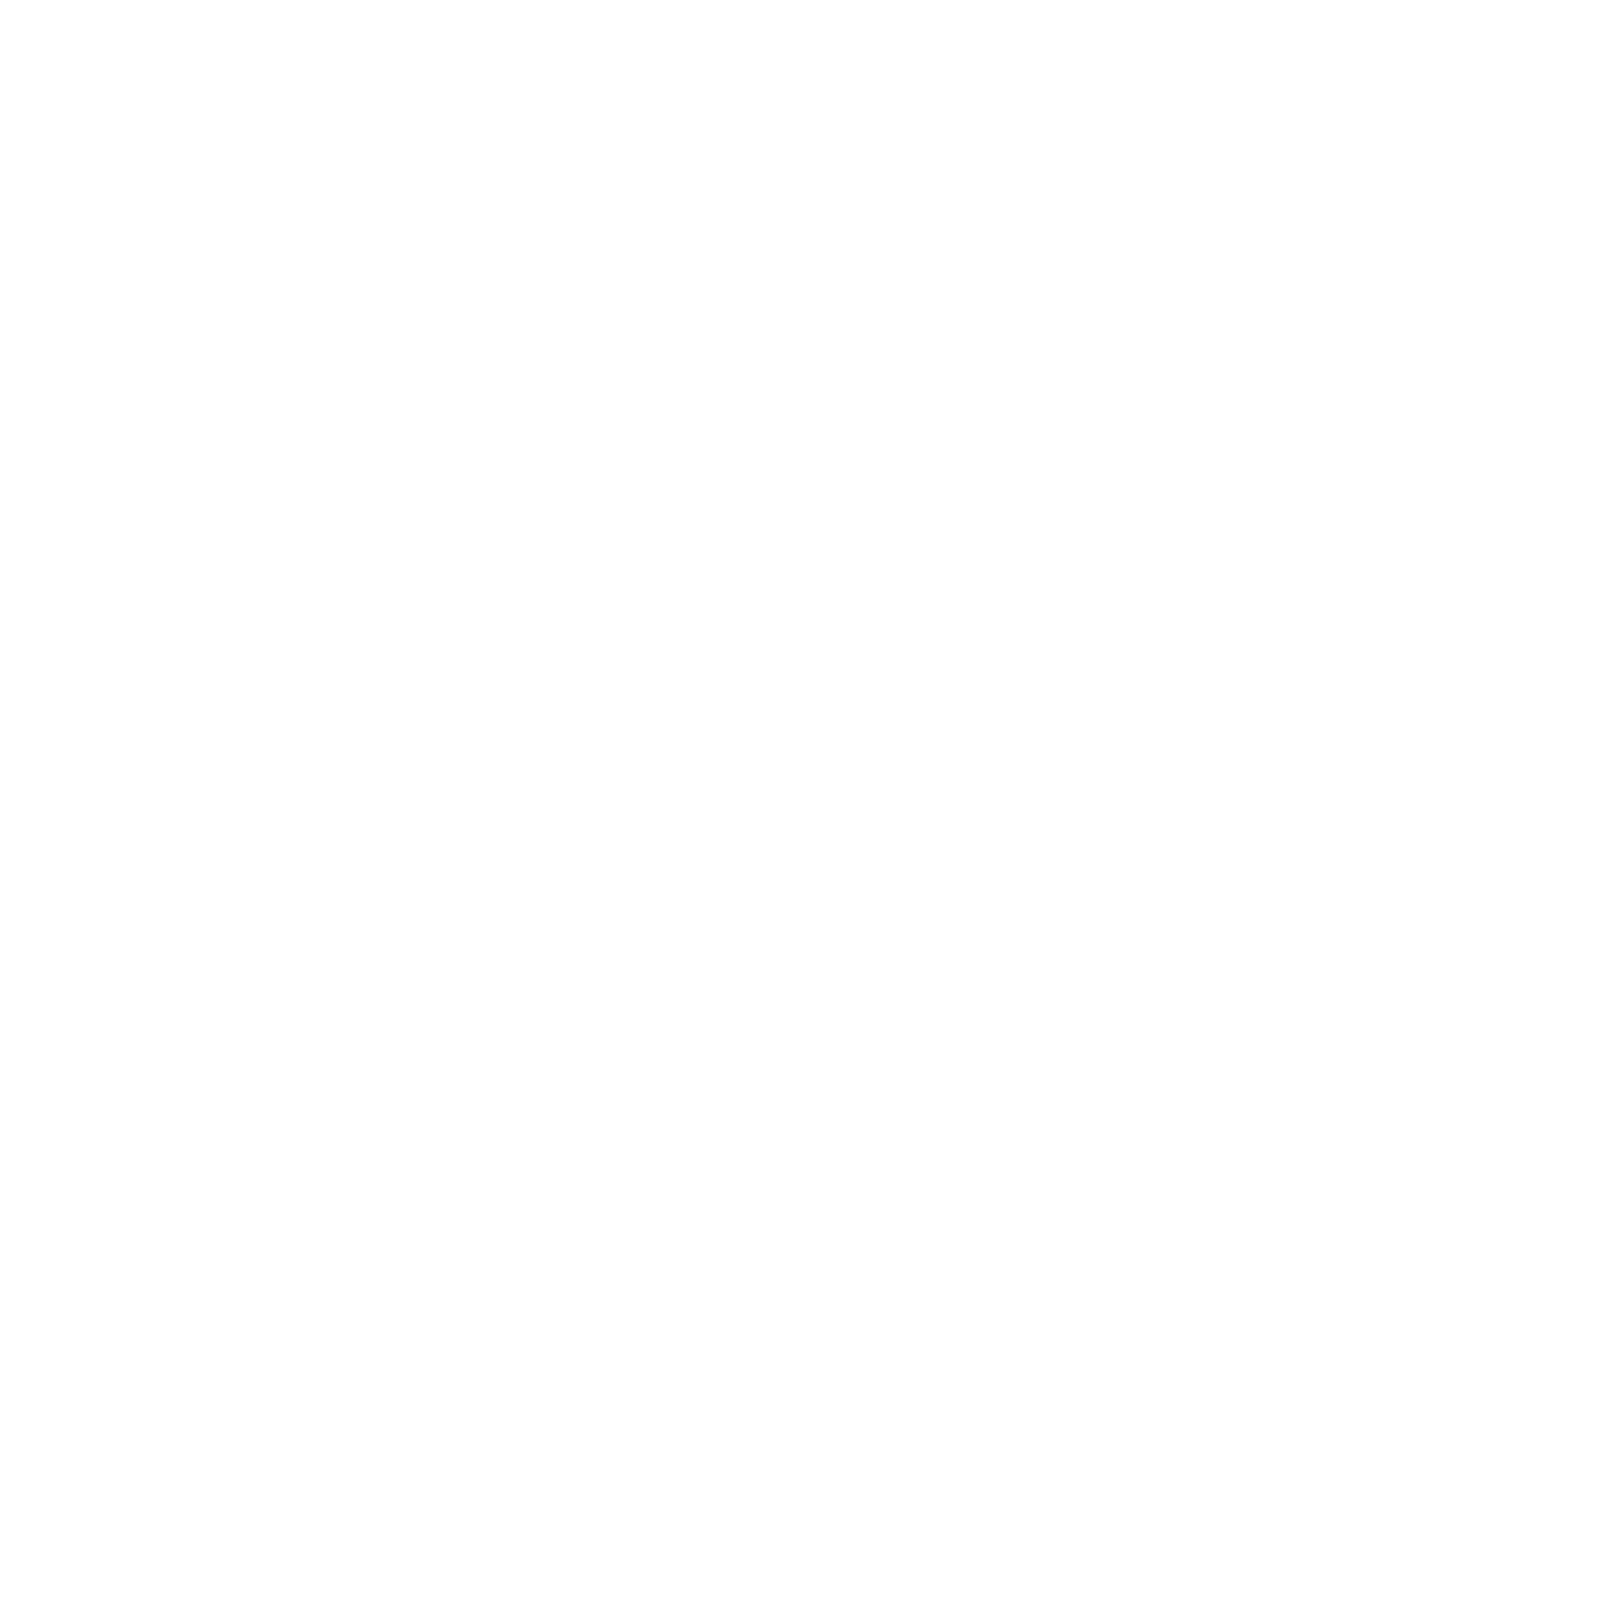

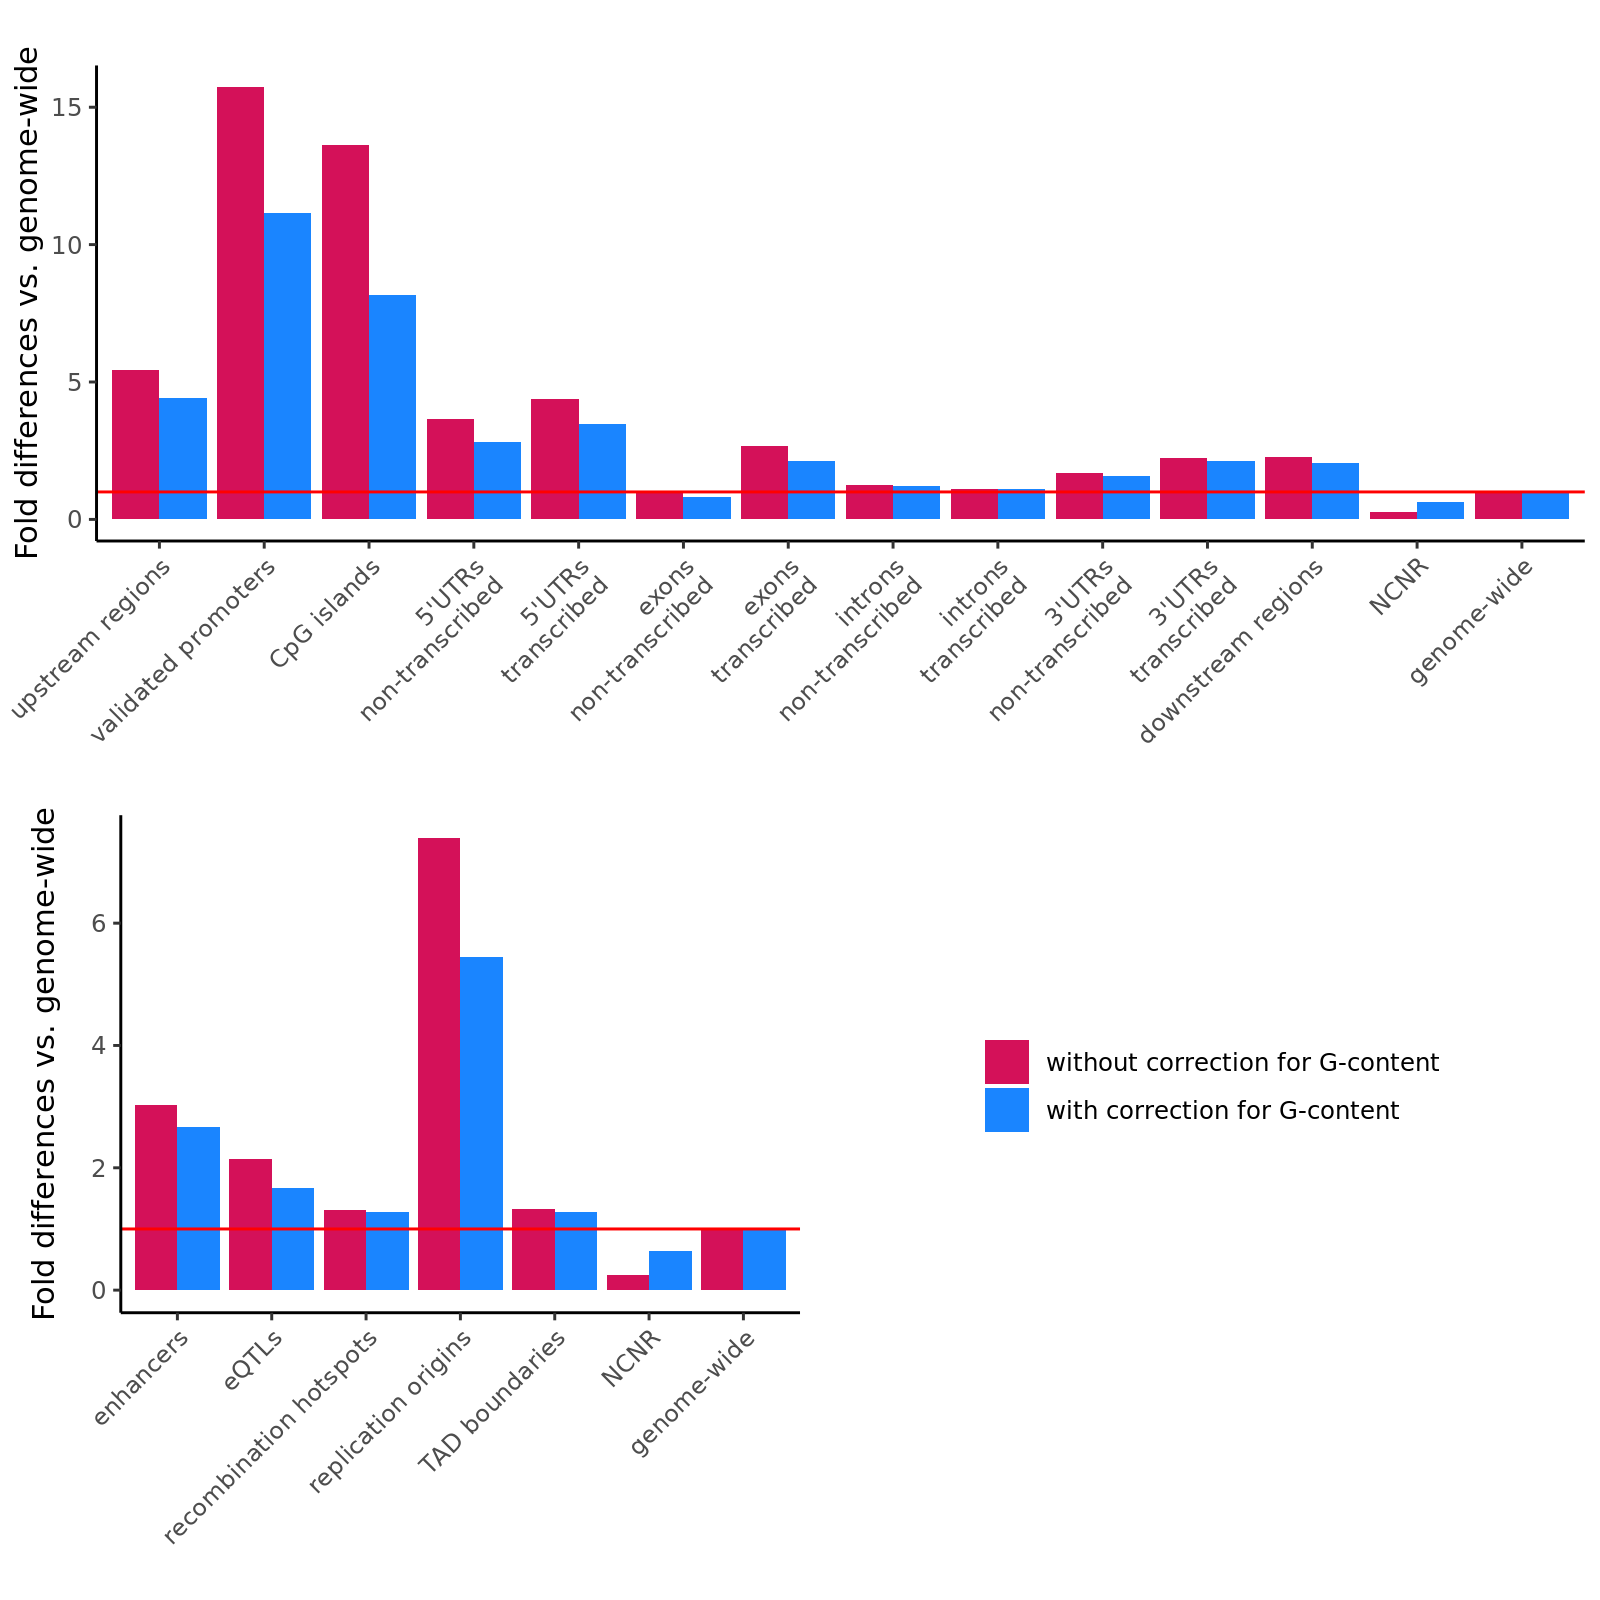

In [45]:
%%R -w 8 -h 8 --units in -r 200 -i promoters_cov_bp,promoters_correctedcov,genic_correctedcov,RepOrigin_correctedcov,eQTL_correctedcov,enhancers_correctedcov,phastCons_correctedcov,TADB_correctedcov,recomb_hotspots_correctedcov,NCNR_correctedcov,all_correctedcov,Upstream_correctedcov,CpGIsland_correctedcov,FUTR_sense_correctedcov,FUTR_antisense_correctedcov,Exons_sense_correctedcov,Exons_antisense_correctedcov,Introns_sense_correctedcov,Introns_antisense_correctedcov,TUTR_sense_correctedcov,TUTR_antisense_correctedcov,Downstream_correctedcov,genic_cov_bp,RepOrigin_cov_bp,eQTL_cov_bp,enhancers_cov_bp,phastCons_cov_bp,TADB_cov_bp,recomb_hotspots_cov_bp,NCNR_cov_bp,all_cov_bp,Upstream_cov_bp,CpGIsland_cov_bp,FUTR_sense_cov_bp,FUTR_antisense_cov_bp,Exons_sense_cov_bp,Exons_antisense_cov_bp,Introns_sense_cov_bp,Introns_antisense_cov_bp,TUTR_sense_cov_bp,TUTR_antisense_cov_bp,Downstream_cov_bp

df <- data.frame(
  type =  c('no correction',  'no correction',        'no correction', 'no correction',     'no correction',   'no correction',             'no correction',    'no correction',          'with correction',  'with correction',       'with correction',  'with correction',         'with correction',   'with correction',             'with correction',    'with correction'),
  group = c("genic elements",  "replication origins",  "eQTLs",         "enhancers",        "TAD boundaries",  "recombination hotspots",    "NCNR",             "genome-wide",                   "genic elements",    "replication origins",   "eQTLs",            "enhancers",               "TAD boundaries",    "recombination hotspots",      "NCNR",               "genome-wide"),
  value = c(c(genic_cov_bp,   RepOrigin_cov_bp,        eQTL_cov_bp,     enhancers_cov_bp,   TADB_cov_bp,       recomb_hotspots_cov_bp,      NCNR_cov_bp,        all_cov_bp)/all_cov_bp, c(genic_correctedcov,  RepOrigin_correctedcov,  eQTL_correctedcov,  enhancers_correctedcov,   TADB_correctedcov,   recomb_hotspots_correctedcov,   NCNR_correctedcov,   all_correctedcov) / all_correctedcov)
  )

df_genic <- data.frame(
  type =  c('no correction',     'no correction',       'no correction',     'no correction',            'no correction',        'no correction',           'no correction',           'no correction',            'no correction',            'no correction',             'no correction',       'no correction',          'no correction',      'no correction',      'with correction',     'with correction',         'with correction',      'with correction',          'with correction',        'with correction',           'with correction',           'with correction',             'with correction',             'with correction',            'with correction',           'with correction',      'with correction',     'with correction'),
  group = c("upstream regions",  "validated promoters", "CpG islands",        "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed",   "exons\nnon-transcribed",  "exons\ntranscribed",      "introns\nnon-transcribed", "introns\ntranscribed",     "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed",     "downstream regions",    "NCNR",                "genome-wide",             "upstream regions",      "validated promoters", "CpG islands",          "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed",       "exons\nnon-transcribed",  "exons\ntranscribed",          "introns\nnon-transcribed", "introns\ntranscribed",          "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed",         "downstream regions",    "NCNR",                "genome-wide"),
  value = c(c(Upstream_cov_bp,   promoters_cov_bp,       CpGIsland_cov_bp,    FUTR_sense_cov_bp,         FUTR_antisense_cov_bp,   Exons_sense_cov_bp,       Exons_antisense_cov_bp,   Introns_sense_cov_bp,         Introns_antisense_cov_bp,  TUTR_sense_cov_bp,           TUTR_antisense_cov_bp,   Downstream_cov_bp,       NCNR_cov_bp,      all_cov_bp) / all_cov_bp, c(Upstream_correctedcov, promoters_correctedcov,  CpGIsland_correctedcov, FUTR_sense_correctedcov,    FUTR_antisense_correctedcov,  Exons_sense_correctedcov, Exons_antisense_correctedcov,  Introns_sense_correctedcov, Introns_antisense_correctedcov,  TUTR_sense_correctedcov,   TUTR_antisense_correctedcov,  Downstream_correctedcov, NCNR_correctedcov, all_correctedcov) / all_correctedcov)
  )

palette <- c("#D41159", "#1A85FF")

bar <- ggplot(df, aes(group,value)) + 
        geom_bar(aes(fill=type),stat = "identity", position='dodge') +
        geom_hline(yintercept=1, color="red") +
        theme_classic() +
        theme(axis.text.x=element_text(angle = 45, hjust = 1, family="sans"),
              axis.title.x = element_text(family="sans"),
              axis.text.y = element_text(family="sans"),
              axis.title.y = element_text(family="sans")) +
        labs(y="Fold differences vs. genome-wide", x="") +
        scale_x_discrete(limits = c("enhancers","eQTLs","recombination hotspots","replication origins", "TAD boundaries","NCNR","genome-wide"))+
        scale_fill_manual(name="", values=c(palette[1],palette[2]), labels = c("without correction for G-content","with correction for G-content"))


bar2 <- ggplot(df_genic, aes(group,value)) +
        geom_bar(aes(fill=type),stat = "identity", position='dodge') +
        geom_hline(yintercept=1, color="red") +
        theme_classic() +
        theme(legend.position="none",
              axis.text.x=element_text(angle = 45, hjust = 1, family="sans"),
              axis.title.x = element_text(family="sans"),
              axis.text.y = element_text(family="sans"),
              axis.title.y = element_text(family="sans")) +
        labs(y="Fold differences vs. genome-wide", x="",title="") +
        scale_x_discrete(limits = c("upstream regions", "validated promoters",  "CpG islands",  "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed", "exons\nnon-transcribed", "exons\ntranscribed",  "introns\nnon-transcribed", "introns\ntranscribed", "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed", "downstream regions",  "NCNR", "genome-wide"))+
        scale_fill_manual(values=c(palette[1],palette[2]))


# Get the gtables
gA <- ggplotGrob(bar2)
gB <- ggplotGrob(bar)

# Set the widths
gA$widths <- gA$widths * 1
gB$widths <- gB$widths * 1.5

# Arrange the two charts.
# The legend boxes are centered
#grid.newpage()
grid.arrange(gA, gB, nrow = 2)
g <- arrangeGrob(gA, gB, nrow = 2)
ggsave(file='G4coverage.pdf',g, width=8, height=8, dpi=300)




           type                  group     value
1 no correction         genic elements  5.302906
2 no correction    replication origins 29.111764
3 no correction                  eQTLs  8.425157
4 no correction              enhancers 11.920671
5 no correction         TAD boundaries  5.247973
6 no correction recombination hotspots  5.129399


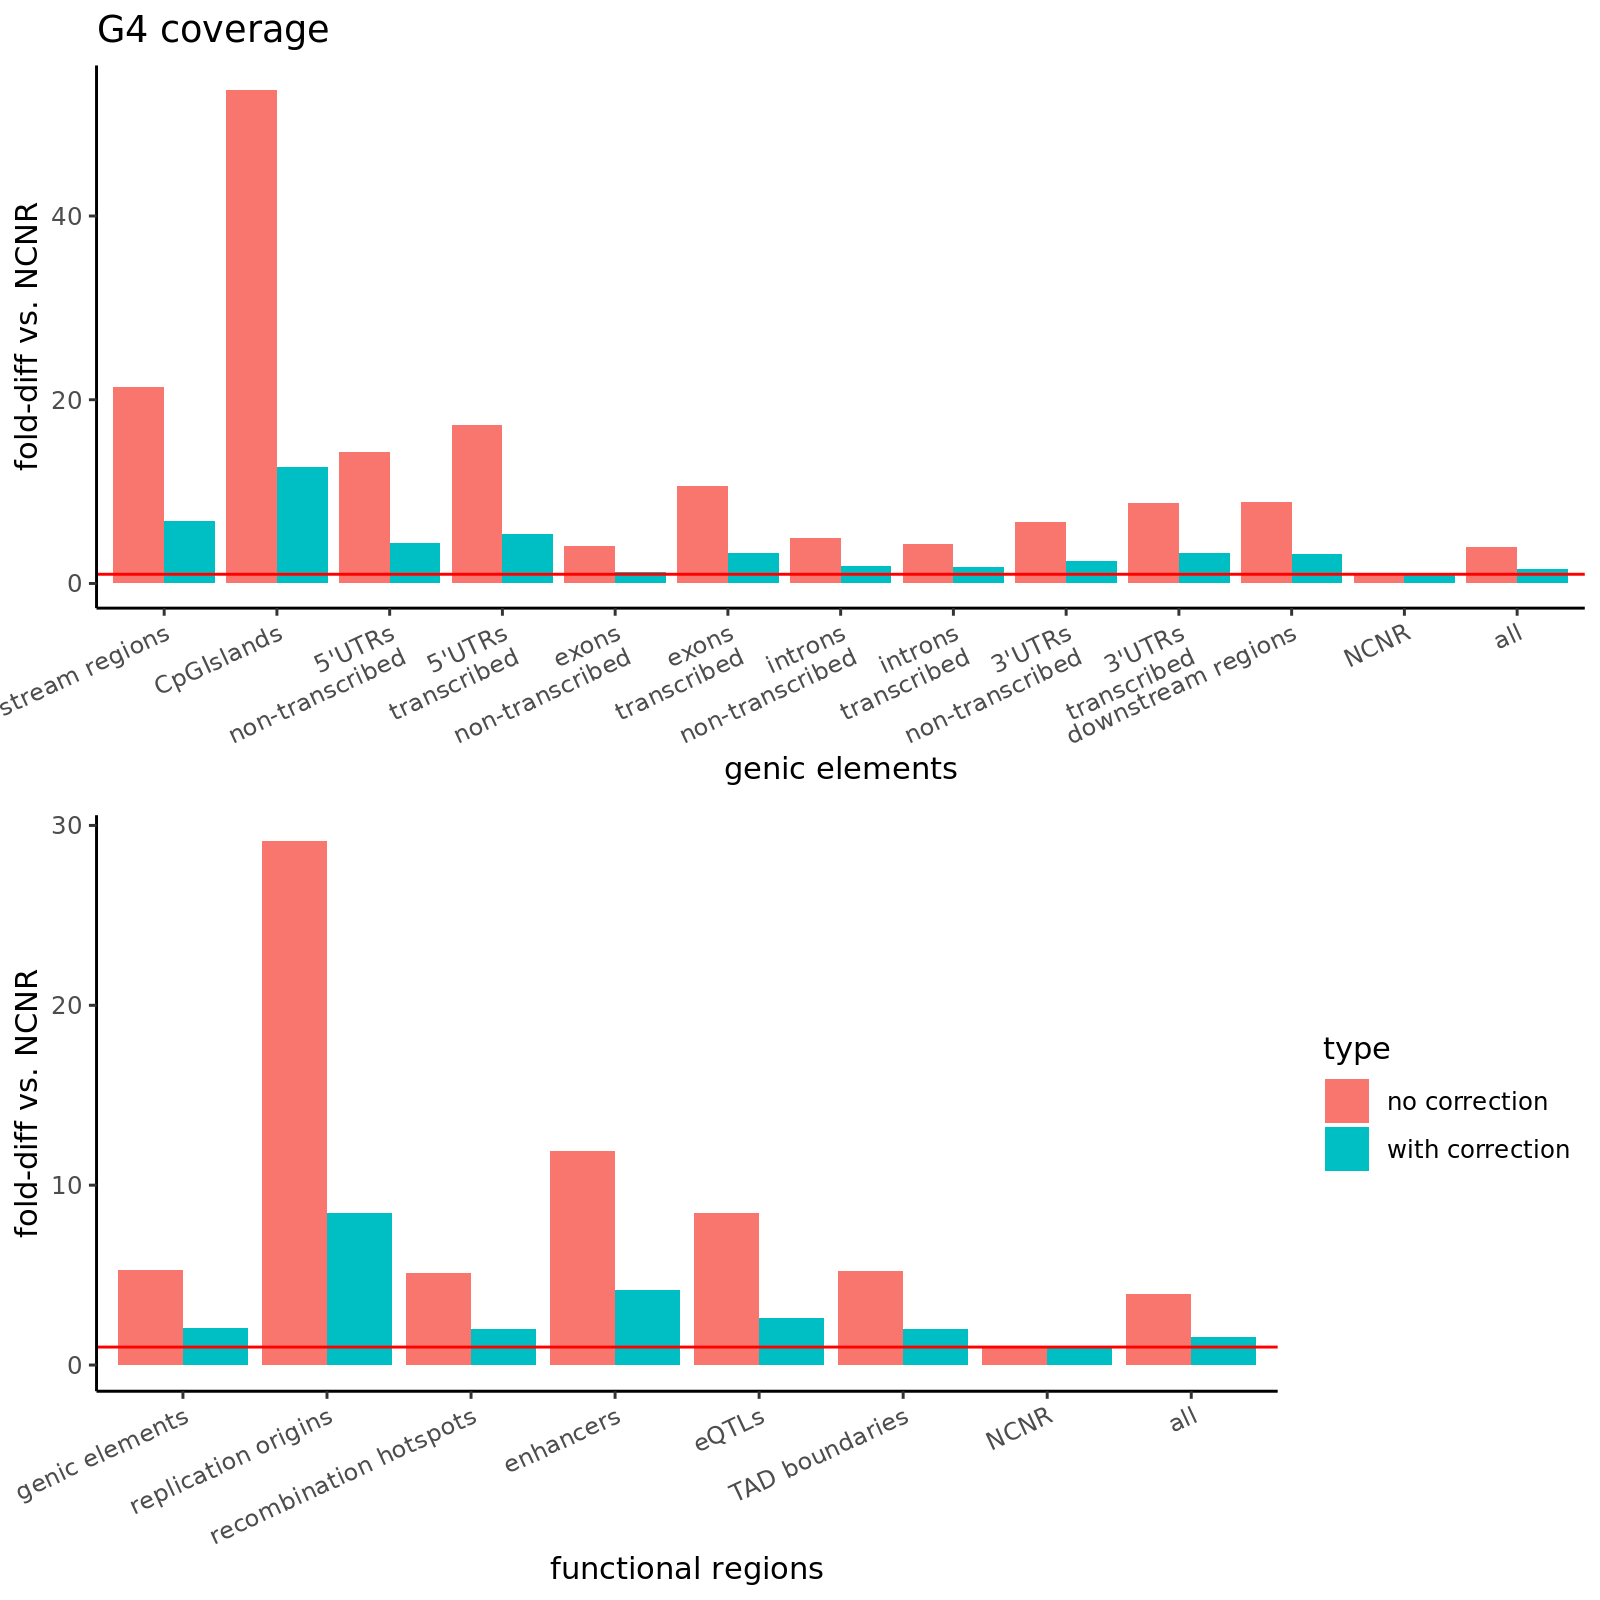

In [2044]:
%%R -w 8 -h 8 --units in -r 200 -i genic_correctedcov,RepOrigin_correctedcov,eQTL_correctedcov,enhancers_correctedcov,phastCons_correctedcov,TADB_correctedcov,recomb_hotspots_correctedcov,NCNR_correctedcov,all_correctedcov,Upstream_correctedcov,CpGIsland_correctedcov,FUTR_sense_correctedcov,FUTR_antisense_correctedcov,Exons_sense_correctedcov,Exons_antisense_correctedcov,Introns_sense_correctedcov,Introns_antisense_correctedcov,TUTR_sense_correctedcov,TUTR_antisense_correctedcov,Downstream_correctedcov,genic_cov_bp,RepOrigin_cov_bp,eQTL_cov_bp,enhancers_cov_bp,phastCons_cov_bp,TADB_cov_bp,recomb_hotspots_cov_bp,NCNR_cov_bp,all_cov_bp,Upstream_cov_bp,CpGIsland_cov_bp,FUTR_sense_cov_bp,FUTR_antisense_cov_bp,Exons_sense_cov_bp,Exons_antisense_cov_bp,Introns_sense_cov_bp,Introns_antisense_cov_bp,TUTR_sense_cov_bp,TUTR_antisense_cov_bp,Downstream_cov_bp

df <- data.frame(
  type =  c('no correction',   'no correction',         'no correction',  'no correction',    'no correction',   'no correction',           'no correction',  'no correction',            'with correction',   'with correction',       'with correction',  'with correction',      'with correction',  'with correction',             'with correction',   'with correction'),
  group = c("genic elements",  "replication origins",   "eQTLs",          "enhancers",        "TAD boundaries",  "recombination hotspots",  "NCNR",            "all",                     "genic elements",    "replication origins",   "eQTLs",            "enhancers",             "TAD boundaries",  "recombination hotspots",       "NCNR",             "all"),
  value = c(c(genic_cov_bp,    RepOrigin_cov_bp,        eQTL_cov_bp,      enhancers_cov_bp,    TADB_cov_bp,       recomb_hotspots_cov_bp,   NCNR_cov_bp,       all_cov_bp)/NCNR_cov_bp, c(genic_correctedcov,  RepOrigin_correctedcov,   eQTL_correctedcov,  enhancers_correctedcov,  TADB_correctedcov, recomb_hotspots_correctedcov,   NCNR_correctedcov, all_correctedcov) / NCNR_correctedcov)
  )

df_genic <- data.frame(
  type =  c('no correction',     'no correction',     'no correction',            'no correction',        'no correction',           'no correction',           'no correction',            'no correction',            'no correction',             'no correction',       'no correction',          'no correction',      'no correction',      'with correction',       'with correction',      'with correction',          'with correction',        'with correction',           'with correction',           'with correction',             'with correction',             'with correction',            'with correction',           'with correction',      'with correction',     'with correction'),
  group = c("upstream regions",  "CpGIslands",        "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed",   "exons\nnon-transcribed",  "exons\ntranscribed",      "introns\nnon-transcribed", "introns\ntranscribed",     "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed",     "downstream regions",    "NCNR",                "all",             "upstream regions",      "CpGIslands",          "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed",       "exons\nnon-transcribed",  "exons\ntranscribed",          "introns\nnon-transcribed", "introns\ntranscribed",          "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed",         "downstream regions",    "NCNR",                "all"),
  value = c(c(Upstream_cov_bp,   CpGIsland_cov_bp,    FUTR_sense_cov_bp,         FUTR_antisense_cov_bp,   Exons_sense_cov_bp,       Exons_antisense_cov_bp,   Introns_sense_cov_bp,         Introns_antisense_cov_bp,  TUTR_sense_cov_bp,           TUTR_antisense_cov_bp,   Downstream_cov_bp,       NCNR_cov_bp,      all_cov_bp) / NCNR_cov_bp, c(Upstream_correctedcov,  CpGIsland_correctedcov, FUTR_sense_correctedcov,    FUTR_antisense_correctedcov,  Exons_sense_correctedcov, Exons_antisense_correctedcov,  Introns_sense_correctedcov, Introns_antisense_correctedcov,  TUTR_sense_correctedcov,   TUTR_antisense_correctedcov,  Downstream_correctedcov, NCNR_correctedcov, all_correctedcov) / NCNR_correctedcov)
  )

print(head(head(df)))

bar <- ggplot(df, aes(group,value)) + 
        geom_bar(aes(fill=type),stat = "identity", position='dodge') +
        geom_hline(yintercept=1, color="red") +
        theme_classic() +
        theme(axis.text.x=element_text(angle = 25, hjust = 1, family="sans"),
              axis.title.x = element_text(family="sans"),
              axis.text.y = element_text(family="sans"),
              axis.title.y = element_text(family="sans")) +
        labs(y="fold-diff vs. NCNR", x="functional regions") +
        #scale_fill_manual(values=c("not corrected"='red',"corrected"='blue'),name="type",limits=c('not corrected','corrected'))+
        scale_x_discrete(limits = c("genic elements", "replication origins","recombination hotspots","enhancers", "eQTLs","TAD boundaries","NCNR","all"))#+
        #scale_y_continuous(trans="sqrt")

bar2 <- ggplot(df_genic, aes(group,value)) +
        geom_bar(aes(fill=type),stat = "identity", position='dodge') +
        geom_hline(yintercept=1, color="red") +
        theme_classic() +
        theme(legend.position="none",
              axis.text.x=element_text(angle = 25, hjust = 1, family="sans"),
              axis.title.x = element_text(family="sans"),
              axis.text.y = element_text(family="sans"),
              axis.title.y = element_text(family="sans")) +
        labs(y="fold-diff vs. NCNR", x="genic elements",title="G4 coverage") +
        scale_x_discrete(limits = c("upstream regions",  "CpGIslands",  "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed", "exons\nnon-transcribed", "exons\ntranscribed",  "introns\nnon-transcribed", "introns\ntranscribed", "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed", "downstream regions",  "NCNR",                "all"))#+
        #scale_y_continuous(trans="sqrt")


grid.arrange(bar2, bar, nrow = 2)

g <- arrangeGrob(bar2, bar, nrow = 2)
ggsave(file='G4coverage.pdf',g, width=8, height=8, dpi=300)




In [2045]:
all_cov,all_total,all_Gcontent,NCNR_cov,NCNR_total,NCNR_Gcontent = float(all_cov),float(all_total),float(all_Gcontent),float(NCNR_cov),float(NCNR_total),float(NCNR_Gcontent)


In [1827]:
%%R -i all_cov,all_total,all_Gcontent,NCNR_cov,NCNR_total,NCNR_Gcontent

all_cov = all_cov/1000
all_total = all_total/1000
all_Gcontent = all_Gcontent/1000
NCNR_cov = NCNR_cov/1000
NCNR_total = NCNR_total/1000
NCNR_Gcontent = NCNR_Gcontent/1000




fisher <- fisher.test(cbind(c(NCNR_cov,NCNR_total),c(all_cov,all_total)))
print(paste('NCNR p-value = ',fisher$p.value))

print('G-content')
fisher <- fisher.test(cbind(c(NCNR_cov,NCNR_Gcontent),c(all_cov,all_Gcontent)))
print(paste('NCNR p-value = ',fisher$p.value))



[1] "NCNR p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"


In [2046]:
%%R -i Upstream_cov,Upstream_total,Upstream_Gcontent

cov = Upstream_cov
total = Upstream_total
Gcontent = Upstream_Gcontent

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"

	Fisher's Exact Test for Count Data

data:  cbind(c(cov, total), c(NCNR_cov, NCNR_total))
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 7.058798 7.732997
sample estimates:
odds ratio 
   7.38532 

[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"

	Fisher's Exact Test for Count Data

data:  cbind(c(cov, Gcontent), c(NCNR_cov, NCNR_Gcontent))
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 7.167211 7.854972
sample estimates:
odds ratio 
  7.502522 

[1] "all p-value =  0"


In [2047]:
%%R -i FUTR_sense_cov,FUTR_sense_total,FUTR_sense_Gcontent,FUTR_antisense_cov,FUTR_antisense_total,FUTR_antisense_Gcontent


cov_sense = FUTR_sense_cov 
cov_antisense = FUTR_antisense_cov 
total_sense = FUTR_sense_total 
total_antisense =  FUTR_antisense_total 
Gcontent_sense = FUTR_sense_Gcontent
Gcontent_antisense = FUTR_antisense_Gcontent 

print('sense')
fisher_NCNR <- fisher.test(cbind(c(cov_sense,total_sense),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_sense,total_sense),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))

print('anti-sense')
fisher_NCNR <- fisher.test(cbind(c(cov_antisense,total_antisense),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_antisense,total_antisense),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))

print('sense vs anti-sense')
fisher <- fisher.test(cbind(c(cov_sense,total_sense),c(cov_antisense,total_antisense)))
print(paste('p-value = ',fisher$p.value))

print('G-corrected')

print('sense')
fisher_NCNR <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))

print('anti-sense')
fisher_NCNR <- fisher.test(cbind(c(cov_antisense,Gcontent_antisense),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_antisense,Gcontent_antisense),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))

print('sense vs anti-sense')
fisher <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(cov_antisense,Gcontent_antisense)))
print(paste('p-value = ',fisher$p.value))


[1] "sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "anti-sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "sense vs anti-sense"
[1] "p-value =  0"
[1] "G-corrected"
[1] "sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "anti-sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "sense vs anti-sense"
[1] "p-value =  0"


In [2048]:
%%R -i Exons_sense_cov,Exons_sense_total,Exons_sense_Gcontent,Exons_antisense_cov,Exons_antisense_total,Exons_antisense_Gcontent

cov_sense = Exons_sense_cov 
cov_antisense = Exons_antisense_cov 
total_sense = Exons_sense_total 
total_antisense =  Exons_antisense_total 
Gcontent_sense = Exons_sense_Gcontent
Gcontent_antisense = Exons_antisense_Gcontent 

print('sense')
fisher_NCNR <- fisher.test(cbind(c(cov_sense,total_sense),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_sense,total_sense),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))

print('anti-sense')
fisher_NCNR <- fisher.test(cbind(c(cov_antisense,total_antisense),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_antisense,total_antisense),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))

print('sense vs anti-sense')
fisher <- fisher.test(cbind(c(cov_sense,total_sense),c(cov_antisense,total_antisense)))
print(paste('p-value = ',fisher$p.value))

print('G-corrected')

print('sense')
fisher_NCNR <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))

print('anti-sense')
fisher_NCNR <- fisher.test(cbind(c(cov_antisense,Gcontent_antisense),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_antisense,Gcontent_antisense),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))

print('sense vs anti-sense')
fisher <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(cov_antisense,Gcontent_antisense)))
print(paste('p-value = ',fisher$p.value))


[1] "sense"
[1] "NCNR p-value =  1.2071193662514e-55"
[1] "all p-value =  0"
[1] "anti-sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "sense vs anti-sense"
[1] "p-value =  0"
[1] "G-corrected"
[1] "sense"
[1] "NCNR p-value =  5.78742680270609e-48"
[1] "all p-value =  0"
[1] "anti-sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  1.15793602817923e-17"
[1] "sense vs anti-sense"
[1] "p-value =  0"


In [2049]:
%%R -i Introns_sense_cov,Introns_sense_total,Introns_sense_Gcontent,Introns_antisense_cov,Introns_antisense_total,Introns_antisense_Gcontent


cov_sense = Introns_sense_cov 
cov_antisense = Introns_antisense_cov 
total_sense = Introns_sense_total 
total_antisense =  Introns_antisense_total 
Gcontent_sense = Introns_sense_Gcontent
Gcontent_antisense = Introns_antisense_Gcontent 

print('sense')
fisher_NCNR <- fisher.test(cbind(c(cov_sense,total_sense),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_sense,total_sense),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))

print('anti-sense')
fisher_NCNR <- fisher.test(cbind(c(cov_antisense,total_antisense),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_antisense,total_antisense),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))

print('sense vs anti-sense')
fisher <- fisher.test(cbind(c(cov_sense,total_sense),c(cov_antisense,total_antisense)))
print(paste('p-value = ',fisher$p.value))

print('G-corrected')

print('sense')
fisher_NCNR <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))

print('anti-sense')
fisher_NCNR <- fisher.test(cbind(c(cov_antisense,Gcontent_antisense),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_antisense,Gcontent_antisense),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))

print('sense vs anti-sense')
fisher <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(cov_antisense,Gcontent_antisense)))
print(paste('p-value = ',fisher$p.value))


[1] "sense"
[1] "NCNR p-value =  3.966591950509e-142"
[1] "all p-value =  0"
[1] "anti-sense"
[1] "NCNR p-value =  8.71643581364969e-76"
[1] "all p-value =  0"
[1] "sense vs anti-sense"
[1] "p-value =  0"
[1] "G-corrected"
[1] "sense"
[1] "NCNR p-value =  2.11225002168257e-284"
[1] "all p-value =  0"
[1] "anti-sense"
[1] "NCNR p-value =  1.47376585462122e-210"
[1] "all p-value =  0"
[1] "sense vs anti-sense"
[1] "p-value =  0"


In [1833]:
%%R -i TUTR_sense_cov,TUTR_sense_total,TUTR_sense_Gcontent,TUTR_antisense_cov,TUTR_antisense_total,TUTR_antisense_Gcontent

cov_sense = TUTR_sense_cov 
cov_antisense = TUTR_antisense_cov 
total_sense = TUTR_sense_total 
total_antisense =  TUTR_antisense_total 
Gcontent_sense = TUTR_sense_Gcontent
Gcontent_antisense = TUTR_antisense_Gcontent 

print('sense')
fisher_NCNR <- fisher.test(cbind(c(cov_sense,total_sense),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_sense,total_sense),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))

print('anti-sense')
fisher_NCNR <- fisher.test(cbind(c(cov_antisense,total_antisense),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_antisense,total_antisense),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))

print('sense vs anti-sense')
fisher <- fisher.test(cbind(c(cov_sense,total_sense),c(cov_antisense,total_antisense)))
print(paste('p-value = ',fisher$p.value))

print('G-corrected')

print('sense')
fisher_NCNR <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))

print('anti-sense')
fisher_NCNR <- fisher.test(cbind(c(cov_antisense,Gcontent_antisense),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_antisense,Gcontent_antisense),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))

print('sense vs anti-sense')
fisher <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(cov_antisense,Gcontent_antisense)))
print(paste('p-value = ',fisher$p.value))

[1] "sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "anti-sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "sense vs anti-sense"
[1] "p-value =  0"
[1] "G-corrected"
[1] "sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  2.43191472935211e-239"
[1] "anti-sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  3.72459502652153e-15"
[1] "sense vs anti-sense"
[1] "p-value =  0"


In [2050]:
%%R -i Downstream_cov,Downstream_total,Downstream_Gcontent

cov = Downstream_cov
total = Downstream_total
Gcontent = Downstream_Gcontent

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"

	Fisher's Exact Test for Count Data

data:  cbind(c(cov, total), c(NCNR_cov, NCNR_total))
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 2.924486 3.203850
sample estimates:
odds ratio 
  3.059815 

[1] "all p-value =  4.74134885326548e-77"
[1] "G-content"
[1] "NCNR p-value =  0"

	Fisher's Exact Test for Count Data

data:  cbind(c(cov, Gcontent), c(NCNR_cov, NCNR_Gcontent))
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 3.331782 3.651157
sample estimates:
odds ratio 
   3.48685 

[1] "all p-value =  0.000313791080355848"


In [1835]:
%%R -i genic_cov,genic_total,genic_Gcontent


cov = genic_cov
total = genic_total
Gcontent = genic_Gcontent

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


In [2051]:
%%R -i RepOrigin_cov,RepOrigin_total,RepOrigin_Gcontent


cov = RepOrigin_cov
total = RepOrigin_total
Gcontent = RepOrigin_Gcontent

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


In [2052]:
%%R -i eQTL_cov,eQTL_total,eQTL_Gcontent

cov = eQTL_cov
total = eQTL_total
Gcontent = eQTL_Gcontent

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  5.26920428010434e-13"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  1.72214773326549e-76"


In [1838]:
%%R -i eQTL_extended_cov,eQTL_extended_total,eQTL_extended_Gcontent

cov = eQTL_extended_cov
total = eQTL_extended_total
Gcontent = eQTL_extended_Gcontent

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  1.11043542816986e-241"


In [2053]:
%%R -i enhancers_cov,enhancers_total,enhancers_Gcontent

cov = enhancers_cov
total = enhancers_total
Gcontent = enhancers_Gcontent

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


In [1840]:
%%R -i phastCons_cov,phastCons_total,phastCons_Gcontent

cov = phastCons_cov
total = phastCons_total
Gcontent = phastCons_Gcontent

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  3.14398833718519e-19"
[1] "G-content"
[1] "NCNR p-value =  3.06620505288578e-224"
[1] "all p-value =  0"


In [1841]:
%%R -i phastCons_extended_cov,phastCons_extended_total,phastCons_extended_Gcontent

cov = phastCons_extended_cov
total = phastCons_extended_total
Gcontent = phastCons_extended_Gcontent

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  2.09360127967401e-20"
[1] "G-content"
[1] "NCNR p-value =  3.82247084041732e-144"
[1] "all p-value =  0"


In [2066]:
%%R -i TADB_cov,TADB_total,TADB_Gcontent

cov = TADB_cov
total = TADB_total
Gcontent = TADB_Gcontent

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  6.04564905008131e-178"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  1.97626258336499e-323"
[1] "all p-value =  0"


In [ ]:
%%R -i recomb_hotspots_cov,recomb_hotspots_total,recomb_hotspots_Gcontent

cov = recomb_hotspots_cov
total = recomb_hotspots_total
Gcontent = recomb_hotspots_Gcontent

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


In [2056]:
%%R -i CpGIsland_cov,CpGIsland_total,CpGIsland_Gcontent

cov = CpGIsland_cov
total = CpGIsland_total
Gcontent = CpGIsland_Gcontent

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


In [1845]:
%%R -i promoters_cov,promoters_total,promoters_Gcontent

cov = promoters_cov
total = promoters_total
Gcontent = promoters_Gcontent

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))

[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


## Density

In [2097]:
allIntersectCount_ref = open('all+.G4intersectcount', 'rt').readline().split(' ')[0]
allIntersectCount_rev = open('all-.G4intersectcount', 'rt').readline().split(' ')[0]
print('all '+str(float(allIntersectCount_ref)+float(allIntersectCount_rev)))

density_all = (float(allIntersectCount_ref)+float(allIntersectCount_rev)) / float(all_total) * 1000
print('all '+str(density_all))
corrected_density_all = ((float(allIntersectCount_ref) + float(allIntersectCount_rev)) / (all_Gcontent+all_Ccontent)) * 1000 
print('all corrected'+str(corrected_density_all))


NCNRIntersectCount_ref = float(open('NCNR+.G4intersectcount','rt').readline())
NCNRIntersectCount_rev = float(open('NCNR-.G4intersectcount','rt').readline())
print('NCNR '+str(NCNRIntersectCount_ref+NCNRIntersectCount_rev))

density_NCNR = (float(NCNRIntersectCount_ref)+float(NCNRIntersectCount_rev)) / float(NCNR_total) * 1000
print('NCNR '+str(density_NCNR))
corrected_density_NCNR = ((float(NCNRIntersectCount_ref) + float(NCNRIntersectCount_rev)) / (NCNR_ref_Gcontent+NCNR_rev_Gcontent)) * 1000 
print('NCNR corrected'+str(corrected_density_NCNR))


UpstreamIntersectCount_ref = float(open('Upstream1k+.G4intersectcount','rt').readline())
UpstreamIntersectCount_rev = float(open('Upstream1k-.G4intersectcount','rt').readline())
print('Upstream '+str(UpstreamIntersectCount_ref+UpstreamIntersectCount_rev))

density_Upstream = (float(UpstreamIntersectCount_ref)+float(UpstreamIntersectCount_rev)) / float(Upstream_total) * 1000
print('Upstream '+str(density_Upstream))
corrected_density_Upstream = ((float(UpstreamIntersectCount_ref) + float(UpstreamIntersectCount_rev)) / (Upstream_ref_Gcontent+Upstream_rev_Gcontent)) * 1000 
print('Upstream corrected '+str(corrected_density_Upstream))


promotersIntersectCount_ref = float(open('promoters+.G4intersectcount','rt').readline())
promotersIntersectCount_rev = float(open('promoters-.G4intersectcount','rt').readline())
print('promoters '+str(promotersIntersectCount_ref+promotersIntersectCount_rev))

density_promoters = (float(promotersIntersectCount_ref)+float(promotersIntersectCount_rev)) / float(promoters_total) * 1000
print('promoters '+str(density_promoters))
corrected_density_promoters = ((float(promotersIntersectCount_ref) + float(promotersIntersectCount_rev)) / (promoters_ref_Gcontent+promoters_rev_Gcontent)) * 1000 
print('promoters corrected '+str(corrected_density_promoters))


FUTR_senseIntersectCount_ref = float(open('FUTR++.G4intersectcount','rt').readline())
FUTR_senseIntersectCount_rev = float(open('FUTR--.G4intersectcount','rt').readline())
print('FUTR_sense '+str(FUTR_senseIntersectCount_ref+FUTR_senseIntersectCount_rev))

density_FUTR_sense = (float(FUTR_senseIntersectCount_ref)+float(FUTR_senseIntersectCount_rev)) / float(FUTR_sense_total) * 1000
print('FUTR_sense '+str(density_FUTR_sense))
corrected_density_FUTR_sense = ((float(FUTR_senseIntersectCount_ref) + float(FUTR_senseIntersectCount_rev)) / (FUTR_sense_ref_Gcontent+FUTR_sense_rev_Gcontent)) * 1000 
print('FUTR_sense corrected '+str(corrected_density_FUTR_sense))

FUTR_antisenseIntersectCount_ref = float(open('FUTR-+.G4intersectcount','rt').readline())
FUTR_antisenseIntersectCount_rev = float(open('FUTR+-.G4intersectcount','rt').readline())
print('FUTR_antisense '+str(FUTR_antisenseIntersectCount_ref+FUTR_antisenseIntersectCount_rev))

density_FUTR_antisense = (float(FUTR_antisenseIntersectCount_ref)+float(FUTR_antisenseIntersectCount_rev)) / float(FUTR_antisense_total) * 1000
print('FUTR_antisense '+str(density_FUTR_antisense))
corrected_density_FUTR_antisense = ((float(FUTR_antisenseIntersectCount_ref) + float(FUTR_antisenseIntersectCount_rev)) / (FUTR_antisense_ref_Gcontent+FUTR_antisense_rev_Gcontent)) * 1000 
print('FUTR_antisense corrected '+str(corrected_density_FUTR_antisense))


Exons_senseIntersectCount_ref = float(open('Exons++.G4intersectcount','rt').readline())
Exons_senseIntersectCount_rev = float(open('Exons--.G4intersectcount','rt').readline())
print('Exons_sense '+str(Exons_senseIntersectCount_ref+Exons_senseIntersectCount_rev))

density_Exons_sense = (float(Exons_senseIntersectCount_ref)+float(Exons_senseIntersectCount_rev)) / float(Exons_sense_total) * 1000
print('Exons_sense '+str(density_Exons_sense))
corrected_density_Exons_sense = ((float(Exons_senseIntersectCount_ref) + float(Exons_senseIntersectCount_rev)) / (Exons_sense_ref_Gcontent+Exons_sense_rev_Gcontent)) * 1000 
print('Exons_sense corrected '+str(corrected_density_Exons_sense))

Exons_antisenseIntersectCount_ref = float(open('Exons-+.G4intersectcount','rt').readline())
Exons_antisenseIntersectCount_rev = float(open('Exons+-.G4intersectcount','rt').readline())
print('Exons_antisense '+str(Exons_antisenseIntersectCount_ref+Exons_antisenseIntersectCount_rev))

density_Exons_antisense = (float(Exons_antisenseIntersectCount_ref)+float(Exons_antisenseIntersectCount_rev)) / float(Exons_antisense_total) * 1000
print('Exons_antisense '+str(density_Exons_antisense))
corrected_density_Exons_antisense = ((float(Exons_antisenseIntersectCount_ref) + float(Exons_antisenseIntersectCount_rev)) / (Exons_antisense_ref_Gcontent+Exons_antisense_rev_Gcontent)) * 1000 
print('Exons_antisense corrected '+str(corrected_density_Exons_antisense))


Introns_senseIntersectCount_ref = float(open('Introns++.G4intersectcount','rt').readline())
Introns_senseIntersectCount_rev = float(open('Introns--.G4intersectcount','rt').readline())
print('Introns_sense '+str(Introns_senseIntersectCount_ref+Introns_senseIntersectCount_rev))

density_Introns_sense = (float(Introns_senseIntersectCount_ref)+float(Introns_senseIntersectCount_rev)) / float(Introns_sense_total) * 1000
print('Introns_sense '+str(density_Introns_sense))
corrected_density_Introns_sense = ((float(Introns_senseIntersectCount_ref) + float(Introns_senseIntersectCount_rev)) / (Introns_sense_ref_Gcontent+Introns_sense_rev_Gcontent)) * 1000 
print('Introns_sense corrected '+str(corrected_density_Introns_sense))

Introns_antisenseIntersectCount_ref = float(open('Introns-+.G4intersectcount','rt').readline())
Introns_antisenseIntersectCount_rev = float(open('Introns+-.G4intersectcount','rt').readline())
print('Introns_antisense '+str(Introns_antisenseIntersectCount_ref+Introns_antisenseIntersectCount_rev))

density_Introns_antisense = (float(Introns_antisenseIntersectCount_ref)+float(Introns_antisenseIntersectCount_rev)) / float(Introns_antisense_total) * 1000
print('Introns_antisense '+str(density_Introns_antisense))
corrected_density_Introns_antisense = ((float(Introns_antisenseIntersectCount_ref) + float(Introns_antisenseIntersectCount_rev)) / (Introns_antisense_ref_Gcontent+Introns_antisense_rev_Gcontent)) * 1000 
print('Introns_antisense corrected '+str(corrected_density_Introns_antisense))


TUTR_senseIntersectCount_ref = float(open('TUTR++.G4intersectcount','rt').readline())
TUTR_senseIntersectCount_rev = float(open('TUTR--.G4intersectcount','rt').readline())
print('TUTR_sense '+str(TUTR_senseIntersectCount_ref+TUTR_senseIntersectCount_rev))

density_TUTR_sense = (float(TUTR_senseIntersectCount_ref)+float(TUTR_senseIntersectCount_rev)) / float(TUTR_sense_total) * 1000
print('TUTR_sense '+str(density_TUTR_sense))
corrected_density_TUTR_sense = ((float(TUTR_senseIntersectCount_ref) + float(TUTR_senseIntersectCount_rev)) / (TUTR_sense_ref_Gcontent+TUTR_sense_rev_Gcontent)) * 1000 
print('TUTR_sense corrected '+str(corrected_density_TUTR_sense))

TUTR_antisenseIntersectCount_ref = float(open('TUTR-+.G4intersectcount','rt').readline())
TUTR_antisenseIntersectCount_rev = float(open('TUTR+-.G4intersectcount','rt').readline())
print('TUTR_antisense '+str(TUTR_antisenseIntersectCount_ref+TUTR_antisenseIntersectCount_rev))

density_TUTR_antisense = (float(TUTR_antisenseIntersectCount_ref)+float(TUTR_antisenseIntersectCount_rev)) / float(TUTR_antisense_total) * 1000
print('TUTR_antisense '+str(density_TUTR_antisense))
corrected_density_TUTR_antisense = ((float(TUTR_antisenseIntersectCount_ref) + float(TUTR_antisenseIntersectCount_rev)) / (TUTR_antisense_ref_Gcontent+TUTR_antisense_rev_Gcontent)) * 1000 
print('TUTR_antisense corrected '+str(corrected_density_TUTR_antisense))


DownstreamIntersectCount_ref = float(open('Downstream1k+.G4intersectcount','rt').readline())
DownstreamIntersectCount_rev = float(open('Downstream1k-.G4intersectcount','rt').readline())
print('Downstream '+str(DownstreamIntersectCount_ref+DownstreamIntersectCount_rev))

density_Downstream = (float(DownstreamIntersectCount_ref)+float(DownstreamIntersectCount_rev)) / float(Downstream_total) * 1000
print('Downstream '+str(density_Downstream))
corrected_density_Downstream = ((float(DownstreamIntersectCount_ref) + float(DownstreamIntersectCount_rev)) / (Downstream_ref_Gcontent+Downstream_rev_Gcontent)) * 1000 
print('Downstream corrected '+str(corrected_density_Downstream))


genicIntersectCount_ref = float(open('genic+.G4intersectcount','rt').readline())
genicIntersectCount_rev = float(open('genic-.G4intersectcount','rt').readline())
print('genic '+str(genicIntersectCount_ref+genicIntersectCount_rev))

density_genic = (float(genicIntersectCount_ref)+float(genicIntersectCount_rev)) / float(genic_total) * 1000
print('genic '+str(density_genic))
corrected_density_genic = ((float(genicIntersectCount_ref) + float(genicIntersectCount_rev)) / (genic_ref_Gcontent+genic_rev_Gcontent)) * 1000 
print('genic corrected '+str(corrected_density_genic))


RepOriginIntersectCount_ref = float(open('RepOrigin+.G4intersectcount','rt').readline())
RepOriginIntersectCount_rev = float(open('RepOrigin-.G4intersectcount','rt').readline())
print('RepOrigin '+str(RepOriginIntersectCount_ref+RepOriginIntersectCount_rev))

density_RepOrigin = (float(RepOriginIntersectCount_ref)+float(RepOriginIntersectCount_rev)) / float(RepOrigin_total) * 1000
print('RepOrigin '+str(density_RepOrigin))
corrected_density_RepOrigin = ((float(RepOriginIntersectCount_ref) + float(RepOriginIntersectCount_rev)) / (RepOrigin_ref_Gcontent+RepOrigin_rev_Gcontent)) * 1000 
print('RepOrigin corrected '+str(corrected_density_RepOrigin))


eQTLIntersectCount_ref = float(open('eQTL+.G4intersectcount','rt').readline())
eQTLIntersectCount_rev = float(open('eQTL-.G4intersectcount','rt').readline())
print('eQTL '+str(eQTLIntersectCount_ref+eQTLIntersectCount_rev))

density_eQTL = (float(eQTLIntersectCount_ref)+float(eQTLIntersectCount_rev)) / float(eQTL_total) * 1000
print('eQTL '+str(density_eQTL))
corrected_density_eQTL = ((float(eQTLIntersectCount_ref) + float(eQTLIntersectCount_rev)) / (eQTL_ref_Gcontent+eQTL_rev_Gcontent)) * 1000 
print('eQTL corrected '+str(corrected_density_eQTL))


eQTL_extendedIntersectCount_ref = float(open('eQTL+.extended.G4intersectcount','rt').readline())
eQTL_extendedIntersectCount_rev = float(open('eQTL-.extended.G4intersectcount','rt').readline())
print('eQTL_extended '+str(eQTL_extendedIntersectCount_ref+eQTL_extendedIntersectCount_rev))

density_eQTL_extended = (float(eQTL_extendedIntersectCount_ref)+float(eQTL_extendedIntersectCount_rev)) / float(eQTL_extended_total) * 1000
print('eQTL_extended '+str(density_eQTL_extended))
corrected_density_eQTL_extended = ((float(eQTL_extendedIntersectCount_ref) + float(eQTL_extendedIntersectCount_rev)) / (eQTL_extended_ref_Gcontent+eQTL_extended_rev_Gcontent)) * 1000 
print('eQTL_extended corrected '+str(corrected_density_eQTL_extended))


enhancersIntersectCount_ref = float(open('enhancers+.G4intersectcount','rt').readline())
enhancersIntersectCount_rev = float(open('enhancers-.G4intersectcount','rt').readline())
print('enhancers '+str(enhancersIntersectCount_ref+enhancersIntersectCount_rev))

density_enhancers = (float(enhancersIntersectCount_ref)+float(enhancersIntersectCount_rev)) / float(enhancers_total) * 1000
print('enhancers '+str(density_enhancers))
corrected_density_enhancers = ((float(enhancersIntersectCount_ref) + float(enhancersIntersectCount_rev)) / (enhancers_ref_Gcontent+enhancers_rev_Gcontent)) * 1000 
print('enhancers corrected '+str(corrected_density_enhancers))


phastConsIntersectCount_ref = float(open('phastCons+.G4intersectcount','rt').readline())
phastConsIntersectCount_rev = float(open('phastCons-.G4intersectcount','rt').readline())
print('phastCons '+str(phastConsIntersectCount_ref+phastConsIntersectCount_rev))

density_phastCons = (float(phastConsIntersectCount_ref)+float(phastConsIntersectCount_rev)) / float(phastCons_total) * 1000
print('phastCons '+str(density_phastCons))
corrected_density_phastCons = ((float(phastConsIntersectCount_ref) + float(phastConsIntersectCount_rev)) / (phastCons_ref_Gcontent+phastCons_rev_Gcontent)) * 1000 
print('phastCons corrected '+str(corrected_density_phastCons))


phastCons_extendedIntersectCount_ref = float(open('phastCons+.extended.G4intersectcount','rt').readline())
phastCons_extendedIntersectCount_rev = float(open('phastCons-.extended.G4intersectcount','rt').readline())
print('phastCons_extended '+str(phastCons_extendedIntersectCount_ref+phastCons_extendedIntersectCount_rev))

density_phastCons_extended = (float(phastCons_extendedIntersectCount_ref)+float(phastCons_extendedIntersectCount_rev)) / float(phastCons_extended_total) * 1000
print('phastCons_extended '+str(density_phastCons_extended))
corrected_density_phastCons_extended = ((float(phastCons_extendedIntersectCount_ref) + float(phastCons_extendedIntersectCount_rev)) / (phastCons_extended_ref_Gcontent+phastCons_extended_rev_Gcontent)) * 1000 
print('phastCons_extended corrected '+str(corrected_density_phastCons_extended))


TADBIntersectCount_ref = float(open('TAD_boundary_regions+.G4intersectcount','rt').readline())
TADBIntersectCount_rev = float(open('TAD_boundary_regions-.G4intersectcount','rt').readline())
print('TADB '+str(TADBIntersectCount_ref+TADBIntersectCount_rev))

density_TADB = (float(TADBIntersectCount_ref)+float(TADBIntersectCount_rev)) / float(TADB_total) * 1000
print('TADB '+str(density_TADB))
corrected_density_TADB = ((float(TADBIntersectCount_ref) + float(TADBIntersectCount_rev)) / (TADB_ref_Gcontent+TADB_rev_Gcontent)) * 1000 
print('TADB corrected '+str(corrected_density_TADB))


recomb_hotspotsIntersectCount_ref = float(open('recomb_hotspots+.G4intersectcount','rt').readline())
recomb_hotspotsIntersectCount_rev = float(open('recomb_hotspots-.G4intersectcount','rt').readline())
print('recomb_hotspots '+str(recomb_hotspotsIntersectCount_ref+recomb_hotspotsIntersectCount_rev))

density_recomb_hotspots = (float(recomb_hotspotsIntersectCount_ref)+float(recomb_hotspotsIntersectCount_rev)) / float(recomb_hotspots_total) * 1000
print('recomb_hotspots '+str(density_recomb_hotspots))
corrected_density_recomb_hotspots = ((float(recomb_hotspotsIntersectCount_ref) + float(recomb_hotspotsIntersectCount_rev)) / (recomb_hotspots_ref_Gcontent+recomb_hotspots_rev_Gcontent)) * 1000 
print('recomb_hotspots corrected '+str(corrected_density_recomb_hotspots))


CpGIslandIntersectCount_ref = float(open('CpGIsland+.G4intersectcount','rt').readline())
CpGIslandIntersectCount_rev = float(open('CpGIsland-.G4intersectcount','rt').readline())
print('CpGIsland '+str(CpGIslandIntersectCount_ref+CpGIslandIntersectCount_rev))

density_CpGIsland = (float(CpGIslandIntersectCount_ref)+float(CpGIslandIntersectCount_rev)) / float(CpGIsland_total) * 1000
print('CpGIsland '+str(density_CpGIsland))
corrected_density_CpGIsland = ((float(CpGIslandIntersectCount_ref) + float(CpGIslandIntersectCount_rev)) / (CpGIsland_ref_Gcontent+CpGIsland_rev_Gcontent)) * 1000 
print('CpGIsland corrected '+str(corrected_density_CpGIsland))




all 670079.0
all 0.116300317562476
all corrected0.5648516782654528
NCNR 14281.01
NCNR 0.031496214526418015
NCNR corrected0.38738786856989416
Upstream 32618.1
Upstream 0.5786428951569984
Upstream corrected 2.275303483314469
promoters 5537.82
promoters 0.7039564707371877
promoters corrected 2.4219742924744914
FUTR_sense 5825.13
FUTR_sense 0.4131552211866659
FUTR_sense corrected 1.5532648632130828
FUTR_antisense 6746.61
FUTR_antisense 0.47851243608471783
FUTR_antisense corrected 1.8404672498196117
Exons_sense 3944.14
Exons_sense 0.11776473507308828
Exons_sense corrected 0.4456785797460061
Exons_antisense 9741.22
Exons_antisense 0.29085483593094286
Exons_antisense corrected 1.1142857796507024
Introns_sense 162002.3
Introns_sense 0.14174491690892255
Introns_sense corrected 0.6717418141097937
Introns_antisense 142787.4
Introns_antisense 0.12493272100853561
Introns_antisense corrected 0.6186512971574064
TUTR_sense 7031.789999999999
TUTR_sense 0.20608668472323638
TUTR_sense corrected 0.9385420

In [50]:
eQTLIntersectCount_ref = float(open('eQTL+.G4intersectcount','rt').readline())
eQTLIntersectCount_rev = float(open('eQTL-.G4intersectcount','rt').readline())
print('eQTL '+str(eQTLIntersectCount_ref+eQTLIntersectCount_rev))

density_eQTL = (float(eQTLIntersectCount_ref)+float(eQTLIntersectCount_rev)) / float(eQTL_total) * 1000
print('eQTL '+str(density_eQTL))
corrected_density_eQTL = ((float(eQTLIntersectCount_ref) + float(eQTLIntersectCount_rev)) / (eQTL_ref_Gcontent+eQTL_rev_Gcontent)) * 1000 
print('eQTL corrected '+str(corrected_density_eQTL))

eQTL 573.722
eQTL 0.2405173881073177
eQTL corrected 0.9152606725799247


In [2093]:
print(NCNRIntersectCount_ref)
print(NCNRIntersectCount_rev)
print(CpGIslandIntersectCount_ref)
print(CpGIslandIntersectCount_rev)
print(promotersIntersectCount_ref)
print(promotersIntersectCount_rev)


7007.77
7273.24
29916.9
29939.5
2771.36
2766.46


In [1653]:
print('all '+str(allIntersectCount))
print('NCNR '+str(NCNRIntersectCount))
print('upstream '+str(UpstreamIntersectCount))
print("5' UTR sense "+str(FUTRSenseIntersectCount))
print("5' UTR antisense "+str(FUTRAntiSenseIntersectCount))
print('exons sense'+str(ExonsSenseIntersectCount))
print('exons antisense '+str(ExonsAntiSenseIntersectCount))
print('introns sense '+str(IntronsSenseIntersectCount))
print('introns antisense '+str(IntronsAntiSenseIntersectCount))
print("3' UTR sense "+str(TUTRSenseIntersectCount))
print("3' UTR antisense "+str(TUTRAntiSenseIntersectCount))
print('downstream '+str(DownstreamIntersectCount))
print('genic '+str(genicIntersectCount))
print('RepOrigin '+str(RepOriginIntersectCount))
print('eQTL '+str(eQTLIntersectCount))
print('eQTL extended '+str(eQTLExtendedIntersectCount))
print('enhancers '+str(enhancersIntersectCount))
print('promoters '+str(promotersIntersectCount))
print('conserved '+str(phastConsIntersectCount))
print('conserved extended '+str(phastConsExtendedIntersectCount))
print('TADB '+str(TADBIntersectCount))
print('recomb hot '+str(recomb_hotspotsIntersectCount))
print('CpG Islands '+str(CpGIslandIntersectCount))

all 335784
NCNR 27644.8
upstream 16219.4
5' UTR sense 3606.2
5' UTR antisense 2416.36
exons sense2015.8
exons antisense 4702.99
introns sense 82491.0
introns antisense 69835.4
3' UTR sense 2808.64
3' UTR antisense 5277.06
downstream 7121.2
genic 157909.0
RepOrigin 133879.0
eQTL 286.901
eQTL extended 18215.3
enhancers 6374.21
promoters 2771.36
conserved 21257.7
conserved extended 32563.9
TADB 61781.0
recomb hot 46.2821
CpG Islands 29916.9


In [2070]:
%%R -i allIntersectCount,NCNRIntersectCount
#IMPORTANT!!!!
NCNRcov = NCNRIntersectCount
all_cov = as.numeric(allIntersectCount)


In [2071]:
%%R -i UpstreamIntersectCount

cov = UpstreamIntersectCount
total = Upstream_total
Gcontent = Upstream_Gcontent

#print(cov)
#print(total)
#print(all_cov)

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


In [2072]:
%%R -i FUTR_senseIntersectCount,FUTR_antisenseIntersectCount


cov_sense = FUTR_senseIntersectCount
total_sense = FUTR_sense_total
Gcontent_sense = FUTR_sense_Gcontent

cov_antisense = FUTR_antisenseIntersectCount
total_antisense = FUTR_antisense_total
Gcontent_antisense = FUTR_antisense_Gcontent

print('sense')
fisher_NCNR <- fisher.test(cbind(c(cov_sense,total_sense),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_sense,total_sense),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))

print('anti-sense')
fisher_NCNR <- fisher.test(cbind(c(cov_antisense,total_antisense),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_antisense,total_antisense),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))

print('sense vs anti-sense')
fisher <- fisher.test(cbind(c(cov_sense,total_sense),c(cov_antisense,total_antisense)))
print(paste('p-value = ',fisher$p.value))

print('G-corrected')

print('sense')
fisher_NCNR <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))

print('anti-sense')
fisher_NCNR <- fisher.test(cbind(c(cov_antisense,Gcontent_antisense),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_antisense,Gcontent_antisense),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))

print('sense vs anti-sense')
fisher <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(cov_antisense,Gcontent_antisense)))
print(paste('p-value = ',fisher$p.value))


[1] "sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "anti-sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "sense vs anti-sense"
[1] "p-value =  3.61490453812742e-57"
[1] "G-corrected"
[1] "sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "anti-sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "sense vs anti-sense"
[1] "p-value =  3.74638809630873e-51"


In [2073]:
%%R -i Exons_senseIntersectCount,Exons_antisenseIntersectCount


cov_sense = Exons_senseIntersectCount
total_sense = Exons_sense_total
Gcontent_sense = Exons_sense_Gcontent

cov_antisense = Exons_antisenseIntersectCount
total_antisense = Exons_antisense_total
Gcontent_antisense = Exons_antisense_Gcontent

print('sense')
fisher_NCNR <- fisher.test(cbind(c(cov_sense,total_sense),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_sense,total_sense),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))

print('anti-sense')
fisher_NCNR <- fisher.test(cbind(c(cov_antisense,total_antisense),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_antisense,total_antisense),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))

print('sense vs anti-sense')
fisher <- fisher.test(cbind(c(cov_sense,total_sense),c(cov_antisense,total_antisense)))
print(paste('p-value = ',fisher$p.value))

print('G-corrected')

print('sense')
fisher_NCNR <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))

print('anti-sense')
fisher_NCNR <- fisher.test(cbind(c(cov_antisense,Gcontent_antisense),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_antisense,Gcontent_antisense),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))

print('sense vs anti-sense')
fisher <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(cov_antisense,Gcontent_antisense)))
print(paste('p-value = ',fisher$p.value))


[1] "sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "anti-sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "sense vs anti-sense"
[1] "p-value =  3.59771445565577e-242"
[1] "G-corrected"
[1] "sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "anti-sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "sense vs anti-sense"
[1] "p-value =  2.68853893447462e-249"


In [2074]:
%%R -i Introns_senseIntersectCount,Introns_antisenseIntersectCount


cov_sense = Introns_senseIntersectCount
total_sense = Introns_sense_total
Gcontent_sense = Introns_sense_Gcontent

cov_antisense = Introns_antisenseIntersectCount
total_antisense = Introns_antisense_total
Gcontent_antisense = Introns_antisense_Gcontent

print('sense')
fisher_NCNR <- fisher.test(cbind(c(cov_sense,total_sense),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_sense,total_sense),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))

print('anti-sense')
fisher_NCNR <- fisher.test(cbind(c(cov_antisense,total_antisense),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_antisense,total_antisense),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))

print('sense vs anti-sense')
fisher <- fisher.test(cbind(c(cov_sense,total_sense),c(cov_antisense,total_antisense)))
print(paste('p-value = ',fisher$p.value))

print('G-corrected')

print('sense')
fisher_NCNR <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))

print('anti-sense')
fisher_NCNR <- fisher.test(cbind(c(cov_antisense,Gcontent_antisense),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_antisense,Gcontent_antisense),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))

print('sense vs anti-sense')
fisher <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(cov_antisense,Gcontent_antisense)))
print(paste('p-value = ',fisher$p.value))


[1] "sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "anti-sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "sense vs anti-sense"
[1] "p-value =  1.69236289172372e-239"
[1] "G-corrected"
[1] "sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "anti-sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "sense vs anti-sense"
[1] "p-value =  3.65097783444936e-132"


In [2075]:
%%R -i TUTR_senseIntersectCount,TUTR_antisenseIntersectCount


cov_sense = TUTR_senseIntersectCount
total_sense = TUTR_sense_total
Gcontent_sense = TUTR_sense_Gcontent

cov_antisense = TUTR_antisenseIntersectCount
total_antisense = TUTR_antisense_total
Gcontent_antisense = TUTR_antisense_Gcontent

print('sense')
fisher_NCNR <- fisher.test(cbind(c(cov_sense,total_sense),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_sense,total_sense),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))

print('anti-sense')
fisher_NCNR <- fisher.test(cbind(c(cov_antisense,total_antisense),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_antisense,total_antisense),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))

print('sense vs anti-sense')
fisher <- fisher.test(cbind(c(cov_sense,total_sense),c(cov_antisense,total_antisense)))
print(paste('p-value = ',fisher$p.value))

print('G-corrected')

print('sense')
fisher_NCNR <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))

print('anti-sense')
fisher_NCNR <- fisher.test(cbind(c(cov_antisense,Gcontent_antisense),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
fisher_all <- fisher.test(cbind(c(cov_antisense,Gcontent_antisense),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))

print('sense vs anti-sense')
fisher <- fisher.test(cbind(c(cov_sense,Gcontent_sense),c(cov_antisense,Gcontent_antisense)))
print(paste('p-value = ',fisher$p.value))


[1] "sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "anti-sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "sense vs anti-sense"
[1] "p-value =  6.92722076433539e-23"
[1] "G-corrected"
[1] "sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "anti-sense"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "sense vs anti-sense"
[1] "p-value =  4.23508598906504e-174"


In [2076]:
%%R -i DownstreamIntersectCount

cov = DownstreamIntersectCount
total = Downstream_total
Gcontent = Downstream_Gcontent

#print(cov)
#print(total)
#print(all_cov)

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


In [1681]:
%%R -i genicIntersectCount

cov = genicIntersectCount
total = genic_total
Gcontent = genic_Gcontent

#print(cov)
#print(total)
#print(all_cov)

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


In [2077]:
%%R -i RepOriginIntersectCount

cov = RepOriginIntersectCount
total = RepOrigin_total
Gcontent = RepOrigin_Gcontent

#print(cov)
#print(total)
#print(all_cov)

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


In [2078]:
%%R -i eQTLIntersectCount

cov = eQTLIntersectCount
total = eQTL_total
Gcontent = eQTL_Gcontent

#print(cov)
#print(total)
#print(all_cov)

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


In [1684]:
%%R -i eQTL_extendedIntersectCount

cov = eQTL_extendedIntersectCount
total = eQTL_extended_total
Gcontent = eQTL_extended_Gcontent

#print(cov)
#print(total)
#print(all_cov)

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


In [2079]:
%%R -i enhancersIntersectCount

cov = enhancersIntersectCount
total = enhancers_total
Gcontent = enhancers_Gcontent

#print(cov)
#print(total)
#print(all_cov)

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


In [1686]:
%%R -i phastConsIntersectCount

cov = phastConsIntersectCount
total = phastCons_total
Gcontent = phastCons_Gcontent

#print(cov)
#print(total)
#print(all_cov)

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


In [1687]:
%%R -i phastCons_extendedIntersectCount

cov = phastCons_extendedIntersectCount
total = phastCons_extended_total
Gcontent = phastCons_extended_Gcontent

#print(cov)
#print(total)
#print(all_cov)

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


In [2080]:
%%R -i TADBIntersectCount

cov = TADBIntersectCount
total = TADB_total
Gcontent = TADB_Gcontent

#print(cov)
#print(total)
#print(all_cov)

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


In [2081]:
%%R -i recomb_hotspotsIntersectCount

cov = recomb_hotspotsIntersectCount
total = recomb_hotspots_total
Gcontent = recomb_hotspots_Gcontent

#print(cov)
#print(total)
#print(all_cov)

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


In [2082]:
%%R -i CpGIslandIntersectCount

cov = CpGIslandIntersectCount
total = CpGIsland_total
Gcontent = CpGIsland_Gcontent

#print(cov)
#print(total)
#print(all_cov)

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


In [2083]:
%%R -i promotersIntersectCount

cov = promotersIntersectCount
total = promoters_total
Gcontent = promoters_Gcontent

#print(cov)
#print(total)
#print(all_cov)

fisher_NCNR <- fisher.test(cbind(c(cov,total),c(NCNR_cov,NCNR_total)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,total),c(all_cov,all_total)))
print(paste('all p-value = ',fisher_all$p.value))
print('G-content')
fisher_NCNR <- fisher.test(cbind(c(cov,Gcontent),c(NCNR_cov,NCNR_Gcontent)))
print(paste('NCNR p-value = ',fisher_NCNR$p.value))
#print(fisher_NCNR)
fisher_all <- fisher.test(cbind(c(cov,Gcontent),c(all_cov,all_Gcontent)))
print(paste('all p-value = ',fisher_all$p.value))


[1] "NCNR p-value =  0"
[1] "all p-value =  0"
[1] "G-content"
[1] "NCNR p-value =  0"
[1] "all p-value =  0"


In [2098]:
%%R -i density_all,density_genic,density_RepOrigin,density_eQTL,density_enhancers,density_phastCons,density_TADB,density_recomb_hotspots,density_NCNR,density_Upstream,density_CpGIsland,density_FUTRSense,density_FUTRAntiSense,density_Exons_sense,density_Exons_antisense,density_Introns_sense,density_Introns_antisense,density_TUTR_sense,density_TUTR_antisense,density_Downstream,corrected_density_all,corrected_density_genic,corrected_density_RepOrigin,corrected_density_eQTL,corrected_density_enhancers,corrected_density_phastCons,corrected_density_TADB,corrected_density_recomb_hotspots,corrected_density_NCNR,corrected_density_Upstream,corrected_density_CpGIsland,corrected_density_FUTR_sense,corrected_density_FUTR_antisense,corrected_density_Exons_sense,corrected_density_Exons_antisense,corrected_density_Introns_sense,corrected_density_Introns_antisense,corrected_density_TUTR_sense,corrected_density_TUTR_antisense,corrected_density_Downstream




NULL


                group     value
1                 all 0.1163003
2      genic elements 0.1481944
3 replication origins 0.8002688
4               eQTLs 0.2409332
5           enhancers 0.3527448
6  conserved elements 0.1171515


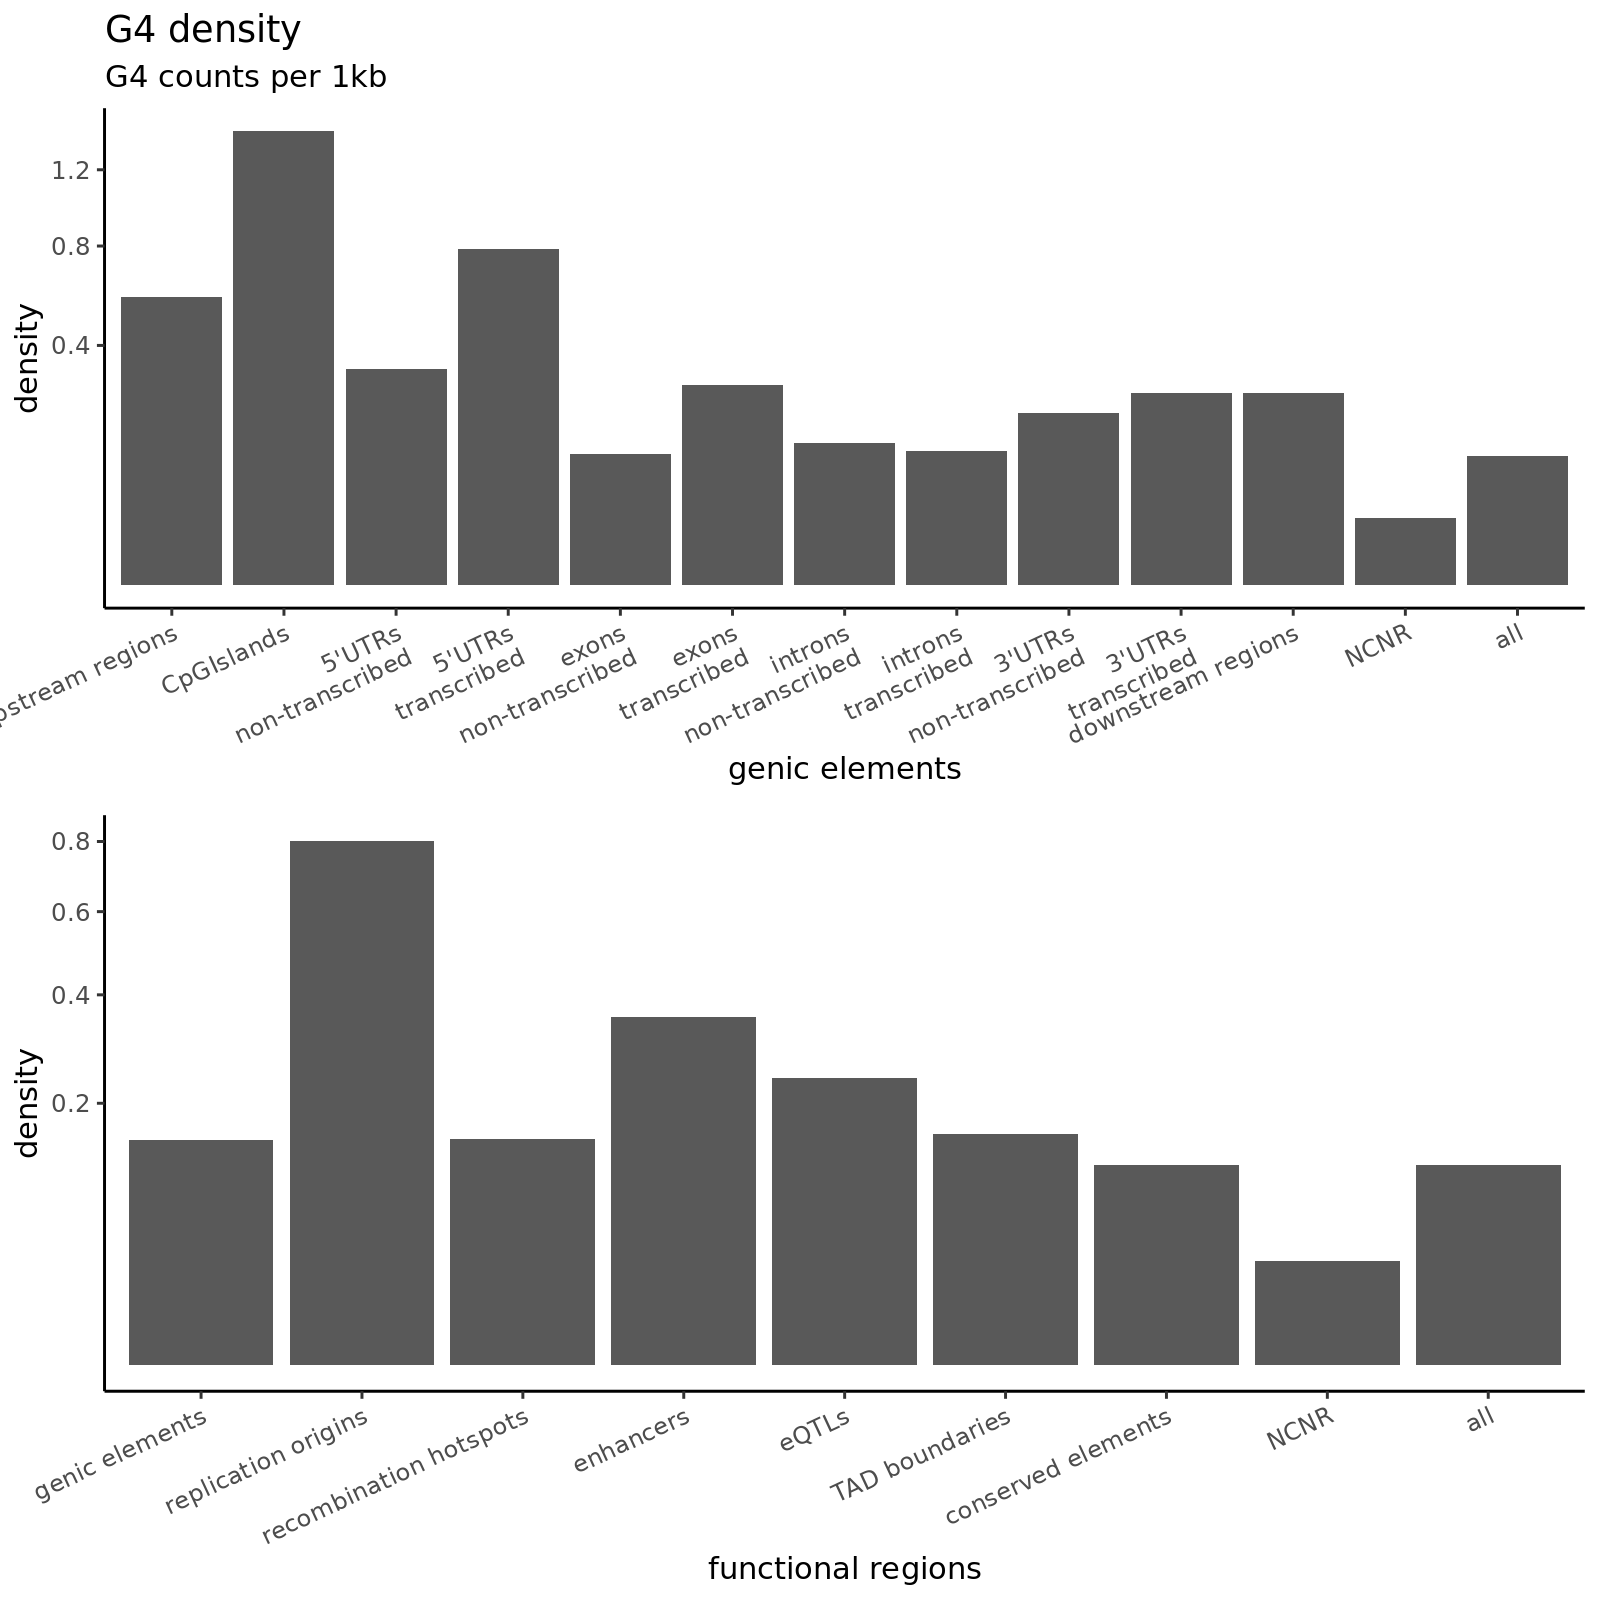

In [2099]:
%%R -w 8 -h 8 --units in -r 200 -i density_all,density_genic,density_RepOrigin,density_eQTL,density_enhancers,density_phastCons,density_TADB,density_recomb_hotspots,density_NCNR,density_Upstream,density_CpGIsland,density_FUTRSense,density_FUTRAntiSense,density_ExonsSense,density_ExonsAntiSense,density_IntronsSense,density_IntronsAntiSense,density_TUTRSense,density_TUTRAntiSense,density_Downstream



df <- data.frame(
  group = c("all",      "genic elements", "replication origins",  "eQTLs",      "enhancers",        "conserved elements",  "TAD boundaries", "recombination hotspots",  "NCNR"),
  value = c(density_all, density_genic,   density_RepOrigin,      density_eQTL,  density_enhancers, density_phastCons,      density_TADB,    density_recomb_hotspots,  density_NCNR)
  )

df_genic <- data.frame(
  group = c("upstream regions", "CpGIslands",       "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed",  "exons\nnon-transcribed", "exons\ntranscribed",  "introns\nnon-transcribed", "introns\ntranscribed",    "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed", "downstream regions",  "NCNR",   "all"),
  value = c(density_Upstream,   density_CpGIsland,  density_FUTRSense,          density_FUTRAntiSense,  density_ExonsSense,      density_ExonsAntiSense, density_IntronsSense,       density_IntronsAntiSense , density_TUTRSense,        density_TUTRAntiSense, density_Downstream, density_NCNR, density_all)
  )

print(head(head(df)))

bar <- ggplot(df, aes(group,value)) + geom_bar(stat = "identity") + 
        theme_classic() +
        theme(axis.text.x=element_text(angle = 25, hjust = 1, family="sans"),
              axis.title.x = element_text(family="sans"),
              axis.text.y = element_text(family="sans"),
              axis.title.y = element_text(family="sans")) +
        labs(y="density", x="functional regions") +
        scale_x_discrete(limits = c("genic elements", "replication origins","recombination hotspots","enhancers", "eQTLs","TAD boundaries",  "conserved elements","NCNR","all")) +
        scale_y_continuous(trans="sqrt")

bar2 <- ggplot(df_genic, aes(group,value)) + geom_bar(stat = "identity") +
        theme_classic() +
        theme(axis.text.x=element_text(angle = 25, hjust = 1, family="sans"),
              axis.title.x = element_text(family="sans"),
              axis.text.y = element_text(family="sans"),
              axis.title.y = element_text(family="sans")) +
        labs(y="density", x="genic elements",title="G4 density", subtitle="G4 counts per 1kb") +
        scale_x_discrete(limits = c("upstream regions",  "CpGIslands",  "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed", "exons\nnon-transcribed", "exons\ntranscribed",  "introns\nnon-transcribed", "introns\ntranscribed", "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed", "downstream regions",  "NCNR",                "all")) +
        scale_y_continuous(trans="sqrt")


grid.arrange(bar2, bar, nrow = 2)

g <- arrangeGrob(bar2, bar, nrow = 2)
ggsave(file='G4density.pdf',g, width=8, height=8, dpi=300)




In [2100]:
density_recomb_hotspots/density_all

1.2796510485890076

In [2101]:
density_TADB/density_all

1.3358539264029912

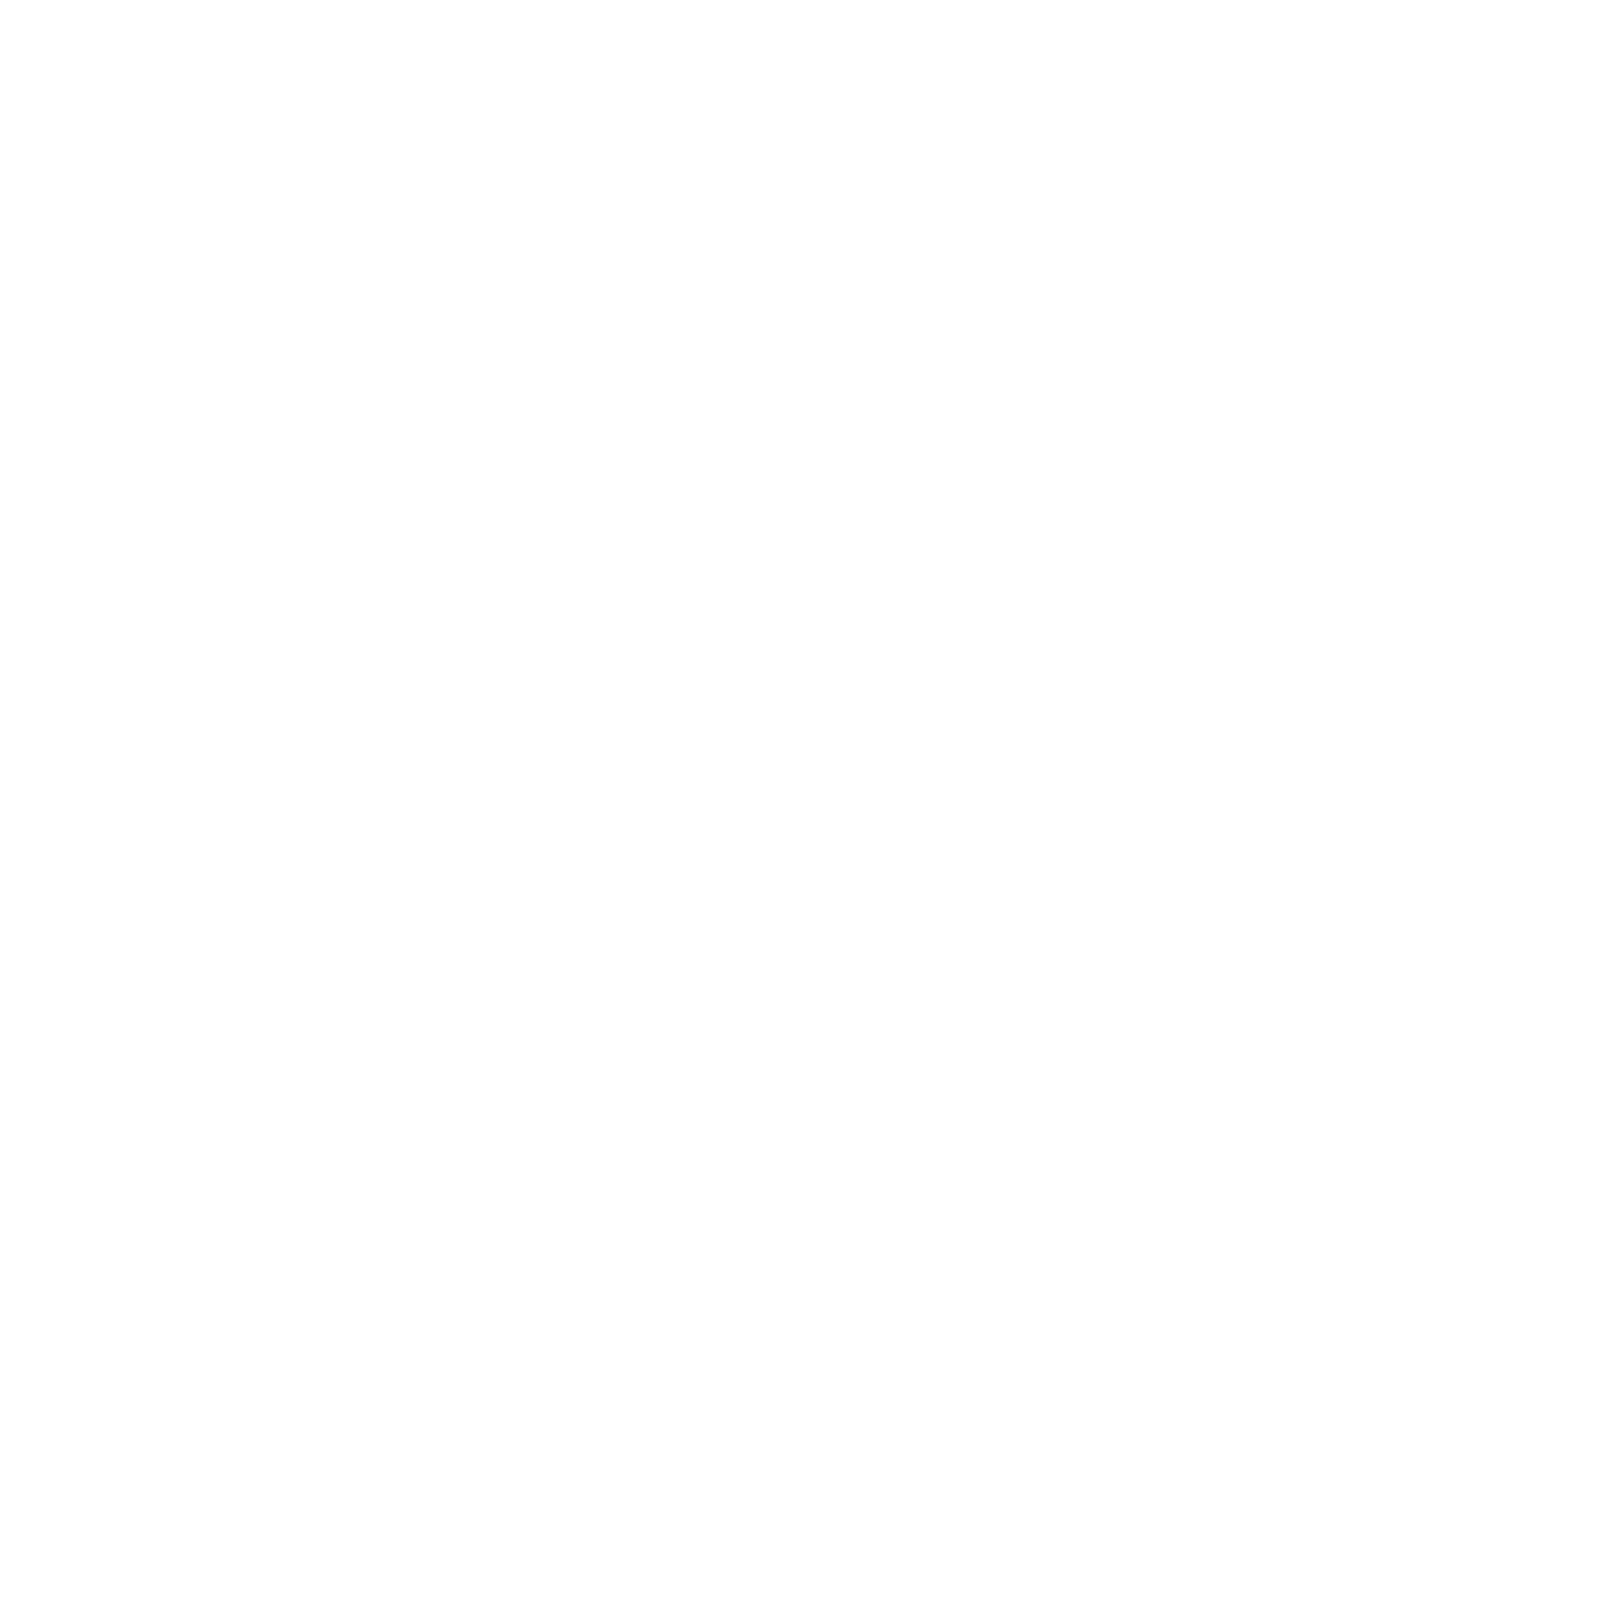

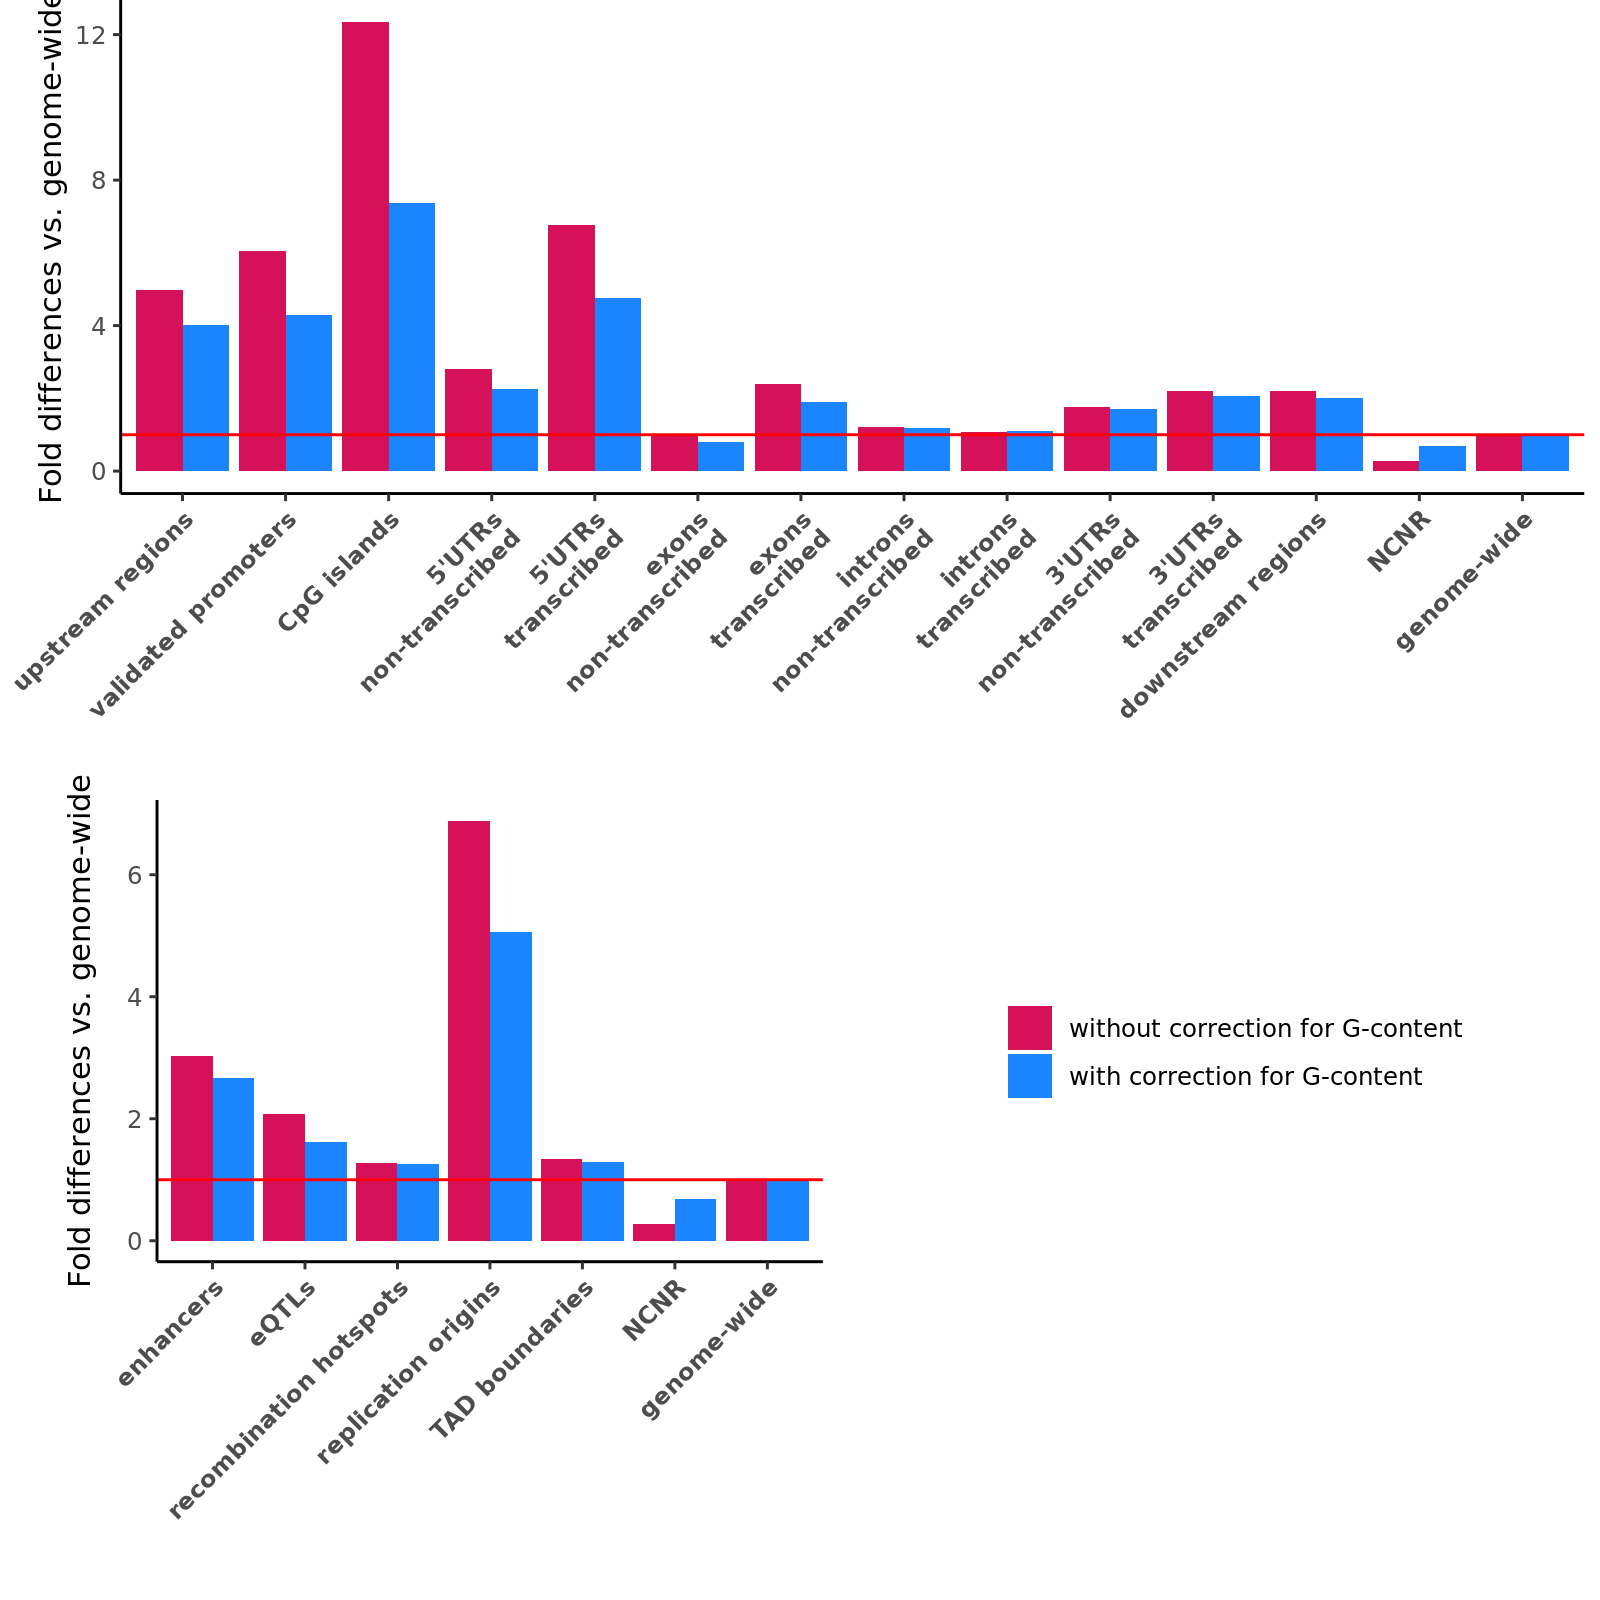

In [2243]:
%%R -w 8 -h 8 --units in -r 200 -i density_promoters,corrected_density_promoters,density_all,density_genic,density_RepOrigin,density_eQTL,density_enhancers,density_phastCons,density_TADB,density_recomb_hotspots,density_NCNR,density_Upstream,density_CpGIsland,density_FUTR_sense,density_FUTR_antisense,density_Exons_sense,density_Exons_antisense,density_Introns_sense,density_Introns_antisense,density_TUTR_sense,density_TUTR_antisense,density_Downstream,corrected_density_all,corrected_density_genic,corrected_density_RepOrigin,corrected_density_eQTL,corrected_density_enhancers,corrected_density_phastCons,corrected_density_TADB,corrected_density_recomb_hotspots,corrected_density_NCNR,corrected_density_Upstream,corrected_density_CpGIsland,corrected_density_FUTRSense,corrected_density_FUTRAntiSense,corrected_density_ExonsSense,corrected_density_ExonsAntiSense,corrected_density_IntronsSense,corrected_density_IntronsAntiSense,corrected_density_TUTRSense,corrected_density_TUTRAntiSense,corrected_density_Downstream

#library(egg)

df <- data.frame(
  type =  c('no correction',  'no correction',        'no correction', 'no correction',     'no correction',  'no correction',               'no correction',      'no correction','with correction',        'with correction',              'with correction',        'with correction',            'with correction',             'with correction',         'with correction',               'with correction',          'with correction'),
  group = c("genic elements",  "replication origins",  "eQTLs",         "enhancers",        "TAD boundaries",  "recombination hotspots",     "NCNR",              "genome-wide",                                    "genic elements", "replication origins",  "eQTLs",         "enhancers",        "conserved elements",  "TAD boundaries",  "recombination hotspots",    "NCNR",               "genome-wide"),
  value = c(c(density_genic,   density_RepOrigin,      density_eQTL,    density_enhancers,   density_TADB,      density_recomb_hotspots,      density_NCNR,        density_all)/density_all, c(corrected_density_genic,  corrected_density_RepOrigin,   corrected_density_eQTL, corrected_density_enhancers, corrected_density_phastCons,  corrected_density_TADB, corrected_density_recomb_hotspots,   corrected_density_NCNR, corrected_density_all) / corrected_density_all)
  )

df_genic <- data.frame(
  type =  c('no correction',     'no correction',    'no correction',     'no correction',            'no correction',        'no correction',           'no correction',           'no correction',            'no correction',            'no correction',             'no correction',       'no correction',          'no correction',      'no correction',           'with correction',          'with correction',            'with correction',      'with correction',          'with correction',        'with correction',           'with correction',           'with correction',             'with correction',             'with correction',            'with correction',           'with correction',      'with correction',     'with correction'),
  group = c("upstream regions",  "validated promoters",         "CpG islands",        "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed",   "exons\nnon-transcribed",  "exons\ntranscribed",      "introns\nnon-transcribed", "introns\ntranscribed",     "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed",     "downstream regions",    "NCNR",                "genome-wide",          "upstream regions",        "validated promoters",                  "CpG islands",          "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed",       "exons\nnon-transcribed",  "exons\ntranscribed",          "introns\nnon-transcribed", "introns\ntranscribed",          "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed",         "downstream regions",    "NCNR",                "genome-wide"),
  value = c(c(density_Upstream,   density_promoters,   density_CpGIsland,    density_FUTRSense,         density_FUTRAntiSense,   density_ExonsSense,   density_ExonsAntiSense,   density_IntronsSense,         density_IntronsAntiSense,  density_TUTRSense,           density_TUTRAntiSense,   density_Downstream,       density_NCNR,      density_all) / density_all, c(corrected_density_Upstream, corrected_density_promoters,  corrected_density_CpGIsland, corrected_density_FUTRSense,    corrected_density_FUTRAntiSense,  corrected_density_ExonsSense, corrected_density_ExonsAntiSense,  corrected_density_IntronsSense, corrected_density_IntronsAntiSense,  corrected_density_TUTRSense,   corrected_density_TUTRAntiSense,  corrected_density_Downstream, corrected_density_NCNR, corrected_density_all) / corrected_density_all)
  )

palette <- c("#D41159", "#1A85FF")

#print(head(head(df)))

bar <- ggplot(df, aes(group,value)) + 
        geom_bar(stat = "identity", aes(fill=type), position="dodge") + 
        geom_hline(yintercept=1, color="red") +
        theme_classic() +
        theme(axis.text.x=element_text(angle = 45, hjust = 1, family="sans", face="bold"),
              axis.title.x = element_text(family="sans"),
              axis.text.y = element_text(family="sans"),
              axis.title.y = element_text(family="sans"),
              plot.margin = unit(c(0,0,5,5), "mm")) +
        labs(y="Fold differences vs. genome-wide", x="") +
        scale_x_discrete(limits = c("enhancers","eQTLs","recombination hotspots","replication origins", "TAD boundaries","NCNR","genome-wide"))+
        scale_fill_manual(name="", values=c(palette[1],palette[2]), labels = c("without correction for G-content","with correction for G-content"))

bar2 <- ggplot(df_genic, aes(group,value)) + 
        geom_bar(stat = "identity", aes(fill=type), position="dodge") + 
        geom_hline(yintercept=1, color="red") +
        theme_classic() +
        theme(legend.position="none",
              axis.text.x=element_text(angle = 45, hjust = 1, family="sans", face="bold"),
              axis.title.x = element_text(family="sans"),
              axis.text.y = element_text(family="sans"),
              axis.title.y = element_text(family="sans"),
              plot.margin = unit(c(0,2,5,5), "mm")) +
        labs(y="Fold differences vs. genome-wide", x="") +
        scale_x_discrete(limits = c("upstream regions", "validated promoters",  "CpG islands",  "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed", "exons\nnon-transcribed", "exons\ntranscribed",  "introns\nnon-transcribed", "introns\ntranscribed", "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed", "downstream regions",  "NCNR", "genome-wide"))+
        scale_fill_manual(values=c(palette[1],palette[2]))



#grid.arrange(bar2, bar, nrow = 2)
#g <- arrangeGrob(bar2, bar, nrow = 2)
#ggsave(file='G4density.pdf',g, width=8, height=8, dpi=300)


# Get the gtables
gA <- ggplotGrob(bar2)
gB <- ggplotGrob(bar)

# Set the widths
gA$widths <- gA$widths * 1
gB$widths <- gB$widths * 1.5

# Arrange the two charts.
# The legend boxes are centered
#grid.newpage()
grid.arrange(gA, gB, nrow = 2)
g <- arrangeGrob(gA, gB, nrow = 2)
ggsave(file='G4density.pdf',g, width=8, height=8, dpi=300)



           type               group     value
1 no correction      genic elements  3.197032
2 no correction replication origins 17.264379
3 no correction               eQTLs  5.197707
4 no correction           enhancers  7.609844
5 no correction  conserved elements  2.527337
6 no correction      TAD boundaries  3.363674


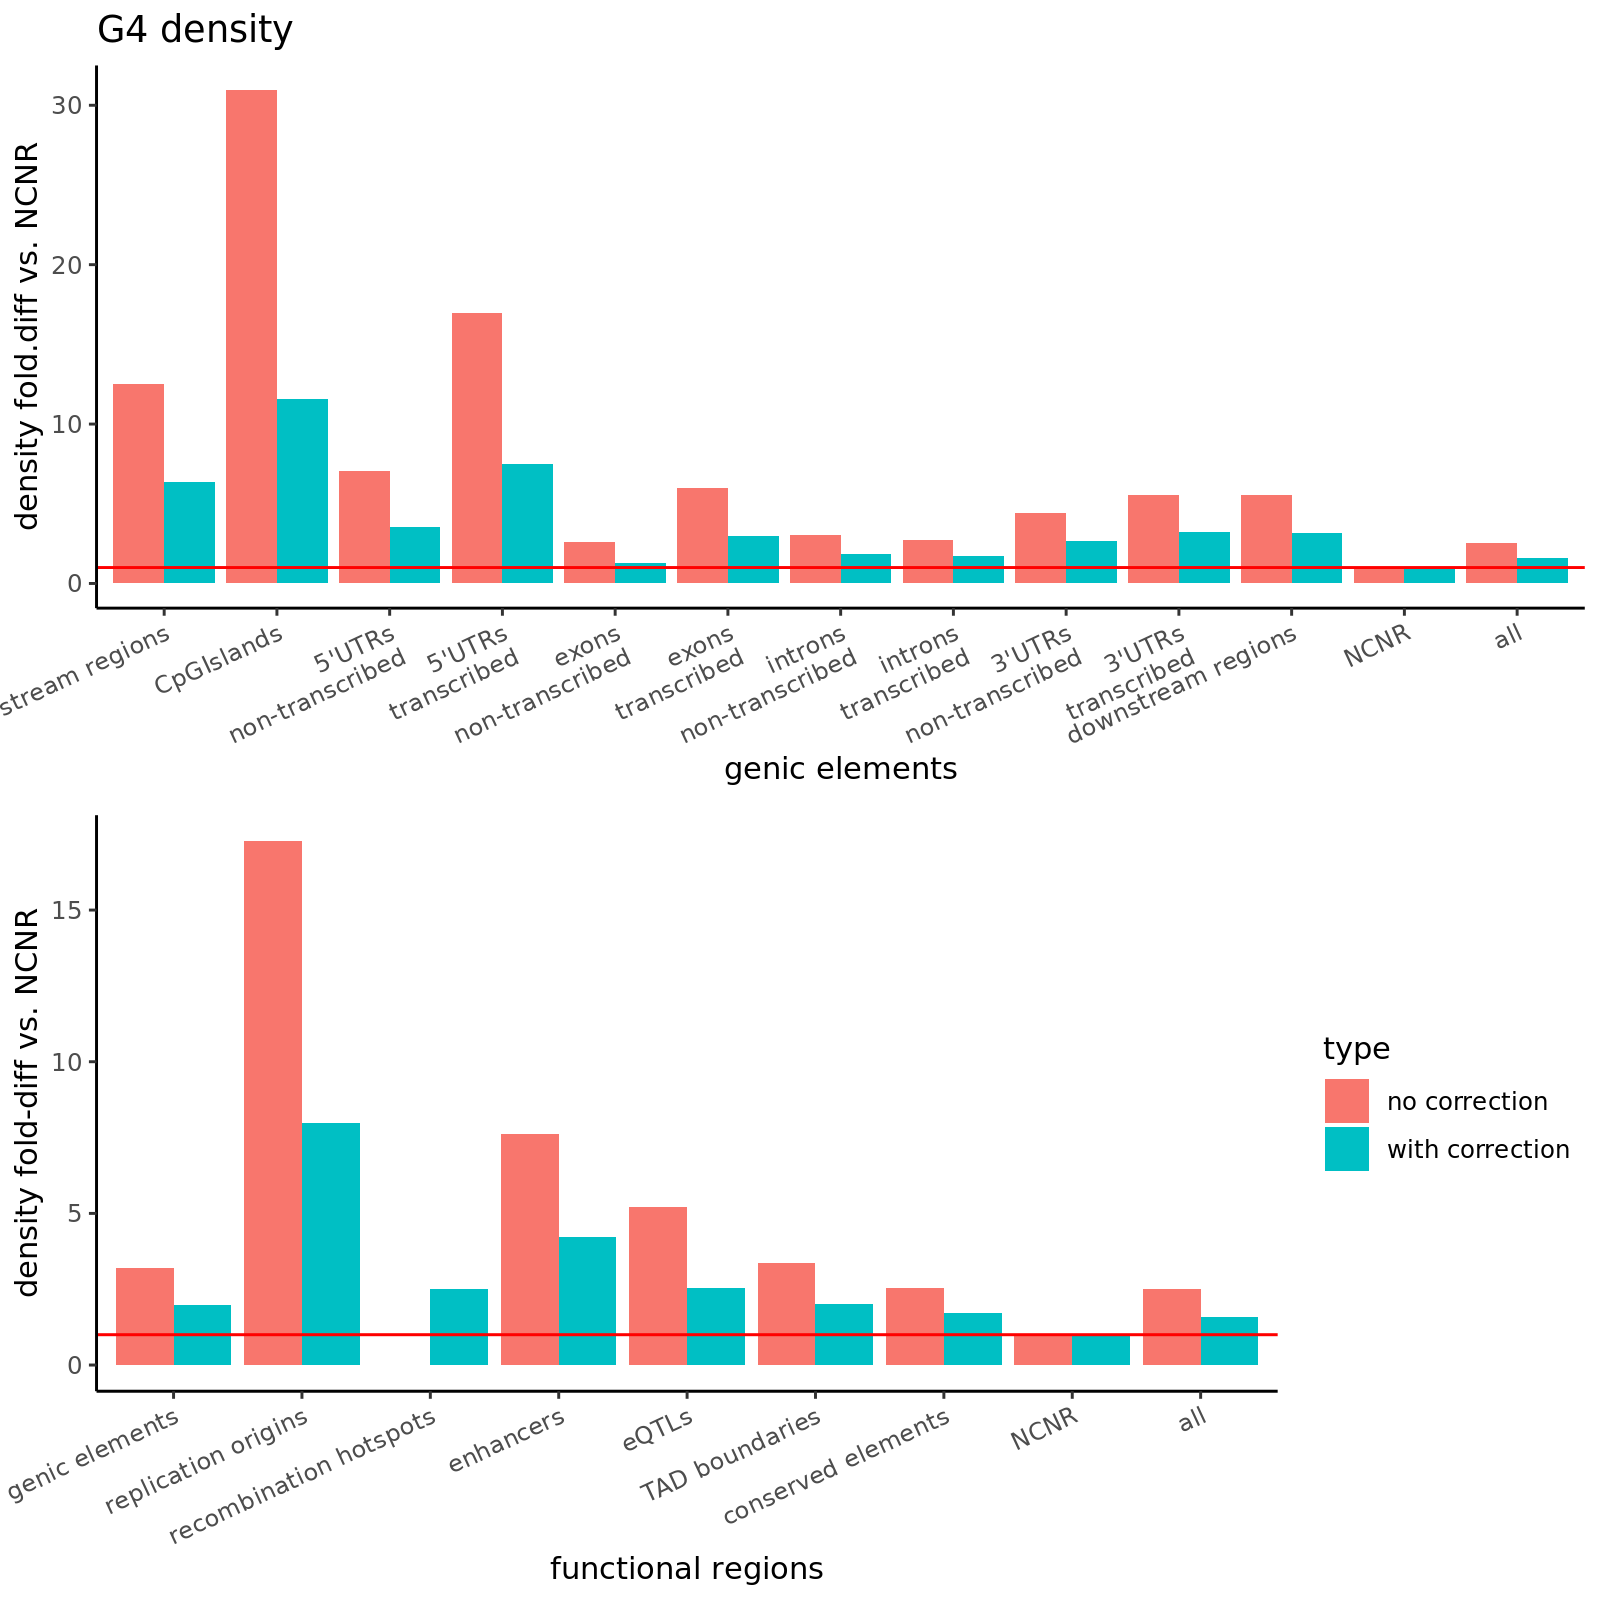

In [1992]:
%%R -w 8 -h 8 --units in -r 200 -i corrected_density_all,corrected_density_genic,corrected_density_RepOrigin,corrected_density_eQTL,corrected_density_enhancers,corrected_density_phastCons,corrected_density_TADB,corrected_density_recomb_hotspots,corrected_density_NCNR,corrected_density_Upstream,corrected_density_CpGIsland,corrected_density_FUTR_sense,corrected_density_FUTR_antisense,corrected_density_Exons_sense,corrected_density_Exons_antisense,corrected_density_Introns_sense,corrected_density_Introns_antisense,corrected_density_TUTR_sense,corrected_density_TUTR_antisense,corrected_density_Downstream


df <- data.frame(
  type =  c('no correction',  'no correction',        'no correction', 'no correction',    'no correction',      'no correction',  'no correction',               'no correction',      'no correction','with correction',        'with correction',              'with correction',        'with correction',            'with correction',             'with correction',         'with correction',               'with correction',          'with correction'),
  group = c("genic elements",   "replication origins",    "eQTLs",            "enhancers",            "conserved elements",   "TAD boundaries",  "recombination hotspots",     "NCNR",              "all",                                    "genic elements", "replication origins",  "eQTLs",         "enhancers",        "conserved elements",  "TAD boundaries",  "recombination hotspots",    "NCNR",               "all"),
  value = c(c(density_genic,   density_RepOrigin,      density_eQTL,     density_enhancers,  density_phastCons,      density_TADB,      density_recomb_hotspots,      density_NCNR,        density_all)/density_NCNR, c(corrected_density_genic,  corrected_density_RepOrigin,   corrected_density_eQTL, corrected_density_enhancers, corrected_density_phastCons,  corrected_density_TADB, corrected_density_recomb_hotspots,   corrected_density_NCNR, corrected_density_all) / corrected_density_NCNR)
  )

df_genic <- data.frame(
  type =  c('no correction',     'no correction',     'no correction',            'no correction',        'no correction',           'no correction',           'no correction',            'no correction',            'no correction',             'no correction',       'no correction',          'no correction',      'no correction',      'with correction',       'with correction',      'with correction',          'with correction',        'with correction',           'with correction',           'with correction',             'with correction',             'with correction',            'with correction',           'with correction',      'with correction',     'with correction'),
  group = c("upstream regions",  "CpGIslands",        "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed",   "exons\nnon-transcribed",  "exons\ntranscribed",      "introns\nnon-transcribed", "introns\ntranscribed",     "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed",     "downstream regions",    "NCNR",                "all",             "upstream regions",      "CpGIslands",          "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed",       "exons\nnon-transcribed",  "exons\ntranscribed",          "introns\nnon-transcribed", "introns\ntranscribed",          "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed",         "downstream regions",    "NCNR",                "all"),
  value = c(c(density_Upstream,   density_CpGIsland,    density_FUTRSense,         density_FUTRAntiSense,   density_ExonsSense,   density_ExonsAntiSense,   density_IntronsSense,         density_IntronsAntiSense,  density_TUTRSense,           density_TUTRAntiSense,   density_Downstream,       density_NCNR,      density_all) / density_NCNR, c(corrected_density_Upstream,  corrected_density_CpGIsland, corrected_density_FUTRSense,    corrected_density_FUTRAntiSense,  corrected_density_ExonsSense, corrected_density_ExonsAntiSense,  corrected_density_IntronsSense, corrected_density_IntronsAntiSense,  corrected_density_TUTRSense,   corrected_density_TUTRAntiSense,  corrected_density_Downstream, corrected_density_NCNR, corrected_density_all) / corrected_density_NCNR)
  )


print(head(head(df)))

bar <- ggplot(df, aes(group,value)) + 
        geom_bar(stat = "identity", aes(fill=type), position="dodge") + 
        geom_hline(yintercept=1, color="red") +
        theme_classic() +
        theme(axis.text.x=element_text(angle = 25, hjust = 1, family="sans"),
              axis.title.x = element_text(family="sans"),
              axis.text.y = element_text(family="sans"),
              axis.title.y = element_text(family="sans")) +
        labs(y="density fold-diff vs. NCNR", x="functional regions") +
        scale_x_discrete(limits = c("genic elements", "replication origins","recombination hotspots","enhancers", "eQTLs","TAD boundaries",  "conserved elements","NCNR","all"))

bar2 <- ggplot(df_genic, aes(group,value)) + 
        geom_bar(stat = "identity", aes(fill=type), position="dodge") + 
        geom_hline(yintercept=1, color="red") +
        theme_classic() +
        theme(legend.position="none",
              axis.text.x=element_text(angle = 25, hjust = 1, family="sans"),
              axis.title.x = element_text(family="sans"),
              axis.text.y = element_text(family="sans"),
              axis.title.y = element_text(family="sans")) +
        labs(y="density fold.diff vs. NCNR", x="genic elements",title="G4 density") +
        scale_x_discrete(limits = c("upstream regions",  "CpGIslands",  "5'UTRs\nnon-transcribed", "5'UTRs\ntranscribed", "exons\nnon-transcribed", "exons\ntranscribed",  "introns\nnon-transcribed", "introns\ntranscribed", "3'UTRs\nnon-transcribed", "3'UTRs\ntranscribed", "downstream regions",  "NCNR",                "all"))


grid.arrange(bar2, bar, nrow = 2)

g <- arrangeGrob(bar2, bar, nrow = 2)
ggsave(file='G4density.pdf',g, width=8, height=8, dpi=300)




# G4 and TE (files from Bruce)

In [7]:
G4TE_file = open('G4_inTE.bed', 'rt')
G4NoTE_file = open('G4_noTE.bed', 'rt')
G4_1_file = open('G4_1_inTed.bed', 'rt')

inTE = []

for line in G4TE_file:
    array = line.strip().split('\t')
    score = float(array[6])
    inTE.append(score)

NotInTE = []

for line in G4NoTE_file:
    array = line.strip().split('\t')
    score = float(array[6])
    NotInTE.append(score)
    
G1 = []

for line in G4_1_file:
    array = line.strip().split('\t')
    score = float(array[6])
    G1.append(score)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


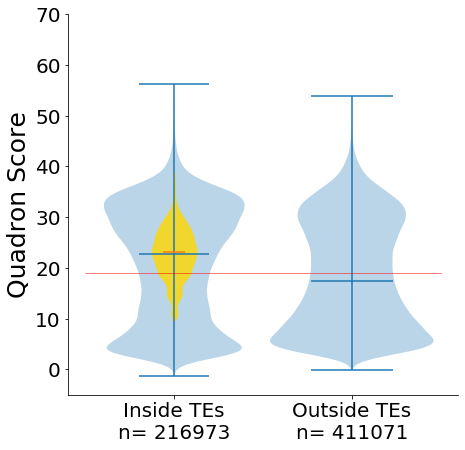

In [8]:
# Help from https://stackoverflow.com/questions/29779079/adding-a-scatter-of-points-to-a-boxplot-using-matplotlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

toplot = [inTE, NotInTE]

fig, ax = plt.subplots(figsize=(7, 7))

sizes = []

for array in toplot:
    sizes.append(len(array))
    
maxsize = max(sizes)

ratiosizes = []

for size in sizes:
    ratiosizes.append(np.log(size/float(maxsize)*100)/2.5)

violin_part1 = ax.violinplot(toplot, showmedians=True, positions=[0,2], widths=ratiosizes)


violin_part2 = ax.violinplot(G1, showmedians=True, positions=[0], showextrema=False) 

for pc in violin_part2['bodies']:
    pc.set_color('gold')
    pc.set_alpha(.8)

ax.plot([-1,3], [19,19], color='red', linewidth=0.5)

ax.set_ylabel('Quadron Score', fontsize=25)
ax.set_ylim(-5,70)

xticks = ax.set_xticks([0,2])
xticks = ax.set_xticklabels(['Inside TEs\nn= '+str(sizes[0]), 'Outside TEs\nn= '+str(sizes[1])])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


In [13]:
print('TEs', permutation_test(inTE, NotInTE, 1000))

TEs (0.000999000999000999, 0.000999000999000999)
G1 (0.000999000999000999, 0.2707292707292707)


## Origins of Replication

```
bedtools intersect -a hs37d5.quadron.bed -b ../Mutations/LocalVariation/RepOrigin.bed > G4_Ori.bed
bedtools intersect -a hs37d5.quadron.bed -b ../Mutations/LocalVariation/RepOrigin.bed -v > G4_NonOri.bed
```

In [5]:
G4_Ori_file = open('G4_Ori.bed', 'rt')
G4_NonOri_file = open('G4_NonOri.bed', 'rt')

Ori = []

for line in G4_Ori_file:
    array = line.strip().split('\t')
    score = float(array[6])
    Ori.append(score)

NonOri = []

for line in G4_NonOri_file:
    array = line.strip().split('\t')
    if array[6] != 'NA':
        score = float(array[6])
        NonOri.append(score)

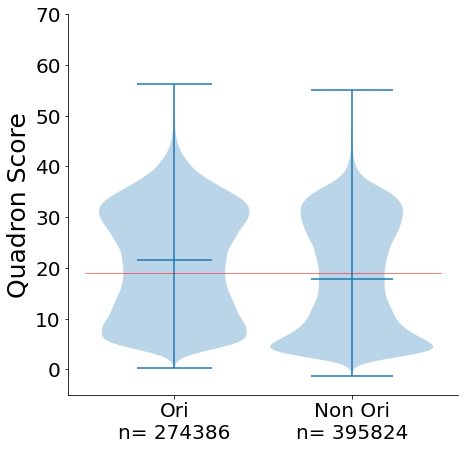

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

toplot = [Ori, NonOri]

fig, ax = plt.subplots(figsize=(7, 7))

sizes = []

for array in toplot:
    sizes.append(len(array))
    
maxsize = max(sizes)

ratiosizes = []

for size in sizes:
    ratiosizes.append(np.log(size/float(maxsize)*100)/2.5)

violin_plot = ax.violinplot(toplot, showmedians=True, positions=[0,2], widths=ratiosizes)

ax.plot([-1,3], [19,19], color='red', linewidth=0.5)

ax.set_ylabel('Quadron Score', fontsize=25)
ax.set_ylim(-5,70)

xticks = ax.set_xticks([0,2])
xticks = ax.set_xticklabels(['Ori\nn= '+str(sizes[0]), 'Non Ori\nn= '+str(sizes[1])])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


In [9]:
print('Oris', permutation_test(Ori, NonOri, 999))

Oris (0.001, 0.001)


# Phylop

https://genome.ucsc.edu/cgi-bin/hgTables?hgta_doMainPage=1&hgta_group=compGeno&hgta_track=cons100way&hgta_table=cons100way&hgsid=703722727_olbbvafvdt7pSAdayu79g3ietTmZ


http://hgdownload.cse.ucsc.edu/goldenPath/hg38/phastCons100way/

```
bigWigToWig hg38.phyloP100way.bw hg38.phyloP100way.wig

python PhyloP.py

array=(1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22)

for a in ${array[*]}; do
        grep -w chr${a} PhyloPhg38.bed > chr${a}.PhyloPhg38.bed;
done;
wait
```

Update: NCBI RefSeq - hg19 \ Primates PhyloP - hg19

```
bedtools intersect -v -a ${Quadron}/hs37d5.quadron.bed -b hg19Upstream1k_RefSeq.bed hg19FUTR_RefSeq.bed  hg19Exons_RefSeq.bed hg19Introns_RefSeq.bed  hg19TUTR_RefSeq.bed hg19Downstream1k_RefSeq.bed hg19Interspersed.bed hg19RM_no_Interspersed.bed -wa > hg19NCNR_Refseq.bed
```

In [ ]:
#Phylop.py
import re

PhyloPFile = open('hg38.phyloP100way.wig', 'rt')
PhyloPBed = open('PhyloPhg38.bed', 'w+')

i = 0
chrom = 'ERROR'
start = 'ERROR'
for line in PhyloPFile:
    line = line.strip()
    match = re.search('.*chrom=(chr[0-9,M,X,Y]+)(_{0,1}\S+\s+|\s)start=([0-9]+)\s+', line)
    if match:
        chrom = match.group(1)
        coord = match.group(3)
        i = 0
    else:
        score = line
        start = str(int(coord)+i-1)
        end = str(int(start)+1)
        PhyloPBed.write(chrom+'\t'+start+'\t'+end+'\t'+score+'\n')
        i+=1

```
bedtools intersect -v -a hg38.quadron.bed -b Upstream.bed FUTRexons.bed CodingExons.bed Introns.bed TUTRexons.bed Downstream.bed -wa > NonGenic

for a in ${array[*]}; do
        echo chr${a};
       bedtools intersect -a hg38.quadron.bed -b ${scratch5}/chr${a}.PhyloPhg38.bed -wa -wb  >> GQuads.intersect
        bedtools intersect -a NonGenic -b ${scratch5}/chr${a}.PhyloPhg38.bed -wa -wb > NonGenic.intersect
       bedtools intersect -a Upstream.bed -b ${scratch5}/chr${a}.PhyloPhg38.bed -wa -wb  >> Upstream.intersect
       bedtools intersect -a FUTRexons.bed -b ${scratch5}/chr${a}.PhyloPhg38.bed -wa -wb  >> FUTRexons.intersect
       bedtools intersect -a CodingExons.bed -b ${scratch5}/chr${a}.PhyloPhg38.bed -wa -wb  >> CodingExons.intersect
       bedtools intersect -a Introns.bed -b ${scratch5}/chr${a}.PhyloPhg38.bed -wa -wb  >> Introns.intersect
       bedtools intersect -a TUTRexons.bed -b ${scratch5}/chr${a}.PhyloPhg38.bed -wa -wb  >> TUTRexons.intersect
       bedtools intersect -a Downstream.bed -b ${scratch5}/chr${a}.PhyloPhg38.bed -wa -wb  >> Downstream.intersect
done;
wait
```

In [ ]:
#PhyloPplotV2.py

import pandas as pd


NonGenicControlFile = open('NonGenic.intersect', 'rt')
NonGenicControlPhyloP = []
for line in NonGenicControlFile:
    array = line.strip().split('\t')
    PhyloP = float(array[10])
    NonGenicControlPhyloP.append(PhyloP)

#print('NonGenicControlPhyloP '+str(len(NonGenicControlPhyloP)))
#print(NonGenicControlPhyloP)

UpstreamControlFile = open('Upstream.intersect', 'rt')
UpstreamControlPhyloP = []
for line in UpstreamControlFile:
    array = line.strip().split('\t')
    PhyloP = float(array[9])
    UpstreamControlPhyloP.append(PhyloP)

#print('UpstreamControlPhyloP '+str(len(UpstreamControlPhyloP)))

FUTRControlFile = open('FUTRexons.intersect', 'rt')
FUTRControlPhyloP = []
for line in FUTRControlFile:
    array = line.strip().split('\t')
    PhyloP = float(array[9])
    FUTRControlPhyloP.append(PhyloP)

#print('FUTRControlPhyloP '+str(len(FUTRControlPhyloP)))

CodingControlFile = open('CodingExons.intersect', 'rt')
CodingControlPhyloP = []
for line in CodingControlFile:
    array = line.strip().split('\t')
    PhyloP = float(array[9])
    CodingControlPhyloP.append(PhyloP)

#print('CodingControlPhyloP '+str(len(CodingControlPhyloP)))

IntronsControlFile = open('Introns.intersect', 'rt')
IntronsControlPhyloP = []
for line in IntronsControlFile:
    array = line.strip().split('\t')
    try:
        PhyloP = float(array[9])
    except:
        print(line)
        break
    IntronsControlPhyloP.append(PhyloP)

#print('IntronsControlPhyloP '+str(len(IntronsControlPhyloP)))

TUTRControlFile = open('TUTRexons.intersect', 'rt')
TUTRControlPhyloP = []
for line in TUTRControlFile:
    array = line.strip().split('\t')
    PhyloP = float(array[9])
    TUTRControlPhyloP.append(PhyloP)

#print('TUTRControlPhyloP '+str(len(TUTRControlPhyloP)))

DownstreamControlFile = open('Downstream.intersect', 'rt')
DownstreamControlPhyloP = []
for line in DownstreamControlFile:
    array = line.strip().split('\t')
    PhyloP = float(array[9])
    DownstreamControlPhyloP.append(PhyloP)

#print('DownstreamControlPhyloP '+str(len(DownstreamControlPhyloP)))

Annotatefile = open('Annotate38', 'rt')

colnames = ['chrom', 'start', 'end', 'motif', 'length', 'strand', 'score', 'Upstream', 'FUTR', 'Coding', 'Introns',\
           'TUTR', 'Downstream', 'Interspersed']
rows = []

for line in Annotatefile:
    array = line.strip().split('\t')
    if array[6] == 'NA': # remove G4 without a score
        continue
    else:
        rows.append([array[0], int(array[1]), int(array[2]), array[3], int(array[4]), array[5], float(array[6]),\
                    float(array[7]),float(array[8]),float(array[9]),float(array[10]),float(array[11]),\
                    float(array[12]),float(array[13])])

dataframe_annotate = pd.DataFrame(data=rows, columns=colnames)

import pandas as pd

Intersectfile = open('GQuads.intersect', 'rt')

motifs = {}

for line in Intersectfile:
    array = line.strip().split('\t')
    #print(array)
    #break
    if array[7] != '.':
        chrom, start, end, PhyloP = array[0], array[1], array[2], array[10]
        key = chrom+'|'+start+'|'+end
        if key in motifs:
            motifs[key].append(PhyloP)
        else:
            motifs[key] = [PhyloP]


colnames = ['chrom', 'start', 'end', 'PhyloP']
rows = []

for motif in motifs:
    chrom, start, end = motif.split('|')
    PhyloP = motifs[motif]
    rows.append([chrom, int(start), int(end), PhyloP])

dataframe_intersect = pd.DataFrame(data=rows, columns=colnames)

df_merged = pd.merge(dataframe_annotate, dataframe_intersect, how='inner', on=['chrom','start', 'end']) #careful with the how option

df_merged.to_csv('Merged2DF.tab', sep='\t', index=False)
#PhyloPplot.py

import pandas as pd

df_merged = pd.read_csv('Merged2DF.tab', sep='\t')
#print(df_merged.info())

NoNGenic = df_merged.loc[df_merged['Upstream'] == 0]\
            .loc[df_merged['FUTR'] == 0]\
            .loc[df_merged['Coding'] == 0]\
            .loc[df_merged['Introns'] == 0]\
            .loc[df_merged['TUTR'] == 0]\
            .loc[df_merged['Downstream'] == 0]


NoNGenicPhyloP = NoNGenic.PhyloP
NoNGeniclist = []
for item in NoNGenicPhyloP:
    item = item.translate(None, "\'")
    array = item[1:-1].split(",")
    values = map(lambda x: float(x), array)
    NoNGeniclist = NoNGeniclist + values

#print('NoNGeniclist '+str(len(NoNGeniclist)))
#print(NoNGeniclist)

Upstream = df_merged.loc[df_merged['Upstream'] != 0]\
            .loc[df_merged['FUTR'] == 0]\
            .loc[df_merged['Coding'] == 0]\
            .loc[df_merged['Introns'] == 0]\
            .loc[df_merged['TUTR'] == 0]\
            .loc[df_merged['Downstream'] == 0]

UpstreamPhyloP = Upstream.PhyloP
Upstreamlist = []
for item in UpstreamPhyloP:
    item = item.translate(None, "\'")
    array = item[1:-1].split(",")
    values = map(lambda x: float(x), array)
    Upstreamlist = Upstreamlist + values

#print('Upstreamlist '+str(len(Upstreamlist)))
#print(Upstreamlist)

FUTR = df_merged.loc[df_merged['Upstream'] == 0]\
            .loc[df_merged['FUTR'] != 0]\
            .loc[df_merged['Coding'] == 0]\
            .loc[df_merged['Introns'] == 0]\
            .loc[df_merged['TUTR'] == 0]\
            .loc[df_merged['Downstream'] == 0]


FUTRPhyloP = FUTR.PhyloP
FUTRlist = []
for item in FUTRPhyloP:
    item = item.translate(None, "\'")
    array = item[1:-1].split(",")
    values = map(lambda x: float(x), array)
    FUTRlist = FUTRlist + values

#print('FUTRlist '+str(len(FUTRlist)))

Coding = df_merged.loc[df_merged['Upstream'] == 0]\
            .loc[df_merged['FUTR'] == 0]\
            .loc[df_merged['Coding'] != 0]\
            .loc[df_merged['Introns'] == 0]\
            .loc[df_merged['TUTR'] == 0]\
            .loc[df_merged['Downstream'] == 0]

CodingPhyloP = Coding.PhyloP
Codinglist = []
for item in CodingPhyloP:
    item = item.translate(None, "\'")
    array = item[1:-1].split(",")
    values = map(lambda x: float(x), array)
    Codinglist = Codinglist + values

#print('Codinglist '+str(len(Codinglist)))

Introns = df_merged.loc[df_merged['Upstream'] == 0]\
            .loc[df_merged['FUTR'] == 0]\
            .loc[df_merged['Coding'] == 0]\
            .loc[df_merged['Introns'] != 0]\
            .loc[df_merged['TUTR'] == 0]\
            .loc[df_merged['Downstream'] == 0]

IntronsPhyloP = Introns.PhyloP
Intronslist = []
for item in IntronsPhyloP:
    item = item.translate(None, "\'")
    array = item[1:-1].split(",")
    values = map(lambda x: float(x), array)
    Intronslist = Intronslist + values

#print('Intronslist '+str(len(Intronslist)))

TUTR = df_merged.loc[df_merged['Upstream'] == 0]\
            .loc[df_merged['FUTR'] == 0]\
            .loc[df_merged['Coding'] == 0]\
            .loc[df_merged['Introns'] == 0]\
            .loc[df_merged['TUTR'] != 0]\
            .loc[df_merged['Downstream'] == 0]

TUTRPhyloP = TUTR.PhyloP
TUTRlist = []
for item in TUTRPhyloP:
    item = item.translate(None, "\'")
    array = item[1:-1].split(",")
    values = map(lambda x: float(x), array)
    TUTRlist = TUTRlist + values

#print('TUTRlist '+str(len(TUTRlist)))

Downstream = df_merged.loc[df_merged['Upstream'] == 0]\
            .loc[df_merged['FUTR'] == 0]\
            .loc[df_merged['Coding'] == 0]\
            .loc[df_merged['Introns'] == 0]\
            .loc[df_merged['TUTR'] == 0]\
            .loc[df_merged['Downstream'] != 0]

DownstreamPhyloP = Downstream.PhyloP
Downstreamlist = []
for item in DownstreamPhyloP:
    item = item.translate(None, "\'")
    array = item[1:-1].split(",")
    values = map(lambda x: float(x), array)
    Downstreamlist = Downstreamlist + values

#print('Downstreamlist '+str(len(Downstreamlist)))

import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import numpy as np

#print(NoNGeniclist)
#print(NonGenicControlPhyloP)

toplot = [NoNGeniclist, NonGenicControlPhyloP,\
          Upstreamlist, UpstreamControlPhyloP,\
          FUTRlist, FUTRControlPhyloP,\
          Codinglist, CodingControlPhyloP,\
          Intronslist, IntronsControlPhyloP,\
          TUTRlist, TUTRControlPhyloP,\
          Downstreamlist, DownstreamControlPhyloP]

fig, ax = plt.subplots(figsize=(8, 8))

#print(toplot)
ax.boxplot(toplot, positions = [1,2,4,5,7,8,10,11,13,14,16,17,19,20], showfliers=False)
ax.plot([-0,25], [0,0], color='blue', linewidth=0.5)


ax.set_ylabel('PhyloP', fontsize=15)

xticks = ax.set_xticklabels(['Non Genic', '', 'Upstream', '', "5'UTR Exon", '', 'Coding Exon', '', 'Intron', '',\
                             "3'UTR Exon", '','Downstream', '', 'Interspersed', ''], rotation=30)


fig.savefig('PhyloP.png')
                                                                                                                     282,25        Bot


In [1]:
import numpy as np
import matplotlib.pyplot as plt

a = np.random.random(100)
b = np.random.random(100)
c = np.random.random(100)
d = np.random.random(100)

fig, ax = plt.subplots(figsize=(7, 7))

plt.boxplot([a,b,c,d], positions = [1,2,4,5], widths = 0.6, showfliers=False)
#plt.boxplot([c,d], positions = [4, 5], widths = 0.6, showfliers=False)

[0.39198408 0.9820589  0.85684107 0.1562726  0.11476707 0.40317747
 0.74437245 0.24162207 0.98298906 0.57085191 0.25479197 0.28482395
 0.80314187 0.04158203 0.71141411 0.21134919 0.28279628 0.83950659
 0.76433379 0.58108594 0.74548157 0.12220062 0.88362651 0.29080869
 0.4446878  0.69967132 0.22877015 0.84450346 0.54521372 0.85535143
 0.62534621 0.42473047 0.83857773 0.51514843 0.4905897  0.28163115
 0.26720206 0.8366522  0.09855295 0.80704297 0.18180579 0.22080935
 0.85217927 0.38157454 0.17607438 0.46112654 0.23029979 0.5137408
 0.54965896 0.15071319 0.34492344 0.5469486  0.60391717 0.7590965
 0.7993322  0.7258168  0.41676017 0.50844854 0.88078628 0.04748914
 0.16450168 0.38195062 0.10214011 0.30329823 0.83347744 0.64370298
 0.39023842 0.37147743 0.43006816 0.1279834  0.44248032 0.11122344
 0.15621651 0.66276756 0.29796015 0.67511239 0.13478192 0.43704564
 0.3768986  0.53491363 0.11193505 0.06659084 0.50550107 0.3861546
 0.00300137 0.9410956  0.40874499 0.50162171 0.16057189 0.3527243

{'boxes': [<matplotlib.lines.Line2D at 0x7fcc0dfda250>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcc0dfdaa90>,
 'fliers': [],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fcc0df6c250>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7fcc0dfda310>,
  <matplotlib.lines.Line2D at 0x7fcc0df90b50>]}

In [3]:
np.array([2.])

array([2.])

In [1]:
import pandas as pd

Annotatefile = open('Annotate38', 'rt')

colnames = ['chrom', 'start', 'end', 'motif', 'length', 'strand', 'score', 'Upstream', 'FUTR', 'Coding', 'Introns',\
           'TUTR', 'Downstream', 'Interspersed']
rows = []

for line in Annotatefile:
    array = line.strip().split('\t')
    if array[6] == 'NA': # remove G4 without a score
        continue
    else:
        rows.append([array[0], int(array[1]), int(array[2]), array[3], int(array[4]), array[5], float(array[6]),\
                    float(array[7]),float(array[8]),float(array[9]),float(array[10]),float(array[11]),\
                    float(array[12]),float(array[13])])

dataframe_annotate = pd.DataFrame(data=rows, columns=colnames)

Intersectfile = open('GQuads.intersect', 'rt')

motifs = {}

for line in Intersectfile:
    array = line.strip().split('\t')
    #print(array)
    #break
    if array[7] != '.':
        chrom, start, end, PhyloP = array[0], array[1], array[2], array[10]
        key = chrom+'|'+start+'|'+end
        if key in motifs:
            motifs[key].append(PhyloP)
        else:
            motifs[key] = [PhyloP]


colnames = ['chrom', 'start', 'end', 'PhyloP']
rows = []

for motif in motifs:
    chrom, start, end = motif.split('|')
    PhyloP = motifs[motif]
    rows.append([chrom, int(start), int(end), PhyloP])

dataframe_intersect = pd.DataFrame(data=rows, columns=colnames)

df_merged = pd.merge(dataframe_annotate, dataframe_intersect, how='inner', on=['chrom','start', 'end']) #careful with the how option

In [ ]:
# Non Coding, Non Repetitive
NCNR = df_merged.loc[df_merged['Upstream'] == 0]\
            .loc[df_merged['FUTR'] == 0]\
            .loc[df_merged['Coding'] == 0]\
            .loc[df_merged['Introns'] == 0]\
            .loc[df_merged['TUTR'] == 0]\
            .loc[df_merged['Downstream'] == 0]\
            .loc[df_merged['Interspersed'] == 0]\
            ['PhyloP'].tolist()

NCNRlist = []    
for item in NCNR:
    NCNRlist = NCNRlist + item
        
        
Upstream = df_merged.loc[df_merged['Upstream'] != 0]\
            .loc[df_merged['FUTR'] == 0]\
            .loc[df_merged['Coding'] == 0]\
            .loc[df_merged['Introns'] == 0]\
            .loc[df_merged['TUTR'] == 0]\
            .loc[df_merged['Downstream'] == 0]\
            .loc[df_merged['Interspersed'] == 0]\
            ['PhyloP'].tolist()
            
Upstreamlist = []    
for item in Upstream:
    Upstreamlist = Upstreamlist + item

FUTR = df_merged.loc[df_merged['Upstream'] == 0]\
            .loc[df_merged['FUTR'] != 0]\
            .loc[df_merged['Coding'] == 0]\
            .loc[df_merged['Introns'] == 0]\
            .loc[df_merged['TUTR'] == 0]\
            .loc[df_merged['Downstream'] == 0]\
            .loc[df_merged['Interspersed'] == 0]\
            ['PhyloP'].tolist()
            
FUTRlist = []    
for item in FUTR:
    FUTRlist = FUTRlist + item
            
Coding = df_merged.loc[df_merged['Upstream'] == 0]\
            .loc[df_merged['FUTR'] == 0]\
            .loc[df_merged['Coding'] != 0]\
            .loc[df_merged['Introns'] == 0]\
            .loc[df_merged['TUTR'] == 0]\
            .loc[df_merged['Downstream'] == 0]\
            .loc[df_merged['Interspersed'] == 0]\
            ['PhyloP'].tolist()
            
Codinglist = []    
for item in Coding:
    Codinglist = Codinglist + item
            
Introns = df_merged.loc[df_merged['Upstream'] == 0]\
            .loc[df_merged['FUTR'] == 0]\
            .loc[df_merged['Coding'] == 0]\
            .loc[df_merged['Introns'] != 0]\
            .loc[df_merged['TUTR'] == 0]\
            .loc[df_merged['Downstream'] == 0]\
            .loc[df_merged['Interspersed'] == 0]\
            ['PhyloP'].tolist()
            
Intronslist = []    
for item in Introns:
    Intronslist = Intronslist + item

TUTR = df_merged.loc[df_merged['Upstream'] == 0]\
            .loc[df_merged['FUTR'] == 0]\
            .loc[df_merged['Coding'] == 0]\
            .loc[df_merged['Introns'] == 0]\
            .loc[df_merged['TUTR'] != 0]\
            .loc[df_merged['Downstream'] == 0]\
            .loc[df_merged['Interspersed'] == 0]\
            ['PhyloP'].tolist()
            
TUTRlist = []    
for item in TUTR:
    TUTRlist = TUTRlist + item

Downstream = df_merged.loc[df_merged['Upstream'] == 0]\
            .loc[df_merged['FUTR'] == 0]\
            .loc[df_merged['Coding'] == 0]\
            .loc[df_merged['Introns'] == 0]\
            .loc[df_merged['TUTR'] == 0]\
            .loc[df_merged['Downstream'] != 0]\
            .loc[df_merged['Interspersed'] == 0]\
            ['PhyloP'].tolist()
            
Downstreamlist = []    
for item in Downstream:
    Downstreamlist = Downstreamlist + item

Interspersed = df_merged.loc[df_merged['Upstream'] == 0]\
            .loc[df_merged['FUTR'] == 0]\
            .loc[df_merged['Coding'] == 0]\
            .loc[df_merged['Introns'] == 0]\
            .loc[df_merged['TUTR'] == 0]\
            .loc[df_merged['Downstream'] == 0]\
            .loc[df_merged['Interspersed'] != 0]\
            ['PhyloP'].tolist()
            
Interspersedlist = []    
for item in Interspersed:
    Interspersedlist = Interspersedlist + item

In [6]:
NCNRlist = map(lambda x: float(x), NCNRlist)
Upstreamlist = map(lambda x: float(x), Upstreamlist)
FUTRlist = map(lambda x: float(x), FUTRlist)
Codinglist = map(lambda x: float(x), Codinglist)
Intronslist = map(lambda x: float(x), Intronslist)
TUTRlist = map(lambda x: float(x), TUTRlist)
Downstreamlist = map(lambda x: float(x), Downstreamlist)
Interspersedlist = map(lambda x: float(x), Interspersedlist)

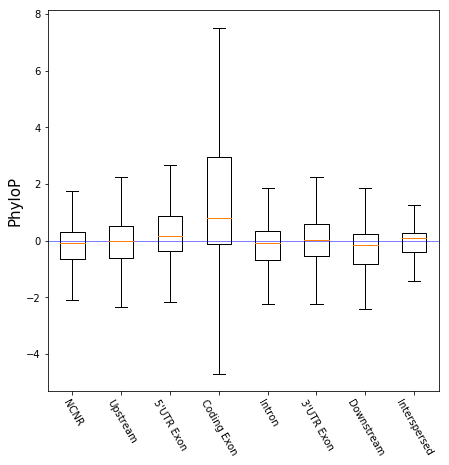

In [9]:
# Help from https://stackoverflow.com/questions/29779079/adding-a-scatter-of-points-to-a-boxplot-using-matplotlib
import matplotlib.pyplot as plt
import numpy as np

toplot = [NCNRlist, Upstreamlist, FUTRlist, Codinglist, Intronslist, TUTRlist, Downstreamlist, Interspersedlist]

fig, ax = plt.subplots(figsize=(7, 7))

ax.boxplot(toplot, showfliers=False)
ax.plot([-0,10], [0,0], color='blue', linewidth=0.5)

#for i in range(0, len(toplot)):
#    y = toplot[i]
#    x = np.random.normal(1+i, 0.04, size=len(y))
#    ax.plot(x, y, 'r.', alpha=0.2)

ax.set_ylabel('PhyloP', fontsize=15)

xticks = ax.set_xticklabels(['NCNR', 'Upstream', "5'UTR Exon", 'Coding Exon', 'Intron', "3'UTR Exon",\
                                  'Downstream', 'Interspersed'], rotation=300)

Probably need to correct by control within same region

# IPD

```
cut -f 1-5 hs37d5.quadron.bed | env LC_ALL=C sort -k 1,1d -k 2,2n > hs37d5.quadron.sorted
python collect_values_in_windows.py hs37d5.quadron.sorted ../kinetics_bk/H5/align/52XIPD > hs37d5.quadron.sorted.IPD
python addchr.py hs37d5.quadron.sorted.IPD temp
mv temp hs37d5.quadron.sorted.IPD
```

In [15]:
import numpy as np
QuadronIPD = open('hs37d5.quadron.sorted.IPD', 'rt')
QuadronIPDMeans = open('hs37d5.quadron.sorted.MeanIPD', 'w+')

for line in QuadronIPD:
    array = line.strip().split(' ')
    #print(array[:5])
    IPDs = map(lambda x: float(x), array[5:])
    #print(IPDs)
    meanIPD = np.nanmean(IPDs)
    #print(meanIPD)
    for i in range(0,5):
        QuadronIPDMeans.write(array[i]+'\t')
    QuadronIPDMeans.write(str(meanIPD)+'\n')
    #break

/opt/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


```
bedtools annotate -i hs37d5.quadron.sorted.MeanIPD -files ${LocalVar}/hg19Upstream.bed ${LocalVar}/hg19FUTR.bed  ${LocalVar}/hg19Coding.bed ${LocalVar}/hg19Introns.bed  ${LocalVar}/hg19TUTR.bed ${LocalVar}/hg19Downstream.bed hg19NCNR_Refseq.bed > Annotate19IPD
```

In [28]:
import pandas as pd

Annotatefile = open('Annotate19IPD', 'rt')

colnames = ['chrom', 'start', 'end', 'motif', 'length', 'MeanIPD', 'Upstream', 'FUTR',\
            'Coding', 'Introns', 'TUTR', 'RepeatMasked', 'Downstream', 'NCNR']
rows = []

for line in Annotatefile:
    array = line.strip().split('\t')
    if array[6] == 'NA': # remove G4 without a score
        continue
    else:
        rows.append([array[0], int(array[1]), int(array[2]), array[3], int(array[4]),\
                    float(array[5]), float(array[6]), float(array[7]),float(array[8]),\
                    float(array[9]),float(array[10]),float(array[11]),\
                    float(array[12])])

dataframe_annotate = pd.DataFrame(data=rows, columns=colnames)

In [8]:
dataframe_annotate.head()

,chrom,start,end,motif,length,MeanIPD,Upstream,FUTR,Coding,Introns,TUTR,Downstream,NCNR
0,chr1,98566115,98566153,CCCTACTGTTTCCCAAGGAACATTCCCTTTCACCCCCC,38,0.996744,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,chr1,230686692,230686721,CCCCTTGCCCCCAACCCCGCGACAGGCCC,29,1.217267,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,chr1,22151141,22151178,CCCAGATTCCCATCCTCCCCATTAGGCCCATGGGCCC,37,0.968711,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,chr1,46923728,46923791,GGGCCTGGAGTGGGGCTGATGGGTCTCCCAACTCTGGGAAGGGGTG...,63,1.311109,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,chr1,57016303,57016339,CCCCTCCTCCCCTTGTAACCCAGCCCACCTGACCCC,36,0.990514,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [29]:
# Non Coding, Non Repetitive
NCNR = dataframe_annotate.loc[dataframe_annotate['Upstream'] == 0]\
            .loc[dataframe_annotate['FUTR'] == 0]\
            .loc[dataframe_annotate['Coding'] == 0]\
            .loc[dataframe_annotate['Introns'] == 0]\
            .loc[dataframe_annotate['TUTR'] == 0]\
            .loc[dataframe_annotate['Downstream'] == 0]
            
Upstream = dataframe_annotate.loc[dataframe_annotate['Upstream'] != 0]\
            .loc[dataframe_annotate['FUTR'] == 0]\
            .loc[dataframe_annotate['Coding'] == 0]\
            .loc[dataframe_annotate['Introns'] == 0]\
            .loc[dataframe_annotate['TUTR'] == 0]\
            .loc[dataframe_annotate['Downstream'] == 0]

FUTR = dataframe_annotate.loc[dataframe_annotate['Upstream'] == 0]\
            .loc[dataframe_annotate['FUTR'] != 0]\
            .loc[dataframe_annotate['Coding'] == 0]\
            .loc[dataframe_annotate['Introns'] == 0]\
            .loc[dataframe_annotate['TUTR'] == 0]\
            .loc[dataframe_annotate['Downstream'] == 0]
            
Coding = dataframe_annotate.loc[dataframe_annotate['Upstream'] == 0]\
            .loc[dataframe_annotate['FUTR'] == 0]\
            .loc[dataframe_annotate['Coding'] != 0]\
            .loc[dataframe_annotate['Introns'] == 0]\
            .loc[dataframe_annotate['TUTR'] == 0]\
            .loc[dataframe_annotate['Downstream'] == 0]
            
Introns = dataframe_annotate.loc[dataframe_annotate['Upstream'] == 0]\
            .loc[dataframe_annotate['FUTR'] == 0]\
            .loc[dataframe_annotate['Coding'] == 0]\
            .loc[dataframe_annotate['Introns'] != 0]\
            .loc[dataframe_annotate['TUTR'] == 0]\
            .loc[dataframe_annotate['Downstream'] == 0]

TUTR = dataframe_annotate.loc[dataframe_annotate['Upstream'] == 0]\
            .loc[dataframe_annotate['FUTR'] == 0]\
            .loc[dataframe_annotate['Coding'] == 0]\
            .loc[dataframe_annotate['Introns'] == 0]\
            .loc[dataframe_annotate['TUTR'] != 0]\
            .loc[dataframe_annotate['Downstream'] == 0]

Downstream = dataframe_annotate.loc[dataframe_annotate['Upstream'] == 0]\
            .loc[dataframe_annotate['FUTR'] == 0]\
            .loc[dataframe_annotate['Coding'] == 0]\
            .loc[dataframe_annotate['Introns'] == 0]\
            .loc[dataframe_annotate['TUTR'] == 0]\
            .loc[dataframe_annotate['Downstream'] != 0]

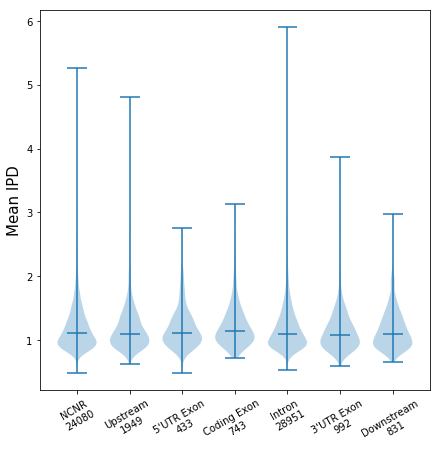

In [30]:
# Help from https://stackoverflow.com/questions/29779079/adding-a-scatter-of-points-to-a-boxplot-using-matplotlib
import matplotlib.pyplot as plt
import numpy as np

toplot = [NCNR.MeanIPD[~np.isnan(NCNR.MeanIPD)].tolist(),\
          Upstream.MeanIPD[~np.isnan(Upstream.MeanIPD)].tolist(),\
          FUTR.MeanIPD[~np.isnan(FUTR.MeanIPD)].tolist(),\
          Coding.MeanIPD[~np.isnan(Coding.MeanIPD)].tolist(),\
          Introns.MeanIPD[~np.isnan(Introns.MeanIPD)].tolist(),\
          TUTR.MeanIPD[~np.isnan(TUTR.MeanIPD)].tolist(),\
          Downstream.MeanIPD[~np.isnan(Downstream.MeanIPD)].tolist()]

fig, ax = plt.subplots(figsize=(7, 7))

ax.violinplot(toplot, showmedians=True, positions=[0,2,4,6,8,10,12], widths=1.5)


ax.set_ylabel('Mean IPD', fontsize=15)

sizes = []

for array in toplot:
    sizes.append(len(array))

xticks = ax.set_xticklabels(['','NCNR\n'+str(sizes[0]), 'Upstream\n'+str(sizes[1]), "5'UTR Exon\n"+str(sizes[2]),\
                             'Coding Exon\n'+str(sizes[3]), 'Intron\n'+str(sizes[4]), "3'UTR Exon\n"+str(sizes[5]),\
                                  'Downstream\n'+str(sizes[6])], rotation=30)

